<a href="https://colab.research.google.com/github/ElenaBetelgeuse/Automatic-segmentation-of-brain-tumors-using-UNET/blob/main/GRADUATE_PROJECT_23_06_2024_13_27.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

В качестве набора данных была выбрана сегментация опухолей головного мозга (BraTS2020)

Данный набор данных содержит мультимодальные сканы сегментации опухоли головного мозга, которые находятся в формате файла NIfTI (.nii.gz) и описывают различные объемы, такие как:

 - родной (Т1)


 - постконтрастный Т1-взвешенный (T1Gd)


 - Т2-взвешенный (Т2)


 - T2 Инверсионное восстановление с ослаблением жидкости (T2-FLAIR)


Аннотации опухолей включают:

 - некротическое ядро опухоли без контрастирования (NCR/NET — lable 1)


 - перитуморальный отек (ED — lable 2)


 - Опухоль, усиливающая GD (ET — lable 4)



Каждый пиксель маски помечен «1», если он принадлежит к одному из классов (NCR/NET — lable 1, ED — lable 2, ET — lable 4, и «0» — если пиксель не относится ни к одному из классов.

In [ ]:
# Подключение Google Drive к виртуальной машине:
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)

Mounted at /content/gdrive


In [ ]:
# Просматриваем содержимое диска
!ls /content/gdrive/

MyDrive


In [ ]:
# Копирование данных с Google Drive на локальный диск виртуальной машины

In [ ]:
!cp /content/gdrive/MyDrive/DATA/GRADUATE_PROJECT/survival_info.csv .

In [ ]:
!cp /content/gdrive/MyDrive/DATA/GRADUATE_PROJECT/name_mapping.csv .

In [ ]:
!cp /content/gdrive/MyDrive/DATA/GRADUATE_PROJECT/meta_data.csv .

In [ ]:
import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision.transforms as transforms
from torch.autograd import Variable
from sklearn.model_selection import train_test_split
import itertools
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm as tqdm
import matplotlib
import re

In [ ]:
# Имеем датасет с файлами медицинских изображений .h5

# **Организация данных в файле .h5 (формат HDF5).**

Файл .h5 - это контейнер «два в одном», состоящий из «набора данных» и «группы».


**Набор данных:** Проще говоря, набор данных, подобный организации массива, который работает как массив numpy.Набор данных - это numpy.ndarray. Конкретный набор данных может быть изображениями, таблицами или даже файлами PDF и Excel.


**Группа (group)**: содержит другие наборы данных (массивы) и другие группы, которые работают как словарь.


Файл h5 организован как файловая система Linux: набор данных - это файл, группа - это папка, и он может содержать несколько папок (групп) и несколько файлов (наборов данных).

In [ ]:
# Изучим датасет (количество изображений, размеры изображений, посмотрим, как выглядят наименования файлов, ключи файлам, типы данных и значения массивов)

In [ ]:
import os

HDF5 позволяет эффективно хранить большие объемы данных и поддерживает файлы любого размера. Каждый файл имеет внутреннюю структуру, которая позволяет искать определенный набор данных. Это можно представить как отдельный файл со своей собственной иерархической структурой, так же как набор папок и подпапок. По умолчанию данные хранятся в двоичном формате, и библиотека совместима с разными типами данных. Одним из наиболее важных вариантов формата HDF5 является то, что он позволяет прикреплять метаданные к каждому элементу структуры, что делает его идеальным для создания автономных файлов.

In [ ]:
# В Python интерфейс с форматом HDF5 можно построить с помощью пакета h5py.
import h5py

In [ ]:
# Пропишем путь к директории с файлами изображений:
directory = '/content/gdrive/MyDrive/DATA/GRADUATE_PROJECT/data/'

In [ ]:
# Уложим в список все наименования .h5 файлов из нашей директории:
h5_data = [file for file in os.listdir(directory) if file.endswith('.h5')]
print(f"В директории находится {len(h5_data)} файлов .h5")

В директории находится 57195 файлов .h5


In [ ]:
# Посмотрим как выглядят наименования файлов:
h5_data[:5]

['volume_94_slice_55.h5',
 'volume_94_slice_37.h5',
 'volume_94_slice_148.h5',
 'volume_93_slice_82.h5',
 'volume_94_slice_61.h5']

In [ ]:
# откроем один файл с атрибутом считывания r и исследуем его содержимое:

file_path = os.path.join(directory, h5_data[7000])
with h5py.File(file_path, 'r') as h5_file:
  print("\nКлючи для каждого из файлов:", list(h5_file.keys()))
  for key in h5_file.keys(): # исследуем содержимое файла, с учётом того, что мы не знаем, какие наборы данных доступны (используем keys)
    print(f"\nТип данных для ключа {key}:", type(h5_file[key][()]))
    print(f"Размеры {key}:", h5_file[key].shape)
    print(f"Тип данных для массива {key} : {h5_file[key].dtype}")
    print(f"Максимальное значение в массиве {key} : {np.max(h5_file[key])}")
    print(f"Минимальное значение в массиве {key}: {np.min(h5_file[key])}")

# диапазон значений в исходном изображении в дальнейшем необходимо будет преобразовать до диапазона от 0 до 1


Ключи для каждого из файлов: ['image', 'mask']

Тип данных для ключа image: <class 'numpy.ndarray'>
Размеры image: (240, 240, 4)
Тип данных для массива image : float64
Максимальное значение в массиве image : 8.508829008413073
Минимальное значение в массиве image: -0.6244391312333794

Тип данных для ключа mask: <class 'numpy.ndarray'>
Размеры mask: (240, 240, 3)
Тип данных для массива mask : uint8
Максимальное значение в массиве mask : 1
Минимальное значение в массиве mask: 0


In [ ]:
# Исходя из выведенных данных видно, что мы имеем в одном файле .h5 исходное изображение и его маску размерами 240*240*4 и 240*240*3 соответственно
# Оба изображения сформированы в виде массивов numpy.ndarray.
# Тип данных в массиве исходного изображения - float64 (с плавающей точкой),
# Тип данных в массиве изображения маски - uint8 (целочисленные),
#     причём максимальное значение 1, а минимальное - 0,
#     так как (из описания датасета) при наличии одного из лейблов, проставлена 1, а при отсутствии лейблов - 0.

**Каналы изображения:**

1) Т1-взвешенный (Т1): эта последовательность создает изображение анатомии мозга с высоким разрешением. Он хорош для визуализации структуры мозга, но не так чувствителен к опухолевой ткани, как другие последовательности.

2) Постконтрастное Т1-взвешенное изображение (T1c или T1Gd): после инъекции контрастного вещества (обычно гадолиния) снова делаются Т1-взвешенные изображения. Контрастное вещество усиливает области с высокой степенью васкуляризации и разрушения гематоэнцефалического барьера, что типично для опухолевой ткани, что делает эту последовательность особенно полезной для выявления злокачественных опухолей.

3) Т2-взвешенный (Т2): изображения Т2 обеспечивают превосходный контраст жидкостных пространств головного мозга и чувствительны к отеку (опуханию), который часто окружает опухоли. Это помогает визуализировать как опухоль, так и изменения в близлежащих тканях.

4) Инверсионное восстановление с ослаблением жидкости (FLAIR): эта последовательность подавляет сигнал жидкости, что позволяет легче увидеть перитуморальный отек (отек вокруг опухоли) и отличить его от спинномозговой жидкости. Это особенно полезно для выявления поражений вблизи или внутри желудочков.


Что касается масок, они представляют собой сегменты, содержащие интересующие области на сканах мозга, с особым упором на аномальные ткани, связанные с опухолями головного мозга. Мы будем использовать эти маски для обучения моделей по отделению опухолей головного мозга от нормальной ткани мозга. Каждая маска имеет 3 канала.


**Каналы маски:**

1) Некротическое и неусиляющееся ядро опухоли (NCR/NET): маскирует некротическую (мертвую) часть опухоли, которая не усиливается контрастным веществом, и неувеличенное ядро опухоли.

2) Отек (ED): этот канал маскирует отек, припухлость или скопление жидкости вокруг опухоли.

3) Контрастируемая часть (ET): маскирует усиливающуюся опухоль, которая представляет собой область опухоли, в которой наблюдается поглощение контрастного вещества и которую часто считают наиболее агрессивной частью опухоли.


Просмотр примеров изображений.
Мы воспользуемся matplotlib imshow, чтобы просмотреть примеры сканирований мозга и определить расположение опухолей.

In [ ]:
import cv2

In [ ]:
import matplotlib.pyplot as plt

In [ ]:
def image_show(image, title='Исходное изображение в четырёх каналах'):
    channel_names = ['Канал 1. T1-взвешенное (T1)', 'Постконтрастное Т1-взвешенное (T1c)', 'T2-взвешенное (T2)', 'Инверсионное восстановление с ослаблениемем жидкости (FLAIR)']
    fig, axes = plt.subplots(2, 2, figsize=(10, 10))
    for index, ax in enumerate(axes.flatten()):
        channel_image = image[index, :, :]  # Транспонируем массив картинки, чтобы вывести на экран её каналы
        ax.imshow(channel_image, cmap='YlOrRd')
        ax.axis('off')
        ax.set_title(channel_names[index])
    plt.tight_layout()
    plt.suptitle(title, fontsize=20, y=1.03)
    plt.show()

In [ ]:
# создадим словарь из ключей файла, для его демонстрации на экране
def key_dictionary (file_path):
   key_dic = {}
   with h5py.File(file_path, 'r') as file:
       for key in file.keys():
           key_dic[key] = file[key][()]

       # Транспонируем каждый из ключей файла (image и mask) чтобы вывести на экран
       image = key_dic['image'].transpose(2, 0, 1) # размерность (240, 240, 4) предобразуем в (4, 240, 240)
       mask = key_dic['mask'].transpose(2, 0, 1)   # размерность (240, 240, 3) предобразуем в (3, 240, 240)
   return image, mask

In [ ]:
image = key_dictionary (file_path)[0]
mask = key_dictionary (file_path)[1]

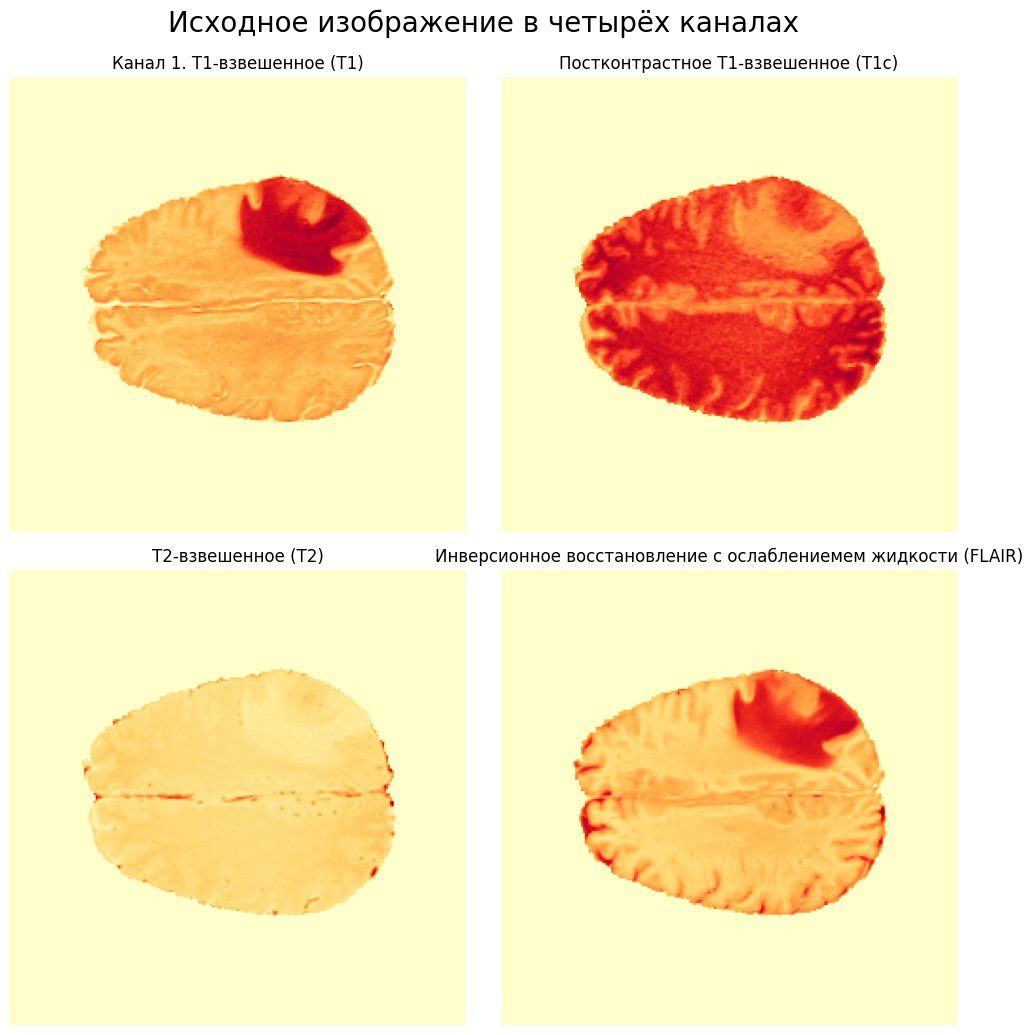

In [ ]:
image_show(image)

In [ ]:
def mask_show(mask, title='Маска опухоли в трёх каналах'):
    channel_names = ['Некротическое ядро (NEC)', 'Отёк (ED)', 'Контрастируемая часть (ET)']
    fig, axes = plt.subplots(1, 3, figsize=(10, 5))
    for index, ax in enumerate(axes):
        mask_sh = np.zeros((mask.shape[1], mask.shape[2], 3), dtype=np.uint8) # создаём массив с нулями 240х240х3
        mask_sh[..., index] = mask[index, :, :] * 255  # Транспонируем массив картинки, чтобы вывести на экран
        ax.imshow(mask_sh)
        ax.set_title(channel_names[index])
        plt.suptitle(title, fontsize=20, y=0.93)
    plt.tight_layout()
    plt.show()

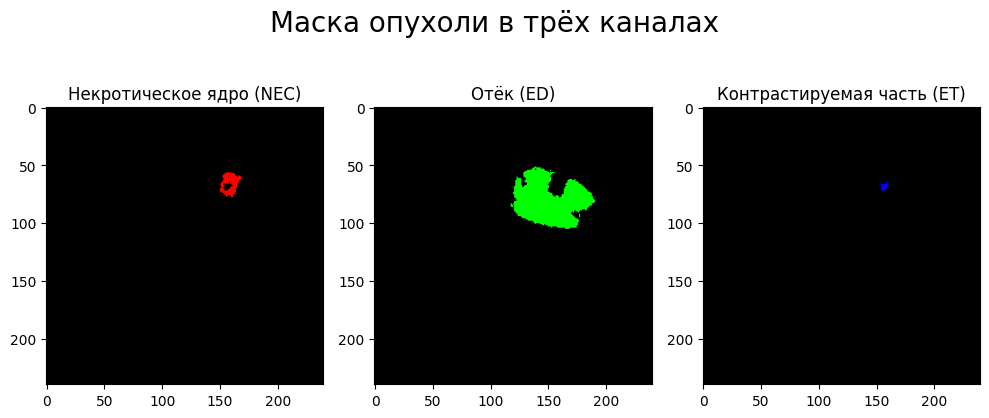

In [ ]:
# как видно из изображения, каждый канал маски представляет часть, которая не перекрывается другими двумя каналами,
#     то есть, все три изображения - это три части одной полной маски
mask_show(mask)

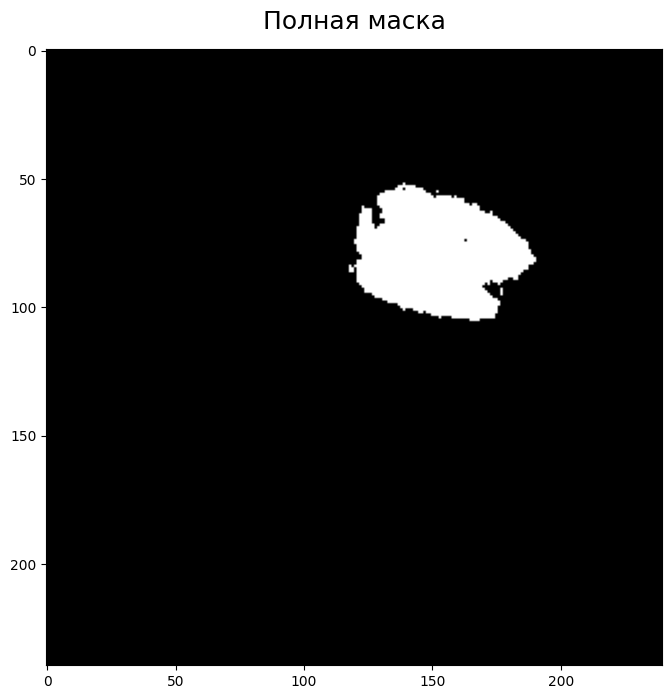

In [ ]:
# сложим три канала маски в один и посмотрим на одноканальное изображение полной маски
full_mask = mask[0, :, :] + mask[1, :, :] + mask[2, :, :]

plt.figure(figsize=(8, 8))
plt.imshow(full_mask, cmap='gray')
plt.title(label = 'Полная маска', fontsize=18, y=1.02)
plt.show()

In [ ]:
full_mask.shape

(240, 240)

In [ ]:
def image_mask_show(image, mask, title='Изображение МРТ мозга, включая все маски'):
    image_chan1 = image[0, :, :]  # Возьмём первый канал (из чётырёх) исходного изображения
    image_chan1_normalized = (image_chan1 - image_chan1.min()) / (image_chan1.max() - image_chan1.min()) #нормализуем все пиксели картинки

    image_show = np.stack([image_chan1_normalized] * 3, axis=-1)
    mask_show = np.stack([mask[0, :, :], mask[1, :, :], mask[2, :, :]], axis=-1)
    full_image = np.where(mask_show, mask_show, image_show)

    plt.figure(figsize=(8, 8))
    plt.imshow(full_image)
    plt.title(title, fontsize=18, y=1.02)
    plt.axis('off')
    plt.show()

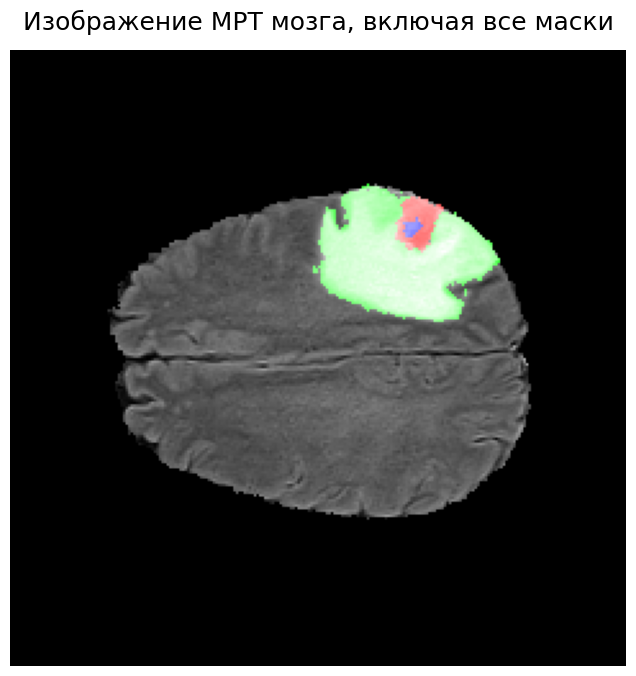

In [ ]:
image_mask_show(image, mask)

# ДОПОЛНИТЕЛЬНЫЕ **ДАННЫЕ**

**Продолжаем изучать данные и открываем первый csv-файл meta_data.csv**

In [ ]:
# из графика видим,ю чо имеем два класса: наличие и отсутствие опухоли. Классы неплохо балансированы.
meta_data_df = pd.read_csv('meta_data.csv')
meta_data_df.head()

slice_path  target  volume  slice
0  /content/data/volume_41_slice_0.h5       0      41      0
1  /content/data/volume_41_slice_1.h5       0      41      1
2  /content/data/volume_41_slice_2.h5       0      41      2
3  /content/data/volume_41_slice_3.h5       0      41      3
4  /content/data/volume_41_slice_4.h5       0      41      4

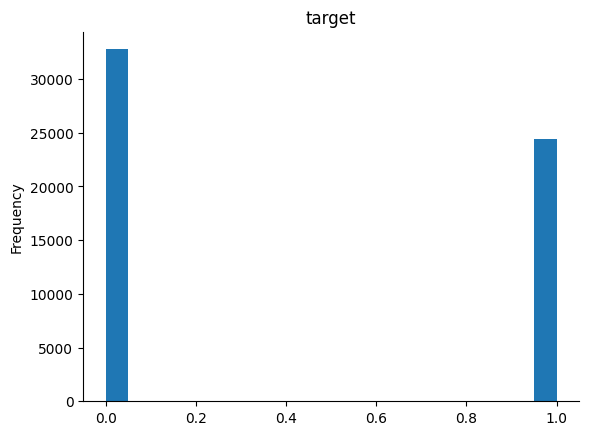

In [ ]:
# @title target

from matplotlib import pyplot as plt
meta_data_df['target'].plot(kind='hist', bins=20, title='target')
plt.gca().spines[['top', 'right',]].set_visible(False)

In [ ]:
meta_data_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 57195 entries, 0 to 57194
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   slice_path  57195 non-null  object
 1   target      57195 non-null  int64 
 2   volume      57195 non-null  int64 
 3   slice       57195 non-null  int64 
dtypes: int64(3), object(1)
memory usage: 1.7+ MB


In [ ]:
meta_data_df.describe()

target        volume         slice
count  57195.000000  57195.000000  57195.000000
mean       0.426995    185.000000     77.000000
std        0.494646    106.521665     44.744106
min        0.000000      1.000000      0.000000
25%        0.000000     93.000000     38.000000
50%        0.000000    185.000000     77.000000
75%        1.000000    277.000000    116.000000
max        1.000000    369.000000    154.000000

**Открываем второй csv-файл name_mapping.csv**

In [ ]:
name_mapping_df = pd.read_csv('name_mapping.csv')
name_mapping_df.head()

Grade BraTS_2017_subject_ID BraTS_2018_subject_ID TCGA_TCIA_subject_ID  \
0   HGG   Brats17_CBICA_AAB_1   Brats18_CBICA_AAB_1                  NaN   
1   HGG   Brats17_CBICA_AAG_1   Brats18_CBICA_AAG_1                  NaN   
2   HGG   Brats17_CBICA_AAL_1   Brats18_CBICA_AAL_1                  NaN   
3   HGG   Brats17_CBICA_AAP_1   Brats18_CBICA_AAP_1                  NaN   
4   HGG   Brats17_CBICA_ABB_1   Brats18_CBICA_ABB_1                  NaN   

  BraTS_2019_subject_ID BraTS_2020_subject_ID  
0   BraTS19_CBICA_AAB_1  BraTS20_Training_001  
1   BraTS19_CBICA_AAG_1  BraTS20_Training_002  
2   BraTS19_CBICA_AAL_1  BraTS20_Training_003  
3   BraTS19_CBICA_AAP_1  BraTS20_Training_004  
4   BraTS19_CBICA_ABB_1  BraTS20_Training_005

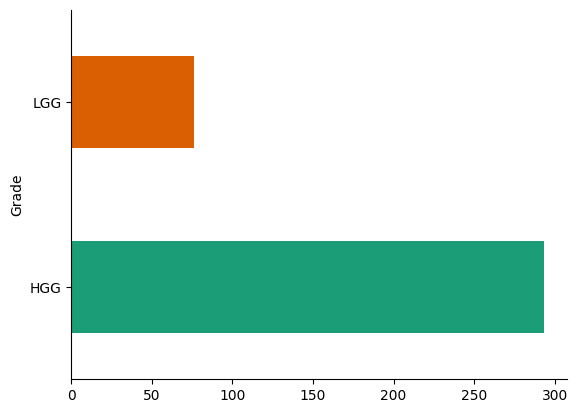

In [ ]:
# @title Grade

from matplotlib import pyplot as plt
import seaborn as sns
name_mapping_df.groupby('Grade').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)

In [ ]:
name_mapping_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 369 entries, 0 to 368
Data columns (total 6 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   Grade                  369 non-null    object
 1   BraTS_2017_subject_ID  285 non-null    object
 2   BraTS_2018_subject_ID  285 non-null    object
 3   TCGA_TCIA_subject_ID   167 non-null    object
 4   BraTS_2019_subject_ID  335 non-null    object
 5   BraTS_2020_subject_ID  369 non-null    object
dtypes: object(6)
memory usage: 17.4+ KB


**Открываем тетий csv-файл survival_info.**

In [ ]:
# В этом датафрейме видим возраст пациента, количество дней выживания и степень резекции опухоли (общую GTR и супратотальную STR)
survival_info_df = pd.read_csv('survival_info.csv')
survival_info_df.head()

Brats20ID     Age Survival_days Extent_of_Resection
0  BraTS20_Training_001  60.463           289                 GTR
1  BraTS20_Training_002  52.263           616                 GTR
2  BraTS20_Training_003  54.301           464                 GTR
3  BraTS20_Training_004  39.068           788                 GTR
4  BraTS20_Training_005  68.493           465                 GTR

<ipython-input-52-cb0ab9593fb2>:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(survival_info_df, x='Age', y='Extent_of_Resection', inner='stick', palette='Dark2')


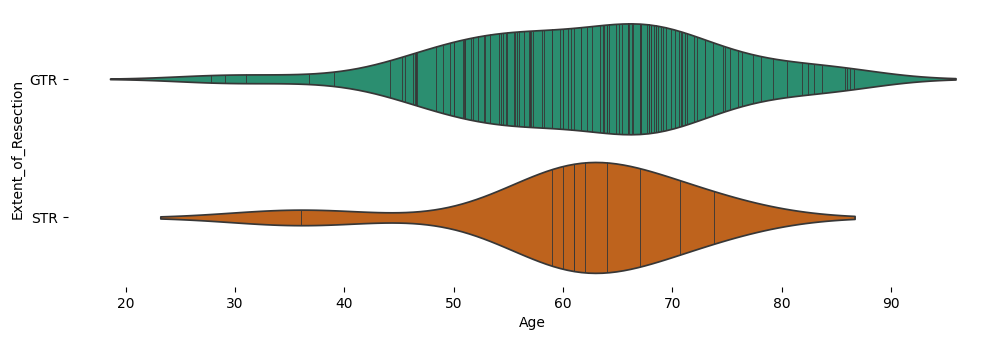

In [ ]:
# @title Extent_of_Resection vs Age

from matplotlib import pyplot as plt
import seaborn as sns
figsize = (12, 1.2 * len(survival_info_df['Extent_of_Resection'].unique()))
plt.figure(figsize=figsize)
sns.violinplot(survival_info_df, x='Age', y='Extent_of_Resection', inner='stick', palette='Dark2')
sns.despine(top=True, right=True, bottom=True, left=True)

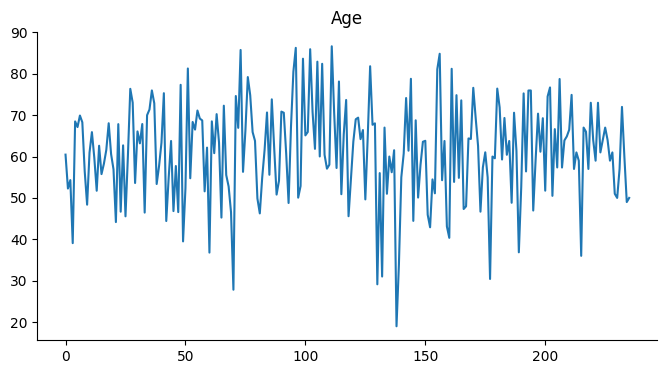

In [ ]:
# @title Age

from matplotlib import pyplot as plt
survival_info_df['Age'].plot(kind='line', figsize=(8, 4), title='Age')
plt.gca().spines[['top', 'right']].set_visible(False)

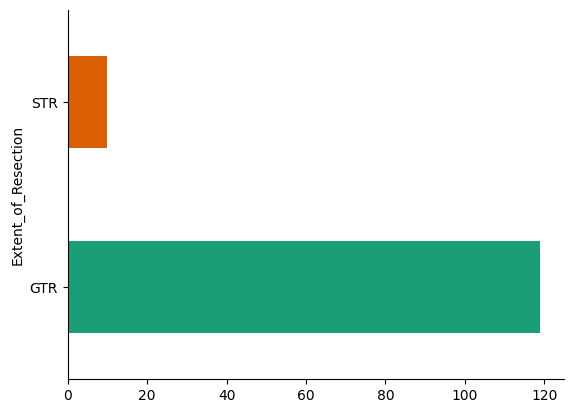

In [ ]:
# @title Extent_of_Resection

from matplotlib import pyplot as plt
import seaborn as sns
survival_info_df.groupby('Extent_of_Resection').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)

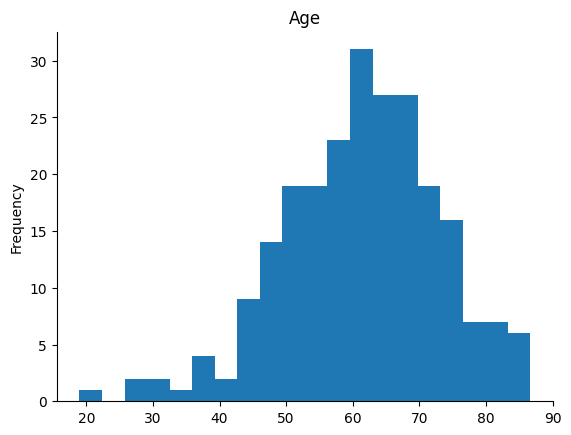

In [ ]:
# @title Age

from matplotlib import pyplot as plt
survival_info_df['Age'].plot(kind='hist', bins=20, title='Age')
plt.gca().spines[['top', 'right',]].set_visible(False)

In [ ]:
survival_info_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 236 entries, 0 to 235
Data columns (total 4 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Brats20ID            236 non-null    object 
 1   Age                  236 non-null    float64
 2   Survival_days        236 non-null    object 
 3   Extent_of_Resection  129 non-null    object 
dtypes: float64(1), object(3)
memory usage: 7.5+ KB


In [ ]:
survival_info_df.describe()

Age
count  236.000000
mean    61.223203
std     11.874114
min     18.975000
25%     54.244250
50%     61.471000
75%     69.200000
max     86.652000

# ИЗУЧЕНИЕ **ИЗОБРАЖЕНИЙ**

In [ ]:
# запишем пути всех файлов в один большой список и сразу посмотрим на небольшой диапазон элементов списка
h5_files_pathes = [os.path.join(directory, f) for f in os.listdir(directory) if f.endswith('.h5')]
h5_files_pathes[:10]

['/content/gdrive/MyDrive/DATA/GRADUATE_PROJECT/data/volume_94_slice_55.h5',
 '/content/gdrive/MyDrive/DATA/GRADUATE_PROJECT/data/volume_94_slice_37.h5',
 '/content/gdrive/MyDrive/DATA/GRADUATE_PROJECT/data/volume_94_slice_148.h5',
 '/content/gdrive/MyDrive/DATA/GRADUATE_PROJECT/data/volume_93_slice_82.h5',
 '/content/gdrive/MyDrive/DATA/GRADUATE_PROJECT/data/volume_94_slice_61.h5',
 '/content/gdrive/MyDrive/DATA/GRADUATE_PROJECT/data/volume_94_slice_25.h5',
 '/content/gdrive/MyDrive/DATA/GRADUATE_PROJECT/data/volume_93_slice_71.h5',
 '/content/gdrive/MyDrive/DATA/GRADUATE_PROJECT/data/volume_93_slice_89.h5',
 '/content/gdrive/MyDrive/DATA/GRADUATE_PROJECT/data/volume_93_slice_99.h5',
 '/content/gdrive/MyDrive/DATA/GRADUATE_PROJECT/data/volume_94_slice_104.h5']

In [ ]:
# посмотрим на другой диапазон элементов вышесозданного списка путей к файлам
h5_files_pathes[1000:1020]

['/content/gdrive/MyDrive/DATA/GRADUATE_PROJECT/data/volume_89_slice_76.h5',
 '/content/gdrive/MyDrive/DATA/GRADUATE_PROJECT/data/volume_89_slice_44.h5',
 '/content/gdrive/MyDrive/DATA/GRADUATE_PROJECT/data/volume_89_slice_133.h5',
 '/content/gdrive/MyDrive/DATA/GRADUATE_PROJECT/data/volume_89_slice_137.h5',
 '/content/gdrive/MyDrive/DATA/GRADUATE_PROJECT/data/volume_89_slice_47.h5',
 '/content/gdrive/MyDrive/DATA/GRADUATE_PROJECT/data/volume_89_slice_66.h5',
 '/content/gdrive/MyDrive/DATA/GRADUATE_PROJECT/data/volume_89_slice_29.h5',
 '/content/gdrive/MyDrive/DATA/GRADUATE_PROJECT/data/volume_89_slice_75.h5',
 '/content/gdrive/MyDrive/DATA/GRADUATE_PROJECT/data/volume_89_slice_120.h5',
 '/content/gdrive/MyDrive/DATA/GRADUATE_PROJECT/data/volume_89_slice_2.h5',
 '/content/gdrive/MyDrive/DATA/GRADUATE_PROJECT/data/volume_89_slice_116.h5',
 '/content/gdrive/MyDrive/DATA/GRADUATE_PROJECT/data/volume_89_slice_68.h5',
 '/content/gdrive/MyDrive/DATA/GRADUATE_PROJECT/data/volume_89_slice_49.h

In [ ]:
# Видя, что наименования файлов имеют некоторую упорядоченность, перед формированием датасета файлы лучше рандомно перемешать

In [ ]:
np.random.seed(1000)
np.random.shuffle(h5_files_pathes)

In [ ]:
# создадим границу для разделения трейновой части от тестовой и поделим файлы (в данном случае пути файлов) в соотношении 85% и 15% соответственно
terminator = int(0.85 * len(h5_files_pathes))
train_files_pathes = h5_files_pathes[:terminator]
test_files_pathes = h5_files_pathes[terminator:]

In [ ]:
import torch.nn.functional as F

In [ ]:
"""len_file_pathes = len(h5_files_pathes)
cross = 0 # введём переменную-счётчик пересекающихся изображений

for i in range(len_file_pathes): # проитерируемся по файлам
   with h5py.File(h5_files_pathes[i], 'r') as file:
      check_mask = file['mask'][()]  # возьмём из массива только маски
      check_mask = mask[:, :, 0] + mask[:, :, 1] + mask[:, :, 2] # сложим все три канала маски в один
      #if i%1000==0: print(i)
      if np.max(check_mask)>1: # делаем проверку на то, есть ли после сложения трёх каналов значения пикселей больше 1 (т.е. не перекрывают ли изображения на каналах друг друга)
         cross+=1 # включаем счётчик, если перекрывания были найдены

print(f"Количество межканально пересекающихся изображений каждой из масок: {cross}")"""

Количество межканально пересекающихся изображений каждой из масок: 0


In [ ]:
class Dataset_creator(Dataset):
    def __init__(self, paths, deterministic=False):
        self.paths = paths

        # чтобы всегда генерировать одни и те же тестовые изображения
        if deterministic:
          np.random.seed(1)
          np.random.shuffle(self.paths)

    def __getitem__(self, index):
      # загружаем исходные изображения и маски
      path = self.paths[index]
      with h5py.File(path, 'r') as file:
          image = file['image'][()]
          mask = file['mask'][()]

          image = image.transpose((2, 0, 1)) # Преобразуем формат каждого изображения из формата (H, W, C) в формат (C, H, W)
          mask = mask.transpose((2, 0, 1))  # Преобразуем формат каждой маски из формата (H, W, C) в формат (C, H, W)

          # Проитерируемся по каналам исходного изображения и нормализуем значение каждого пикселя, чтобы оно попадало в диапазон от 0 до 1
          for i in range(image.shape[0]):
             min_value = np.min(image[i])     # найдём минимальное значение пикселя по каналу
             image[i] = image[i] - min_value  # уменьшаем значение каждого пикселя по каналу на величину минимального значения, таким образом, получая в качестве минимального значения ноль
             max_value = np.max(image[i]) + 0.000001 # найдём максимальное значение пикселя по каналу, прибавим ничтожно малое число, чтобы в следующем действии избежать деления на ноль
             image[i] = image[i] / max_value    # масштабируем значение каждого пикселя так, чтобы макимум был равен единице

          # Проитерируемся по каналам маски и преобразуем значение каждого отличного от нуля пикселя в каналах 1 и 2 в значения 2 и 3 (для канала 1 - 2, для канала 2 - 3)
          #    для 0-го канала значения, равные 1 преобразовывать не нужно, так как они и так равны 1
          #    значения пикселей, относящиеся к фону маски, остаются равными 0
          #    пустые маски (при отсутствии опухоли на снимке) также остаются неизменными со значениями пикселей, равными нулю
          for i in range(mask.shape[0]):
            mask_chan_1 = mask[1, :, :]
            mask_chan_2 = mask[2, :, :]
            if (i==1)&(np.max(mask_chan_1) > 0):
              mask_chan_1[mask_chan_1 > 0] = 2
            if (i==2)&(np.max(mask_chan_2)>0):
              mask_chan_2[mask_chan_2 > 0] = 3

          mask = mask[0, :, :] + mask_chan_1 + mask_chan_2 # сложим все три канала маски в один

          # преобразуем исходное изображение и маску в торч-тензор
          image = torch.tensor(image, dtype=torch.float32)
          mask = torch.tensor(mask, dtype=torch.float32)


      return image, mask

    def __len__(self):
        return len(self.paths)

In [ ]:
# зададим параметры и гиперпараметры

class CFG:
    img_size = (240, 240)
    bs = 32
    lr = 0.001
    epochs = 15
    device = 'cuda' if torch.cuda.is_available() else 'cpu'
    batches_per_epoch = 100
    lr_decay_factor = 0.85
    in_channels  = 4   # 4 канала исходного изображения
    out_channels = 4   # 4 класса (0 - фон, 1 - первый канал маски 0, 2 - второй канал маски, 3 - третий канал маски)
    n_filters = 32 # уменьшено в два раза от стандарной UNet
    activation   = nn.ReLU()

In [ ]:
# создаём трейновый и тестовый датасеты
train_dataset = Dataset_creator(train_files_pathes)
test_dataset = Dataset_creator(test_files_pathes)

In [ ]:
# создаём трейновый и тестовый даталоадеры с батчем 5 (трейн - перемешиваем, тест - нет)
train_dataloader = DataLoader(train_dataset, batch_size = CFG.bs, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size = CFG.bs, shuffle=False)

In [ ]:
# На всякий случай убедимся, что даталоадер правильно сформировал батчи и размерность правильная
for images, masks in train_dataloader:
    print('Размерность батча в обучающем датасете.')
    print('Исходное изображение:', images.shape, 'Маска:', masks.shape)
    break

print(' ')

for images, masks in test_dataloader:
    print('Размерность батча в тестовом датасете.')
    print('Исходное изображение:', images.shape, 'Маска:', masks.shape)
    break

Размерность батча в обучающем датасете.
Исходное изображение: torch.Size([32, 4, 240, 240]) Маска: torch.Size([32, 240, 240])
 
Размерность батча в тестовом датасете.
Исходное изображение: torch.Size([32, 4, 240, 240]) Маска: torch.Size([32, 240, 240])


In [ ]:
# формируем энкодер и декодер (каждый из них имеет по два свёрточных слоя)

class Encoder(nn.Module):
    def __init__(self, in_channels, out_channels, activation):
        super().__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(in_channels,  out_channels, kernel_size=5, stride=1, padding=1),
            nn.BatchNorm2d(num_features=out_channels),
            activation,
            nn.Conv2d(out_channels, out_channels, kernel_size=1, stride=1, padding=1),
            nn.BatchNorm2d(num_features=out_channels),
            activation
        )
    def forward(self, x):
        return self.encoder(x)

class Decoder(nn.Module):
    def __init__(self, in_channels, out_channels, activation=nn.ReLU()):
        super().__init__()
        self.decoder = nn.Sequential(
            nn.Conv2d(in_channels,  in_channels//2, kernel_size=5, stride=1, padding=1),
            nn.BatchNorm2d(num_features=in_channels//2),
            activation,
            nn.Conv2d(in_channels//2, out_channels, kernel_size=1, stride=1, padding=1),
            nn.BatchNorm2d(num_features=out_channels),
            activation
        )
    def forward(self, x):
        return self.decoder(x)

In [ ]:
# создадим блоки для UNET глубиной 5
class UNet(nn.Module):
    def __init__(self):
        super().__init__()

        # Config
        in_channels  = CFG.in_channels
        out_channels = CFG.out_channels
        n_filters    = CFG.n_filters
        activation   = nn.ReLU()

        # нисходящий и восходящий преобразующие методы
        self.down_transform  = nn.MaxPool2d((2,2), stride=2)
        self.up_transform = nn.UpsamplingBilinear2d(scale_factor=2)

        # Encoder
        self.enc_block_1 = Encoder(in_channels, n_filters, activation)
        self.enc_block_2 = Encoder(n_filters, 2*n_filters, activation)
        self.enc_block_3 = Encoder(2*n_filters, 4*n_filters, activation)
        self.enc_block_4 = Encoder(4*n_filters, 8*n_filters, activation)

        # Мiddle
        self.middle  = nn.Sequential(
            nn.Conv2d( 8*n_filters, 16*n_filters, kernel_size=3, stride=1, padding=1),
            activation,
            nn.Conv2d(16*n_filters,  8*n_filters, kernel_size=3, stride=1, padding=1),
            activation
        )

        # Decoder
        self.dec_block_4 = Decoder(16*n_filters, 4*n_filters, activation)
        self.dec_block_3 = Decoder( 8*n_filters, 2*n_filters, activation)
        self.dec_block_2 = Decoder( 4*n_filters, n_filters, activation)
        self.dec_block_1 = Decoder( 2*n_filters, n_filters, activation)

        # Output
        self.output = nn.Conv2d(n_filters,  out_channels, kernel_size=1, stride=1, padding=0)


    def forward(self, x):
        # Contraction
        contraction_1 = self.enc_block_1(x)
        x      = self.down_transform(contraction_1)
        contraction_2 = self.enc_block_2(x)
        x      = self.down_transform(contraction_2)
        contraction_3 = self.enc_block_3(x)
        x      = self.down_transform(contraction_3)
        contraction_4 = self.enc_block_4(x)
        x      = self.down_transform(contraction_4)

        # Middle
        middle = self.middle(x)

        # Expantion
        expantion_4 = self.up_transform(middle)
        x      = torch.cat((expantion_4, contraction_4), axis=1) # конкатенация
        x      = self.dec_block_4(x)
        expantion_3 = self.up_transform(x)
        x      = torch.cat((expantion_3, contraction_3), axis=1) # конкатенация
        x      = self.dec_block_3(x)
        expantion_2 = self.up_transform(x)
        x      = torch.cat((expantion_2, contraction_2), axis=1) # конкатенация
        x      = self.dec_block_2(x)
        expantion_1 = self.up_transform(x)
        x      = torch.cat((expantion_1, contraction_1), axis=1) # конкатенация
        x      = self.dec_block_1(x)
        out = self.output(x)
        return out

In [ ]:
# функция для подсчёта dice score - сюда попадает батч целиком
def dice_coef(y_true, y_pred):
   y_true = y_true.cpu()
   y_pred = y_pred.cpu()

  # вытягиваем маски в плоский вектор и конветируем в массив np.array
   y_true_flat = y_true.flatten().numpy()
   y_pred_flat = y_pred.flatten().numpy()

   # инициализируем переменные отдельно для каждого ненулевого класса вектора исходных масок
   y_true_flat_1 = y_true_flat.copy()
   y_true_flat_1[y_true_flat_1 > 1] = 0   # все значения пикселей больше 1 преобразуем в нули

   y_true_flat_2 = y_true_flat.copy()
   y_true_flat_2[y_true_flat_2 != 2] = 0  # все значения пикселей не равные 2 преобразуем в нули
   y_true_flat_2[y_true_flat_2 == 2] = 1  # все значения пикселей равные 2 преобразуем в единицы

   y_true_flat_3 = y_true_flat.copy()
   y_true_flat_3[y_true_flat_3 < 3] = 0   # все значения пикселей меньше 3 преобразуем в нули
   y_true_flat_3[y_true_flat_3 == 3] = 1  # все значения пикселей равные 3 преобразуем в единицы

   # инициализируем переменные отдельно для каждого ненулевого класса вектора предсказанных масок
   y_pred_flat_1 = y_pred_flat.copy()
   y_pred_flat_1[y_pred_flat_1 > 1] = 0   # все значения пикселей больше 1 преобразуем в нули

   y_pred_flat_2 = y_pred_flat.copy()
   y_pred_flat_2[y_pred_flat_2 != 2] = 0   # все значения пикселей не равные 2 преобразуем в нули
   y_pred_flat_2[y_pred_flat_2 == 2] = 1  # все значения пикселей равные 2 преобразуем в единицы

   y_pred_flat_3 = y_pred_flat.copy()
   y_pred_flat_3[y_pred_flat_3 < 3] = 0  # все значения пикселей меньше 3 преобразуем в нули
   y_pred_flat_3[y_pred_flat_3 == 3] = 1 # все значения пикселей равные 3 преобразуем в единицы


   intersection_1 = np.sum(y_true_flat_1 * y_pred_flat_1) # считаем перекрывающиеся пиксели класса 1
   intersection_2 = np.sum(y_true_flat_2 * y_pred_flat_2) # считаем перекрывающиеся пиксели класса 2
   intersection_3 = np.sum(y_true_flat_3 * y_pred_flat_3) # считаем перекрывающиеся пиксели класса 3

   smooth = 0.0001 # добавим небольшой сдвиг, чтобы в следующем действии избежать деления на ноль

   dice_1 = (2. * intersection_1 + smooth) / (np.sum(y_true_flat_1) + np.sum(y_pred_flat_1) + smooth)  # dice для класса 1
   dice_2 = (2. * intersection_2 + smooth) / (np.sum(y_true_flat_2) + np.sum(y_pred_flat_2) + smooth)  # dice для класса 2
   dice_3 = (2. * intersection_3 + smooth) / (np.sum(y_true_flat_3) + np.sum(y_pred_flat_3) + smooth)  # dice для класса 3


   return dice_1, dice_2, dice_3

In [ ]:
model = UNet()

In [ ]:
model

UNet(
  (down_transform): MaxPool2d(kernel_size=(2, 2), stride=2, padding=0, dilation=1, ceil_mode=False)
  (up_transform): UpsamplingBilinear2d(scale_factor=2.0, mode='bilinear')
  (enc_block_1): Encoder(
    (encoder): Sequential(
      (0): Conv2d(4, 32, kernel_size=(5, 5), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
      (3): Conv2d(32, 32, kernel_size=(1, 1), stride=(1, 1), padding=(1, 1))
      (4): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): ReLU()
    )
  )
  (enc_block_2): Encoder(
    (encoder): Sequential(
      (0): Conv2d(32, 64, kernel_size=(5, 5), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
      (3): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), padding=(1, 1))
      (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track

In [ ]:
# посмотрим на число параметров в модели
def parameters(model):
    total_params = sum(p.numel() for p in model.parameters())
    print(f'Количество параметров в модели: {total_params:,}\n')

parameters(model)

Количество параметров в модели: 7,926,756



In [ ]:
# функция для обучения модели
def train_model(model, train_dataloader, test_dataloader, CFG, dice_coef, checkpoint):
    device = CFG.device
    out_channels = CFG.out_channels
    n_epochs = CFG.epochs
    learning_rate = CFG.lr
    batches_per_epoch = CFG.batches_per_epoch
    lr_decay_factor = CFG.lr_decay_factor


    model.to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    #optimizer.load_state_dict(checkpoint['optimizer_state_dict']) применять только при дообучении
    loss_fn = nn.CrossEntropyLoss()

    train_losses = []
    val_losses = []
    lr_epoch = []
    train_dice_scores_NEC = []
    train_dice_scores_ED = []
    train_dice_scores_ET = []
    val_dice_scores_NEC = []
    val_dice_scores_ED = []
    val_dice_scores_ET = []

    """
    использовать только для дообучения модели
    train_losses = checkpoint['train_losses']
    val_losses = checkpoint['val_losses']
    train_dice_scores_NEC = checkpoint['train_dice_scores_NEC']
    train_dice_scores_ED = checkpoint['train_dice_scores_ED']
    train_dice_scores_ET = checkpoint['train_dice_scores_ET']
    val_dice_scores_NEC = checkpoint['val_dice_scores_NEC']
    val_dice_scores_ED = checkpoint['val_dice_scores_ED']
    val_dice_scores_ET = checkpoint['val_dice_scores_ET']
    lr_epoch = checkpoint['lr_epoch']"""

    print('ОБУЧЕНИЕ...')
    for epoch in range(1, n_epochs + 1):
        # вычисление снижение скорости обучения (lr_decay_factor установлен равным 0,85)
        current_lr = learning_rate * (lr_decay_factor ** (epoch - 1))
        for param_group in optimizer.param_groups:
            param_group['lr'] = current_lr

        # шаг обучения (итерируемся по батчам)
        model.train()
        train_loss = 0
        train_dice_1 = 0
        train_dice_2 = 0
        train_dice_3 = 0
        for train_batch_idx, (train_inputs, train_targets) in enumerate(train_dataloader, start=1):

            train_inputs = train_inputs.to(device)
            train_targets = train_targets.to(device)
            train_preds = model(train_inputs)

            train_batch_loss = loss_fn(train_preds, train_targets.long()) # считаем лосс
            train_loss += train_batch_loss.item()

            optimizer.zero_grad()
            train_batch_loss.backward()
            optimizer.step()

            train_preds = torch.argmax(train_preds, dim=1) # применяем аргмакс, и сразу преобразовываем 4 канала вероятностей для каждого пикселя в 1 канал с наиболее вероятными номерами его классов
            #print(f"Размерность исходной маски маски: {train_targets.shape}, Размерность предсказанной маски: {train_preds.shape}\n")

            train_batch_dice_1 = dice_coef(train_targets, train_preds)[0]   # считаем dice по всем маскам в батче по классу 1
            train_batch_dice_2 = dice_coef(train_targets, train_preds)[1]   # считаем dice по всем маскам в батче по классу 2
            train_batch_dice_3 = dice_coef(train_targets, train_preds)[2]   # считаем dice по всем маскам в батче по классу 3

            train_dice_1 += train_batch_dice_1   # складываем dice по всем батчам по классу 1
            train_dice_2 += train_batch_dice_2   # складываем dice по всем батчам по классу 2
            train_dice_3 += train_batch_dice_3   # складываем dice по всем батчам по классу 3

            if train_batch_idx==50:  # на 50 батче выводим метрики качества
               print(f"\rTrain batch: {train_batch_idx}/{batches_per_epoch}, Avg batch loss: {train_loss/train_batch_idx:.6f}\n")
               print(f"\rAvg batch dice NEC: {(train_dice_1/train_batch_idx):.6f}, Avg batch dice ED: {(train_dice_2/train_batch_idx):.6f}, Avg batch dice ET: {(train_dice_3/train_batch_idx):.6f}\n")
            elif train_batch_idx%20==0: print(f"\rTrain batch: {train_batch_idx}/{batches_per_epoch}")

            if train_batch_idx >= batches_per_epoch:
                break
        train_losses.append(train_loss) # собираем все лоссы за эпоху

        train_dice_scores_NEC.append(train_dice_1/CFG.batches_per_epoch) # собираем все дайсы за эпоху по классу 1
        train_dice_scores_ED.append(train_dice_2/CFG.batches_per_epoch) # собираем все дайсы за эпоху по классу 2
        train_dice_scores_ET.append(train_dice_3/CFG.batches_per_epoch) # собираем все дайсы за эпоху по классу 3


        # шаг валидации
        model.eval()
        val_loss = 0
        val_dice_1 = 0
        val_dice_2 = 0
        val_dice_3 = 0
        with torch.no_grad():
            for val_batch_idx, (val_inputs, val_targets) in enumerate(test_dataloader, start=1):

                val_inputs = val_inputs.to(device)
                val_targets = val_targets.to(device)
                val_preds = model(val_inputs)

                val_batch_loss = loss_fn(val_preds, val_targets.long())
                val_loss += val_batch_loss.item()

                val_preds = torch.argmax(val_preds, dim=1)   # применяем аргмакс, чтобы получить наиболее вероятные номера классов для каждого пикселя

                val_batch_dice_1 = dice_coef(val_targets, val_preds)[0]   # считаем dice по всем маскам в батче по классу 1
                val_batch_dice_2 = dice_coef(val_targets, val_preds)[1]   # считаем dice по всем маскам в батче по классу 2
                val_batch_dice_3 = dice_coef(val_targets, val_preds)[2]   # считаем dice по всем маскам в батче по классу 3

                val_dice_1 += val_batch_dice_1   # складываем dice по всем батчам по классу 1
                val_dice_2 += val_batch_dice_2   # складываем dice по всем батчам по классу 2
                val_dice_3 += val_batch_dice_3   # складываем dice по всем батчам по классу 3

                if val_batch_idx==50:  # на 50 батче выводим метрики качества
                   print(f"\rVal batch: {val_batch_idx}/{batches_per_epoch}, Avg batch loss: {val_loss/val_batch_idx:.6f}\n")
                   print(f"\rAvg batch dice NEC: {(val_dice_1/val_batch_idx):.6f}, Avg batch dice ED: {(val_dice_2/val_batch_idx):.6f}, Avg batch dice ET: {(val_dice_3/val_batch_idx):.6f}\n")
                elif val_batch_idx%20==0: print(f"\rVal batch: {val_batch_idx}/{batches_per_epoch}")

                if val_batch_idx >= batches_per_epoch:
                    break
        val_losses.append(val_loss)   # собираем все лоссы за эпоху

        lr_epoch.append(current_lr)

        val_dice_scores_NEC.append(val_dice_1/CFG.batches_per_epoch) # собираем все дайсы за эпоху по классу 1
        val_dice_scores_ED.append(val_dice_2/CFG.batches_per_epoch) # собираем все дайсы за эпоху по классу 2
        val_dice_scores_ET.append(val_dice_3/CFG.batches_per_epoch) # собираем все дайсы за эпоху по классу 3


        print(f"Epoch: {epoch}, Train loss: {train_loss:.6f}, Val loss: {val_loss:.6f}, lr {current_lr:.6f}\n")
        print(f"Epoch: {epoch}, Train dice score NEC: {train_dice_1/CFG.batches_per_epoch:.6f}, Val dice score NEC: {(val_dice_1/CFG.batches_per_epoch):.6f}\n")
        print(f"Epoch: {epoch}, Train dice score ED: {train_dice_2/CFG.batches_per_epoch:.6f}, Val dice score ED: {(val_dice_2/CFG.batches_per_epoch):.6f}\n")
        print(f"Epoch: {epoch}, Train dice score ET: {train_dice_3/CFG.batches_per_epoch:.6f}, Val dice score ET: {(val_dice_3/CFG.batches_per_epoch):.6f}\n")
        print()

        torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'train_losses': train_losses,
            'val_losses': val_losses,
            'lr_epoch': lr_epoch,
            'train_dice_scores_NEC': train_dice_scores_NEC,
            'train_dice_scores_ED': train_dice_scores_ED,
            'train_dice_scores_ET': train_dice_scores_ET,
            'val_dice_scores_NEC': val_dice_scores_NEC,
            'val_dice_scores_ED': val_dice_scores_ED,
            'val_dice_scores_ET': val_dice_scores_ET
            },
            f'/content/gdrive/MyDrive/DATA/GRADUATE_PROJECT/checkpoints/model_{epoch}_{current_lr}_{CFG.out_channels}.pth')

    print('ОБУЧЕНИЕ ЗАВЕРШЕНО')
    return train_losses, val_losses, train_dice_scores_NEC, train_dice_scores_ED, train_dice_scores_ET, val_dice_scores_NEC, val_dice_scores_ED, val_dice_scores_ET, lr_epoch

In [ ]:
checkpoint = torch.load('/content/gdrive/MyDrive/DATA/GRADUATE_PROJECT/checkpoints/model_15_0.00010276966953088433_4.pth', map_location=torch.device(CFG.device))

In [ ]:
model.load_state_dict(checkpoint['model_state_dict'])

<All keys matched successfully>

In [ ]:
train_losses, val_losses, train_dice_scores_NEC, train_dice_scores_ED, train_dice_scores_ET, val_dice_scores_NEC, val_dice_scores_ED, val_dice_scores_ET, lr_epoch = train_model(model, train_dataloader, test_dataloader, CFG, dice_coef)

ОБУЧЕНИЕ...


/usr/local/lib/python3.10/dist-packages/torch/autograd/graph.py:744: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:919.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


Train batch: 20/100
Train batch: 40/100
Train batch: 50/100, Avg batch loss: 0.918889

Avg batch dice NEC: 0.131726, Avg batch dice ED: 0.149973, Avg batch dice ET: 0.020503

Train batch: 60/100
Train batch: 80/100
Train batch: 100/100
Val batch: 20/100
Val batch: 40/100
Val batch: 50/100, Avg batch loss: 0.191813

Avg batch dice NEC: 0.342851, Avg batch dice ED: 0.000134, Avg batch dice ET: 0.142360

Val batch: 60/100
Val batch: 80/100
Val batch: 100/100
Epoch: 1, Train loss: 61.784284, Val loss: 19.237343, lr 0.001000

Epoch: 1, Train dice score NEC: 0.214034, Val dice score NEC: 0.332432

Epoch: 1, Train dice score ED: 0.102158, Val dice score ED: 0.000088

Epoch: 1, Train dice score ET: 0.057487, Val dice score ET: 0.122932


Train batch: 20/100
Train batch: 40/100
Train batch: 50/100, Avg batch loss: 0.135596

Avg batch dice NEC: 0.212002, Avg batch dice ED: 0.289902, Avg batch dice ET: 0.076651

Train batch: 60/100
Train batch: 80/100
Train batch: 100/100
Val batch: 20/100
Val ba

In [ ]:
train_losses, val_losses, train_dice_scores_NEC, train_dice_scores_ED, train_dice_scores_ET, val_dice_scores_NEC, val_dice_scores_ED, val_dice_scores_ET, lr_epoch = train_model(model, train_dataloader, test_dataloader, CFG, dice_coef, checkpoint)

ОБУЧЕНИЕ...
Train batch: 20/100
Train batch: 40/100
Train batch: 50/100, Avg batch loss: 0.017414

Avg batch dice NEC: 0.521872, Avg batch dice ED: 0.725355, Avg batch dice ET: 0.682127

Train batch: 60/100
Train batch: 80/100
Train batch: 100/100
Val batch: 20/100
Val batch: 40/100
Val batch: 50/100, Avg batch loss: 0.016488

Avg batch dice NEC: 0.546017, Avg batch dice ED: 0.724988, Avg batch dice ET: 0.703514

Val batch: 60/100
Val batch: 80/100
Val batch: 100/100
Epoch: 11, Train loss: 1.700846, Val loss: 1.660805, lr 0.000197

Epoch: 11, Train dice score NEC: 0.531313, Val dice score NEC: 0.555814

Epoch: 11, Train dice score ED: 0.728626, Val dice score ED: 0.719589

Epoch: 11, Train dice score ET: 0.691550, Val dice score ET: 0.698415


Train batch: 20/100
Train batch: 40/100
Train batch: 50/100, Avg batch loss: 0.016629

Avg batch dice NEC: 0.540098, Avg batch dice ED: 0.718498, Avg batch dice ET: 0.693720

Train batch: 60/100
Train batch: 80/100
Train batch: 100/100
Val batch:

**ВЫВЕДЕМ ГРАФИК LOSS**

In [ ]:
"""train_losses = checkpoint['train_losses']
val_losses = checkpoint['val_losses']
train_dice_scores_NEC = checkpoint['train_dice_scores_NEC']
train_dice_scores_ED = checkpoint['train_dice_scores_ED']
train_dice_scores_ET = checkpoint['train_dice_scores_ET']
val_dice_scores_NEC = checkpoint['val_dice_scores_NEC']
val_dice_scores_ED = checkpoint['val_dice_scores_ED']
val_dice_scores_ET = checkpoint['val_dice_scores_ET']
lr_epoch = checkpoint['lr_epoch']"""

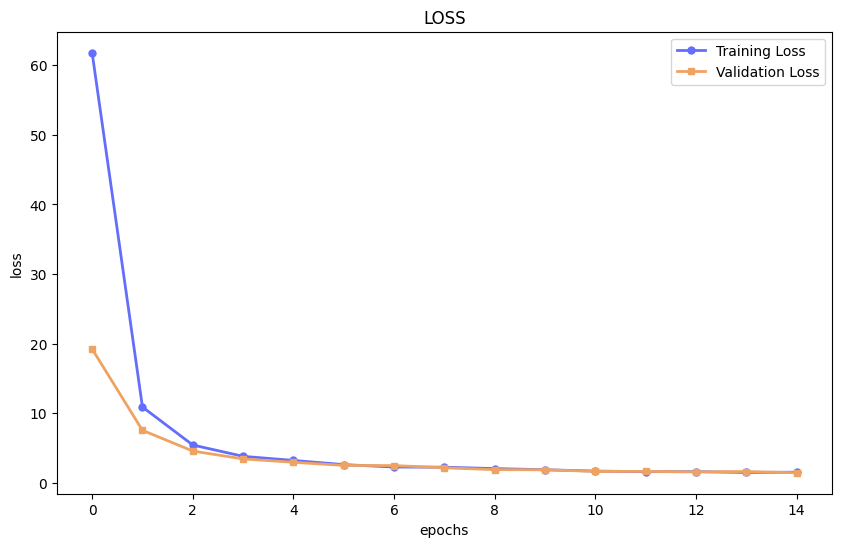

In [ ]:
fig, axis = plt.subplots(1, 1, figsize=(10, 6))

axis.plot(train_losses, label='Training Loss', color='#636EFA', marker='o', linestyle='-', linewidth=2, markersize=5)
axis.plot(val_losses, label='Validation Loss',color='#EFA363', marker='s', linestyle='-', linewidth=2, markersize=5)
plt.legend()
axis.set(xlabel='epochs', ylabel='loss', title = 'LOSS')
plt.show()

**ВЫВЕДЕМ ГРАФИКИ DICE SCORE**

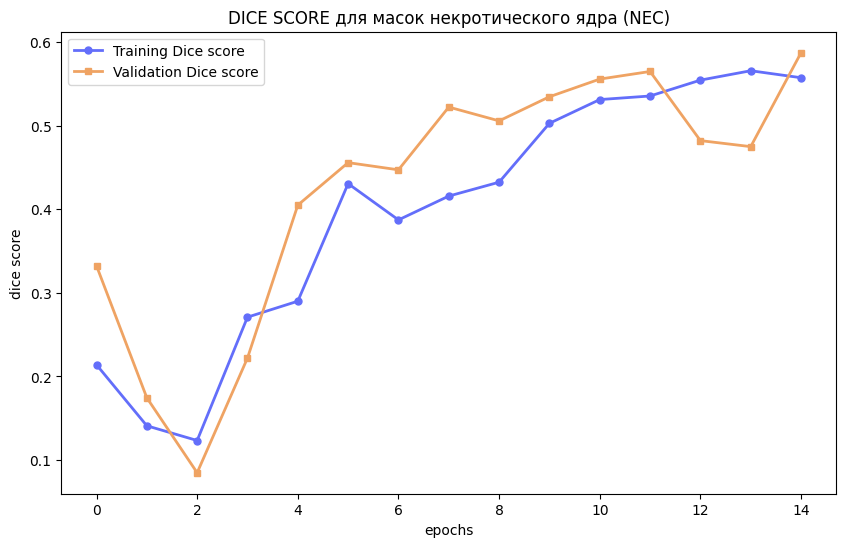

In [ ]:
fig, axis = plt.subplots(1, 1, figsize=(10, 6))

axis.plot(train_dice_scores_NEC, label='Training Dice score', color='#636EFA', marker='o', linestyle='-', linewidth=2, markersize=5)
axis.plot(val_dice_scores_NEC, label='Validation Dice score',color='#EFA363', marker='s', linestyle='-', linewidth=2, markersize=5)

plt.legend()
axis.set(xlabel='epochs', ylabel='diсe score', title = 'DICE SCORE для масок некротического ядра (NEC)')
plt.show()

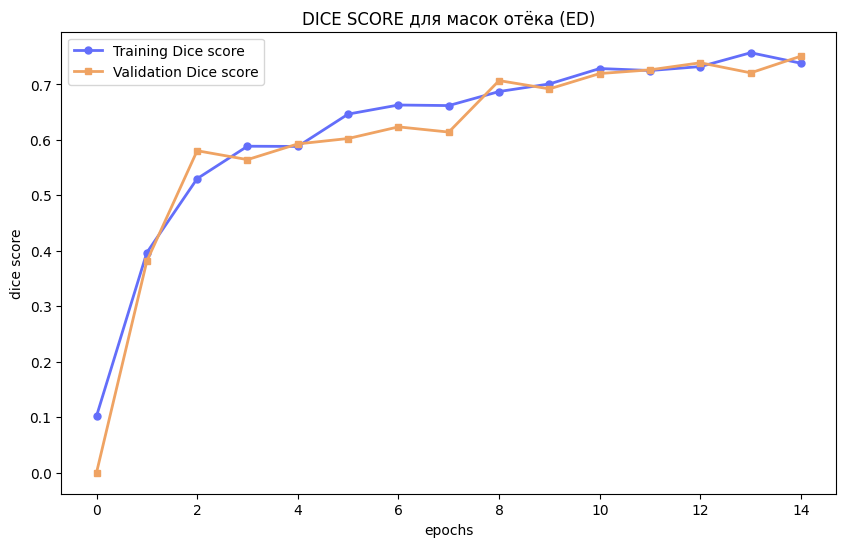

In [ ]:
fig, axis = plt.subplots(1, 1, figsize=(10, 6))

axis.plot(train_dice_scores_ED, label='Training Dice score', color='#636EFA', marker='o', linestyle='-', linewidth=2, markersize=5)
axis.plot(val_dice_scores_ED, label='Validation Dice score',color='#EFA363', marker='s', linestyle='-', linewidth=2, markersize=5)

plt.legend()
axis.set(xlabel='epochs', ylabel='diсe score', title = 'DICE SCORE для масок отёка (ED)')
plt.show()

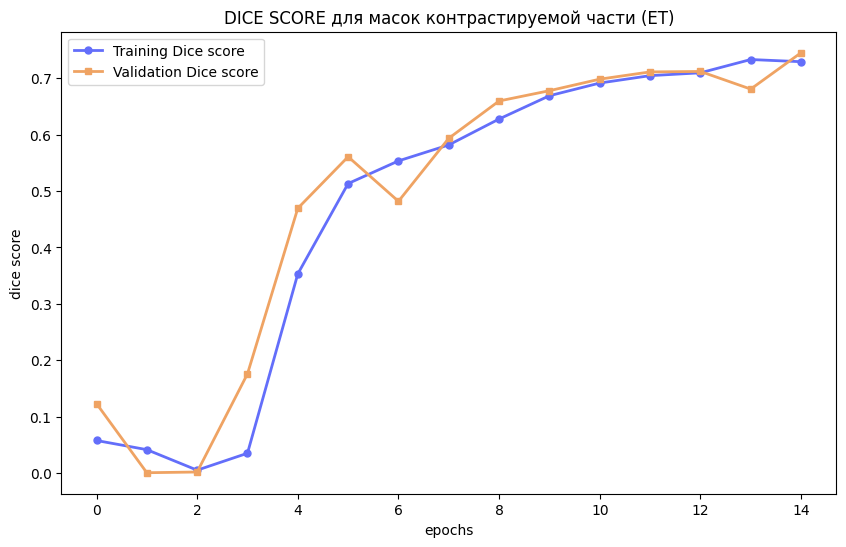

In [ ]:
fig, axis = plt.subplots(1, 1, figsize=(10, 6))

axis.plot(train_dice_scores_ET, label='Training Dice score', color='#636EFA', marker='o', linestyle='-', linewidth=2, markersize=5)
axis.plot(val_dice_scores_ET, label='Validation Dice score',color='#EFA363', marker='s', linestyle='-', linewidth=2, markersize=5)

plt.legend()
axis.set(xlabel='epochs', ylabel='diсe score', title = 'DICE SCORE для масок контрастируемой части (ET)')
plt.show()

In [ ]:
# Теперь необходимо сделать тест, чтобы посмотреть на полученное качество
# Найдём все срезы для одного пациента

In [ ]:
# Для этого создадим список из путей файлов, которые содержат ID пациента, например, возьмём ID = 200

patient_file_pathes = []
i = 0
r = re.compile('.*'.join(re.escape('volume_100_slice_')))
for pat_path in h5_files_pathes:
  if r.search(pat_path):
    patient_file_pathes.append(pat_path)
    i+=1
#patient_file_pathes
print('Всего найдено ', i, ' файлов пациента с id 100')

Всего найдено  155  файлов пациента с id 100


In [ ]:
# создадим датасет из файлов по пациенту
patient_dataset = Dataset_creator(patient_file_pathes)

In [ ]:
# создадим итератор для одного изображения для прохода по датасету пациента
test_image_iterator = iter(DataLoader(patient_dataset, batch_size=1, shuffle=False))

In [ ]:
def test_mask_show(image, mask, model, CFG):
    #image, mask = image.to(CFG.device), mask.to(CFG.device)

    fig, (axis1, axis2) = plt.subplots(1, 2, figsize=(10, 20))

    mask = mask.detach().cpu().numpy().squeeze(0)
    pred = torch.argmax(model(image), dim=1).detach().cpu().numpy().squeeze(0)

    mask_sh = np.zeros((mask.shape[0], mask.shape[1]), dtype=np.uint8) # создаём массив с нулями 240х240
    mask_sh[...] = mask[ :, :] /(CFG.out_channels-1)* 255  # Транспонируем массив картинки, чтобы вывести на экран
    axis1.imshow(mask)
    axis1.set_title('Исходная маска')

    pred_sh = np.zeros((pred.shape[0], pred.shape[1]), dtype=np.uint8) # создаём массив с нулями 240х240
    pred_sh[...] = pred_sh[ :, :]/(CFG.out_channels-1) * 255  # Транспонируем массив картинки, чтобы вывести на экран
    axis2.imshow(pred)
    axis2.set_title('Предсказанная маска')

    plt.tight_layout()
    plt.show()

In [ ]:
# получим с помощью созданного итератора изображение и исходную маску из датасета пациента
input, target = next(test_image_iterator)

ПОСМОТРИМ НА МАСКИ ДЛЯ ПАЦИЕНТА С ID 200

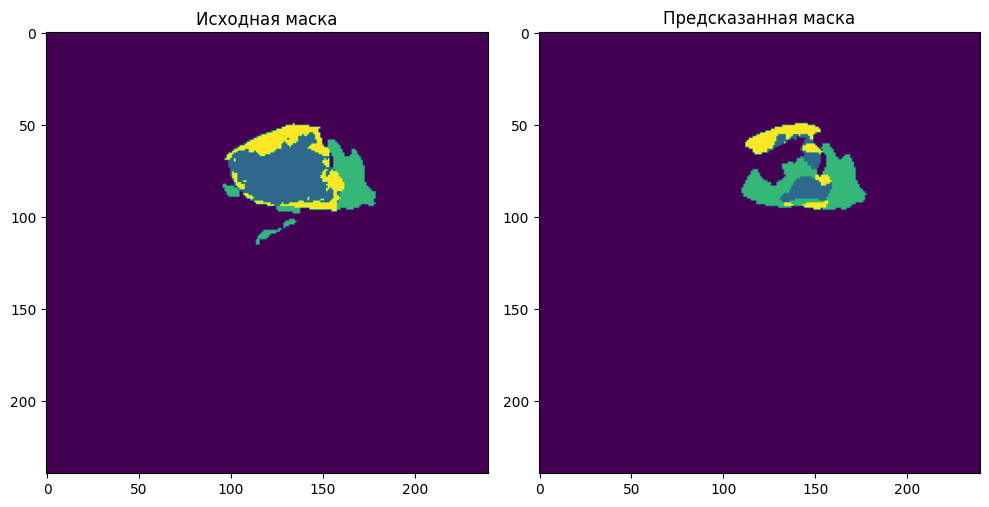

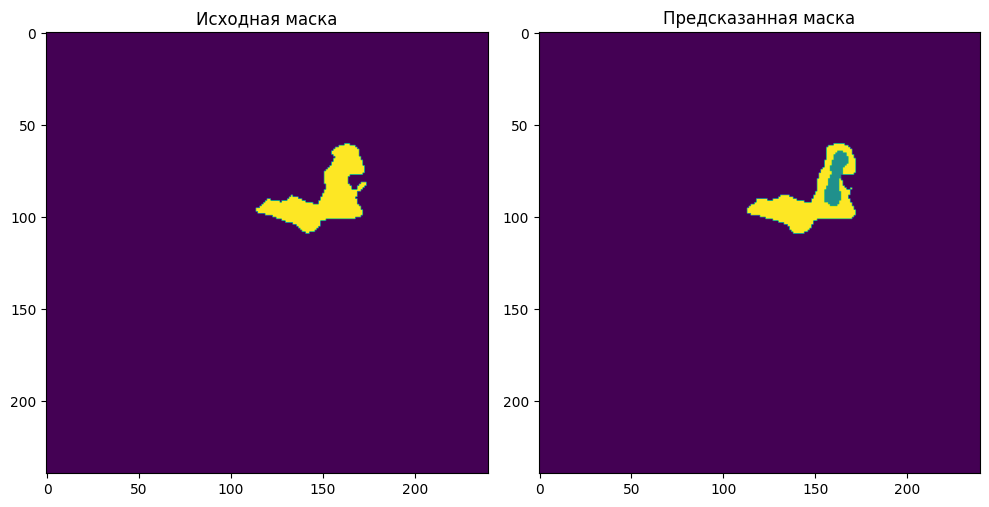

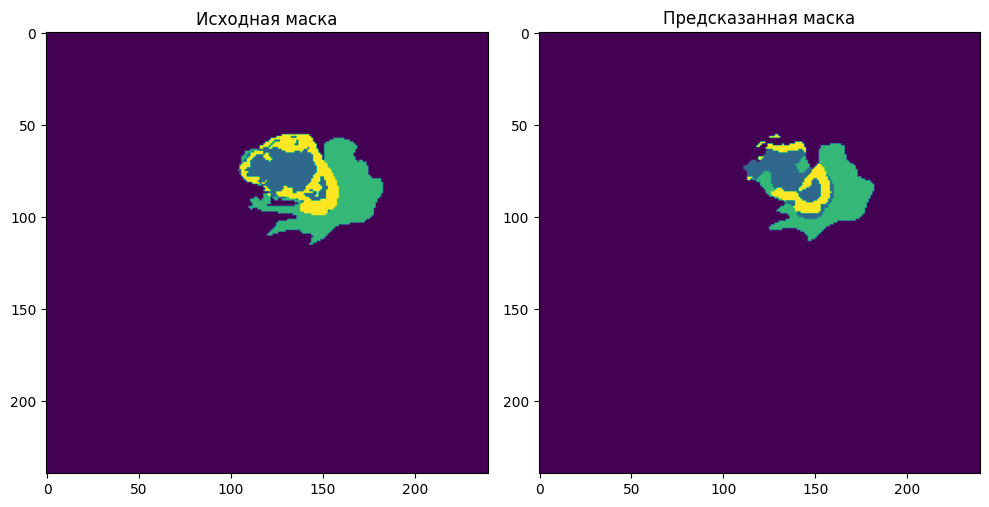

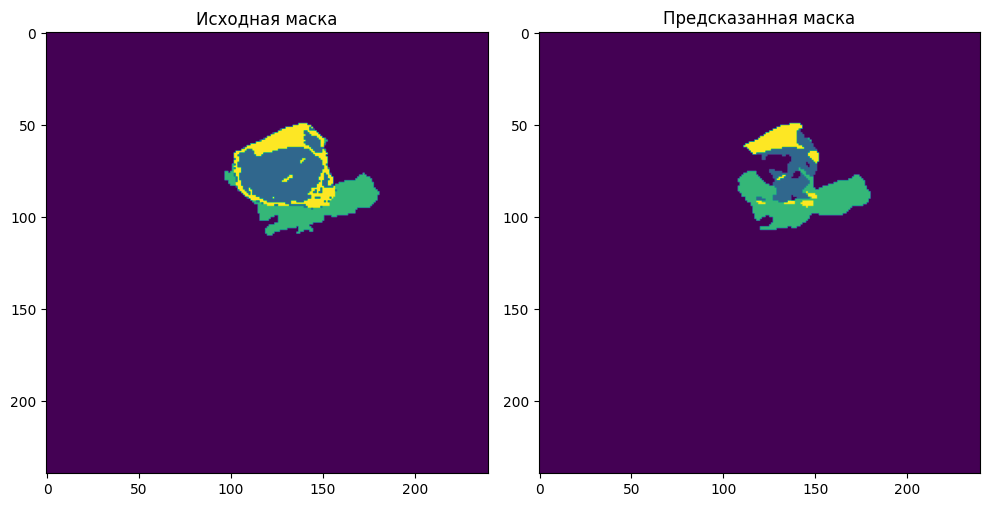

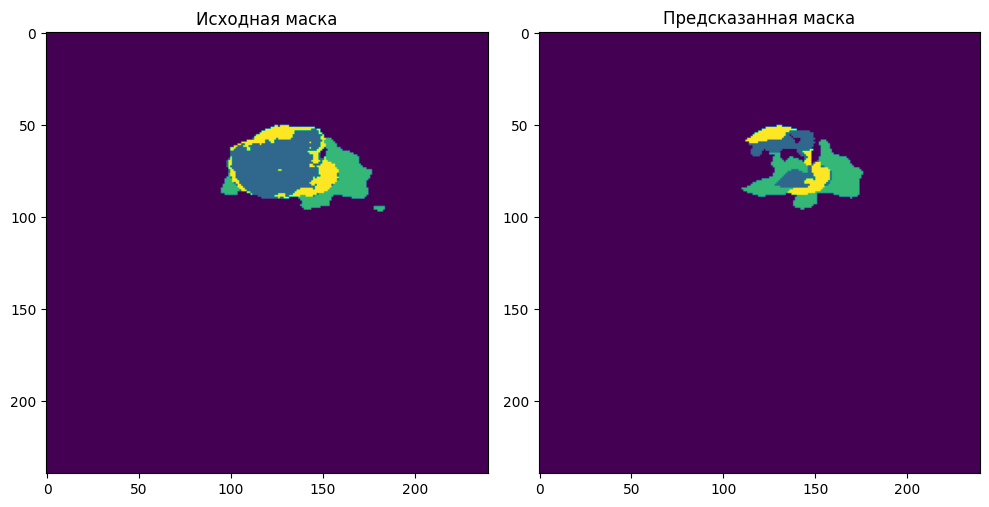

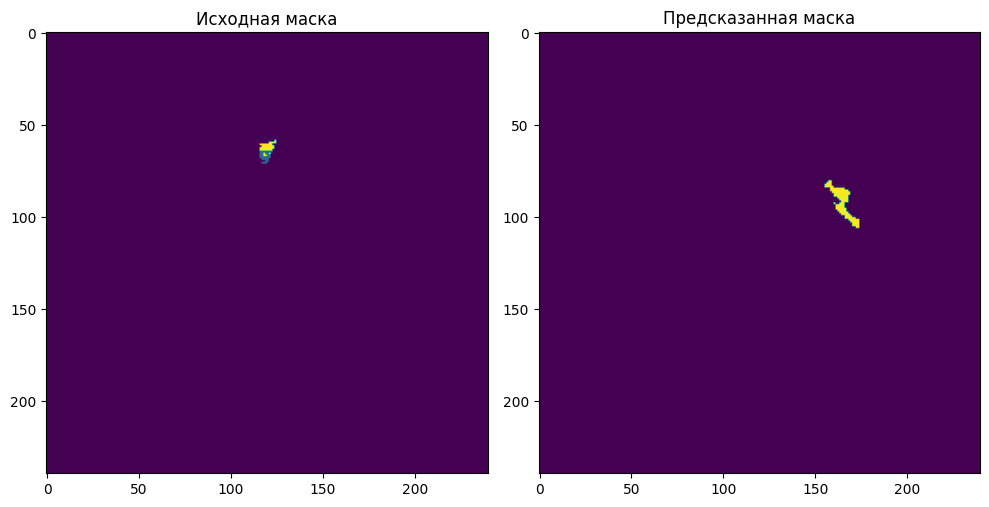

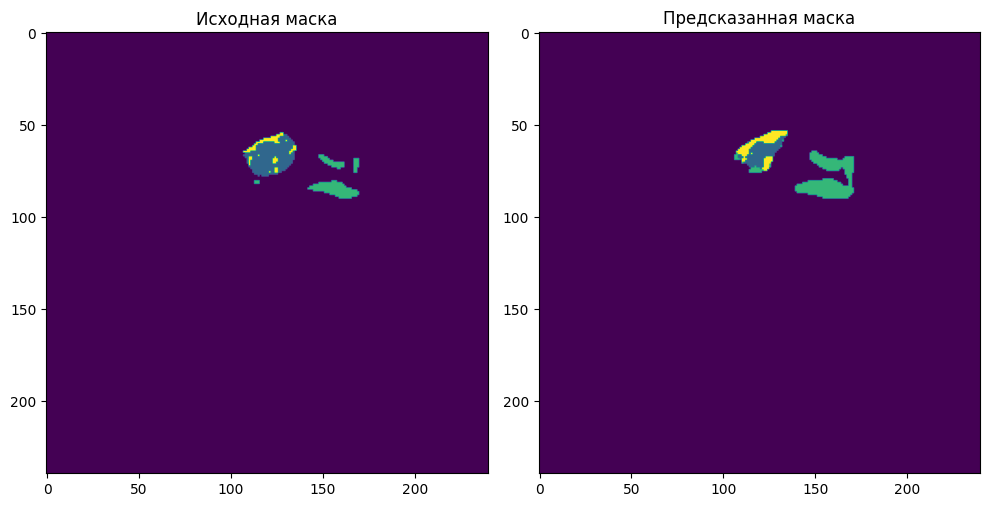

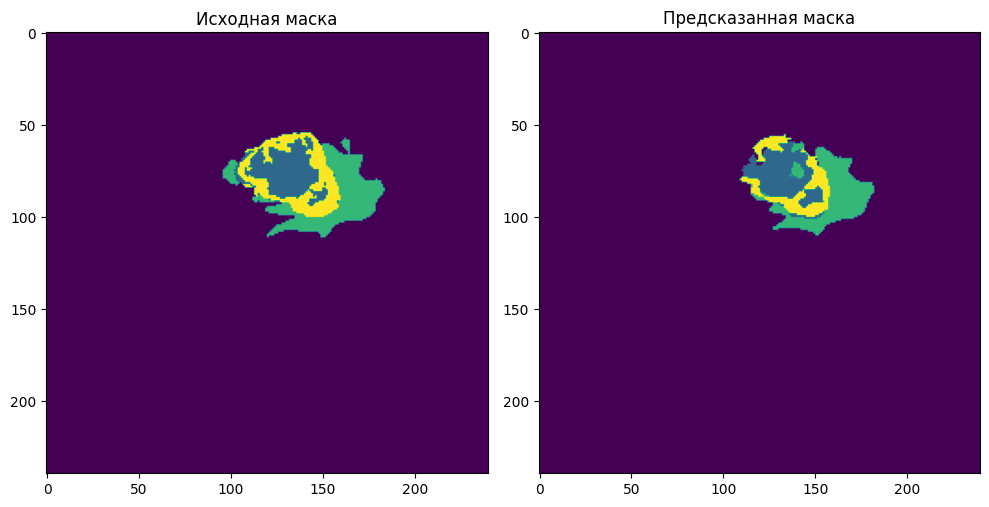

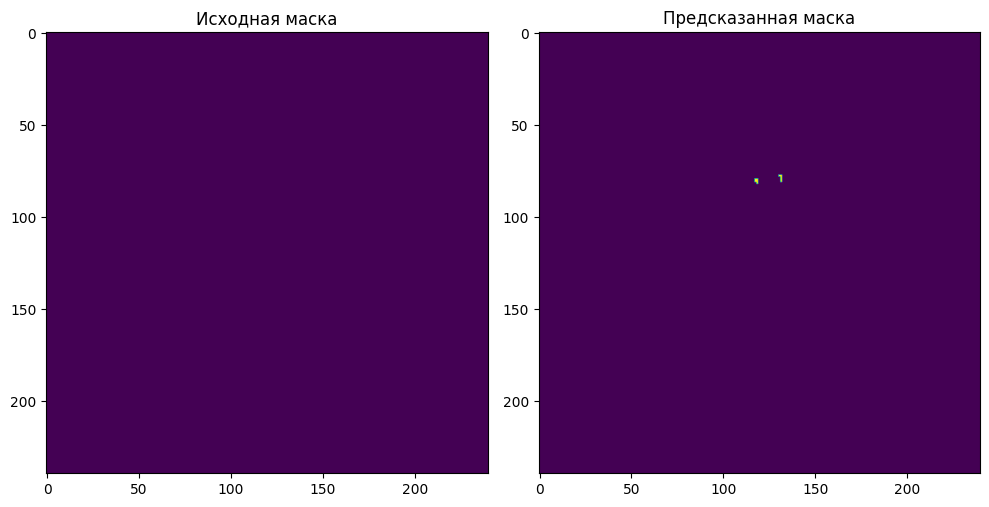

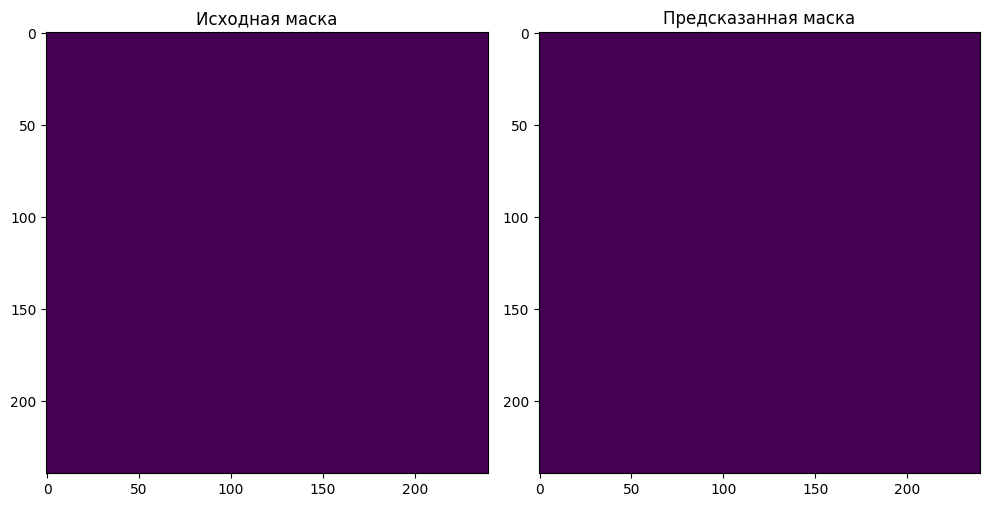

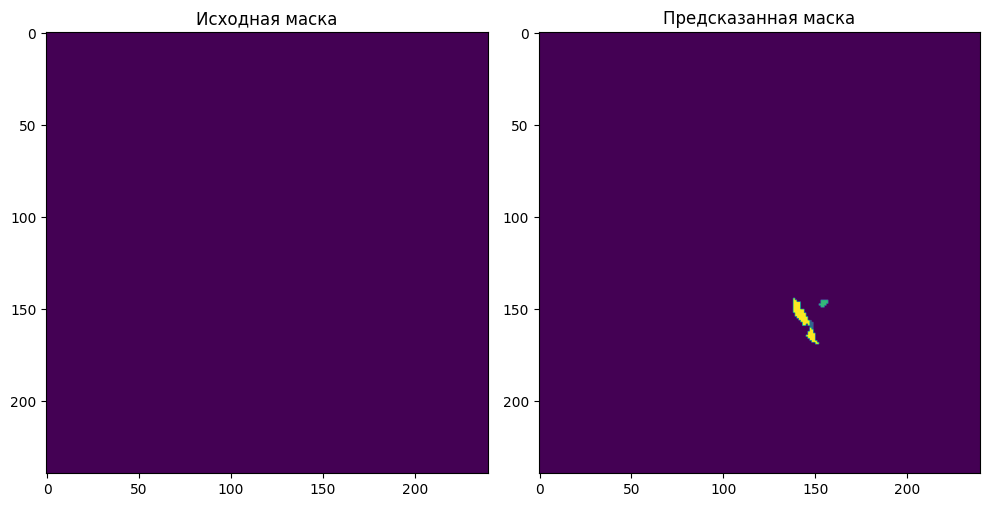

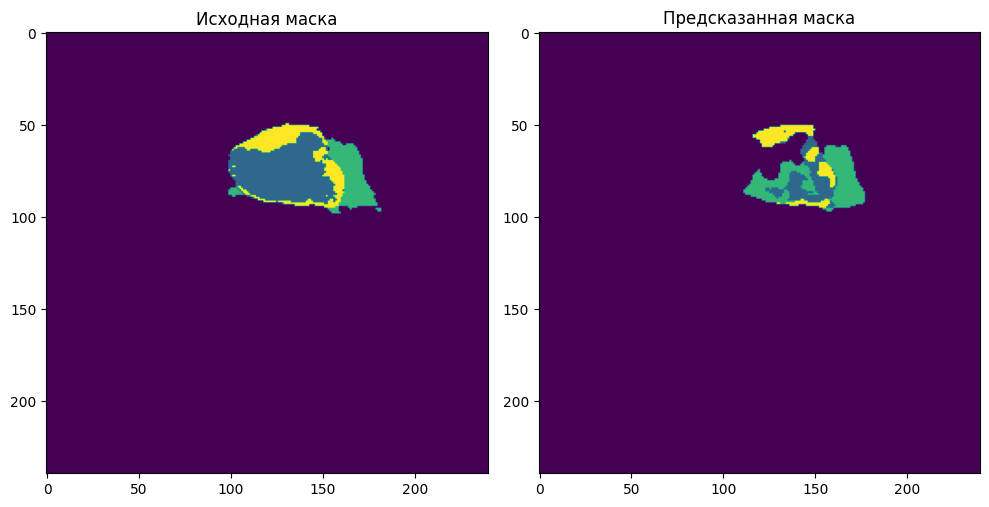

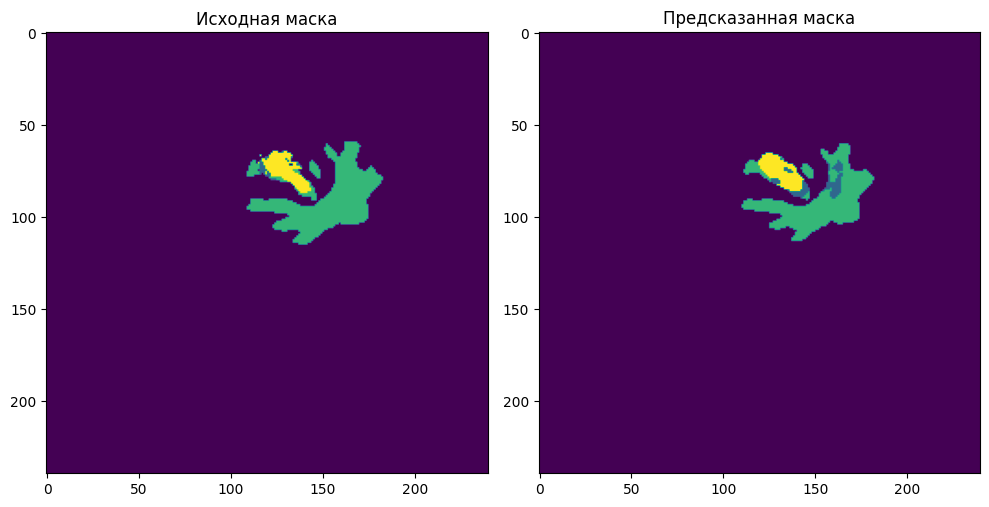

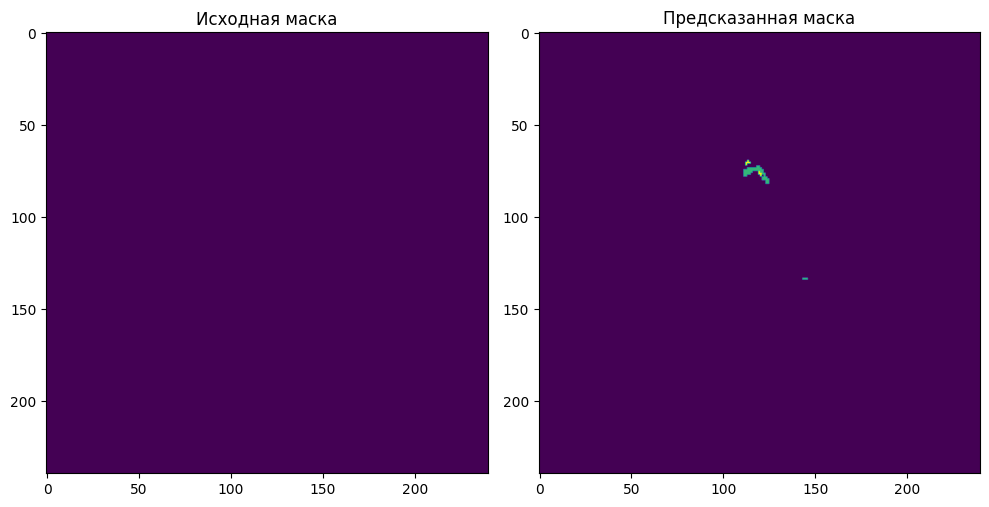

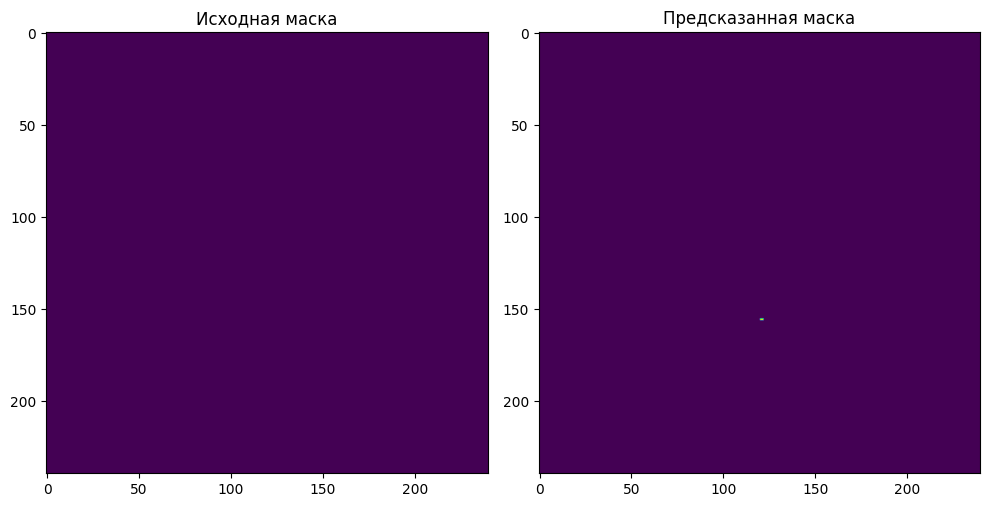

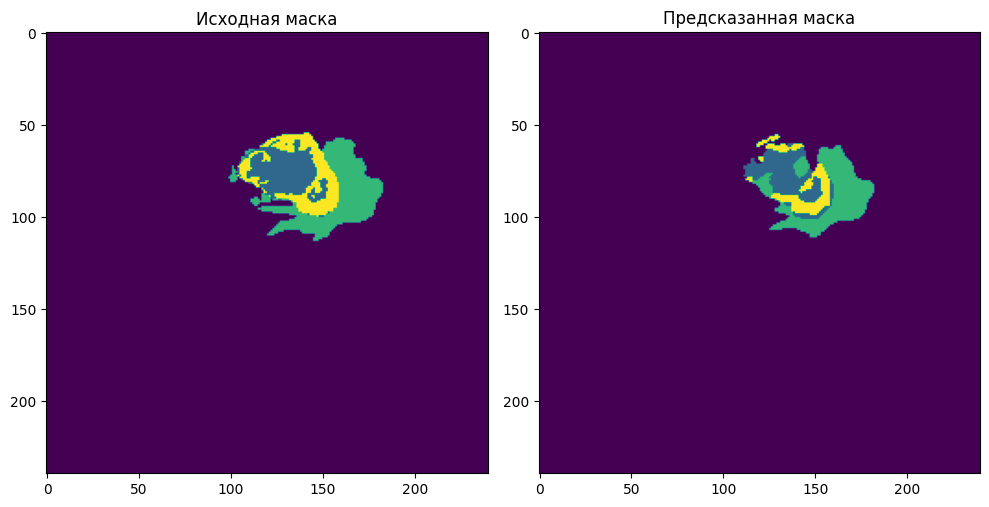

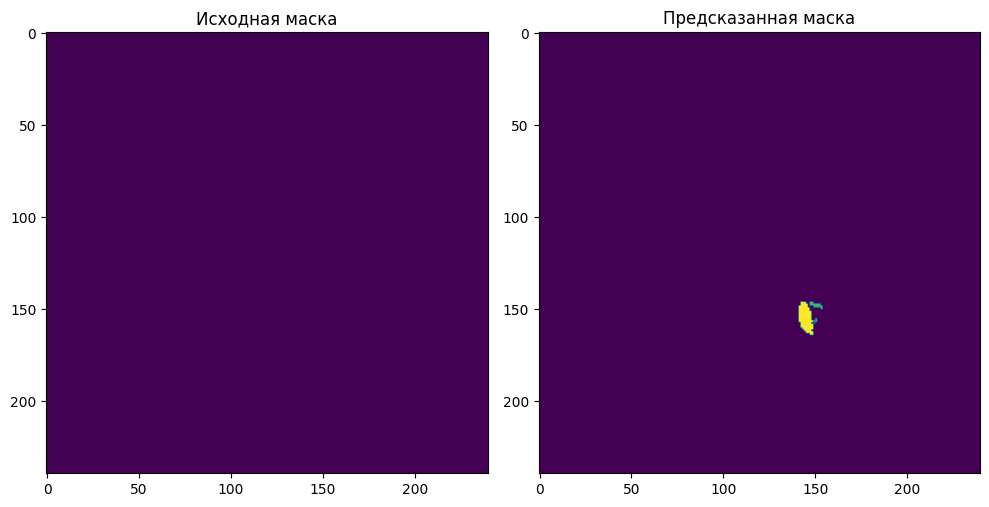

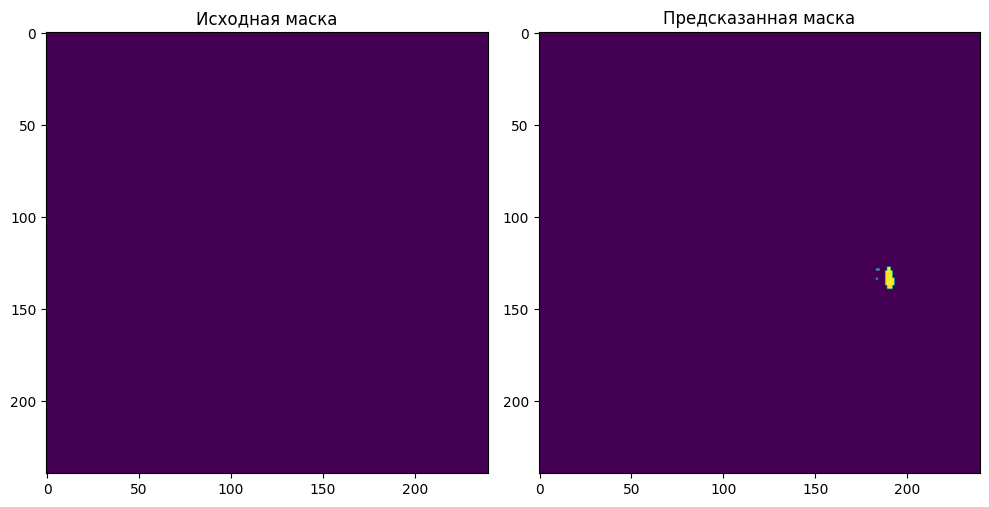

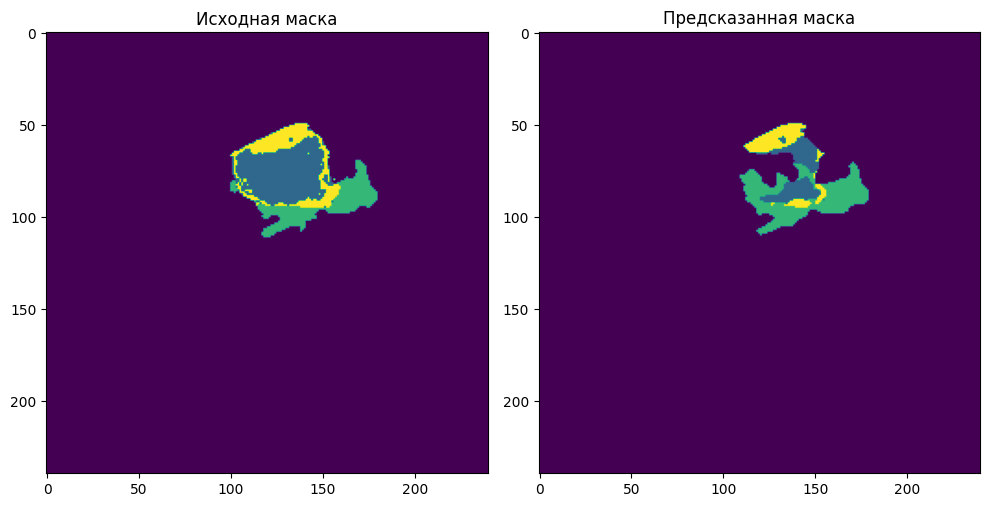

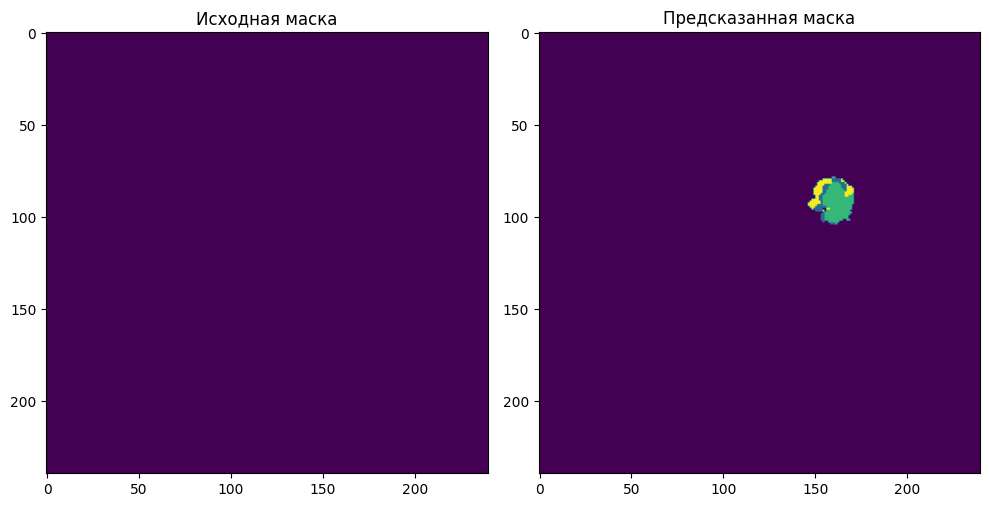

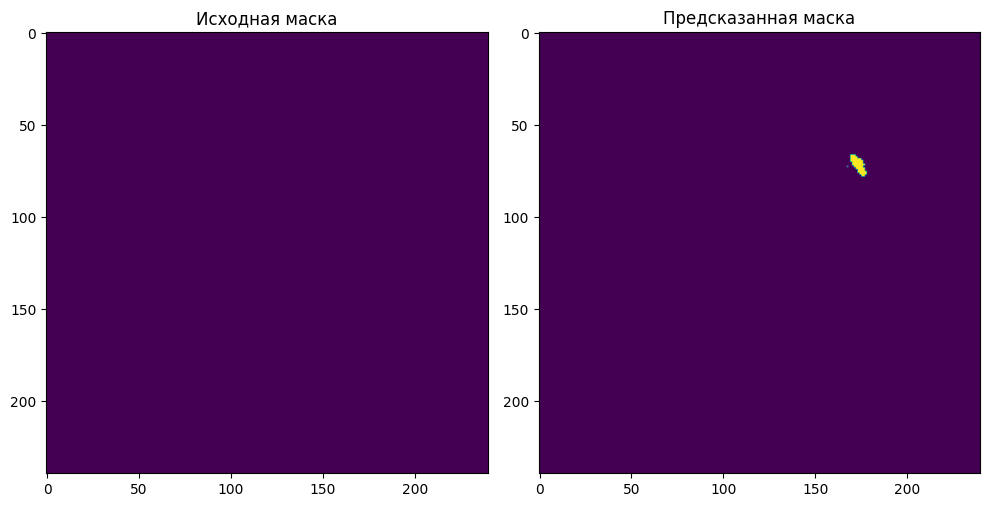

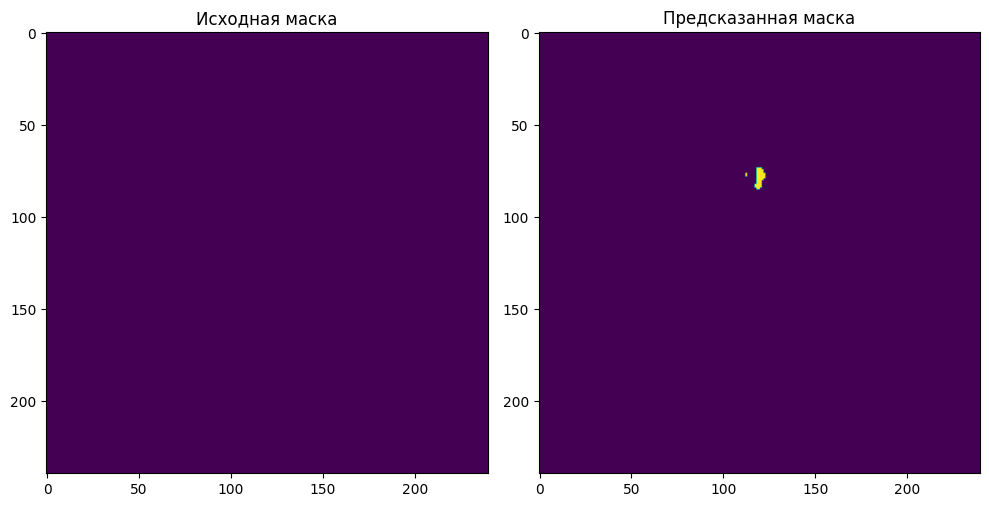

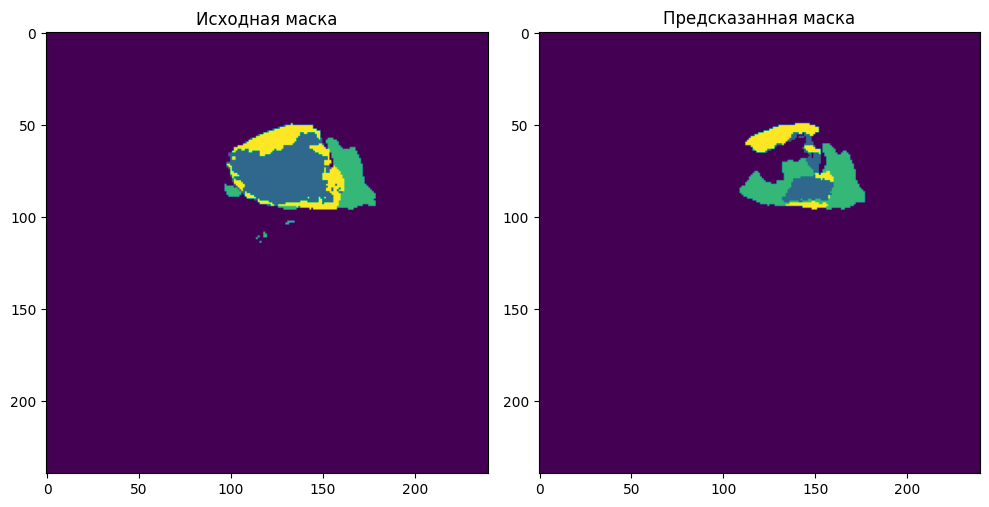

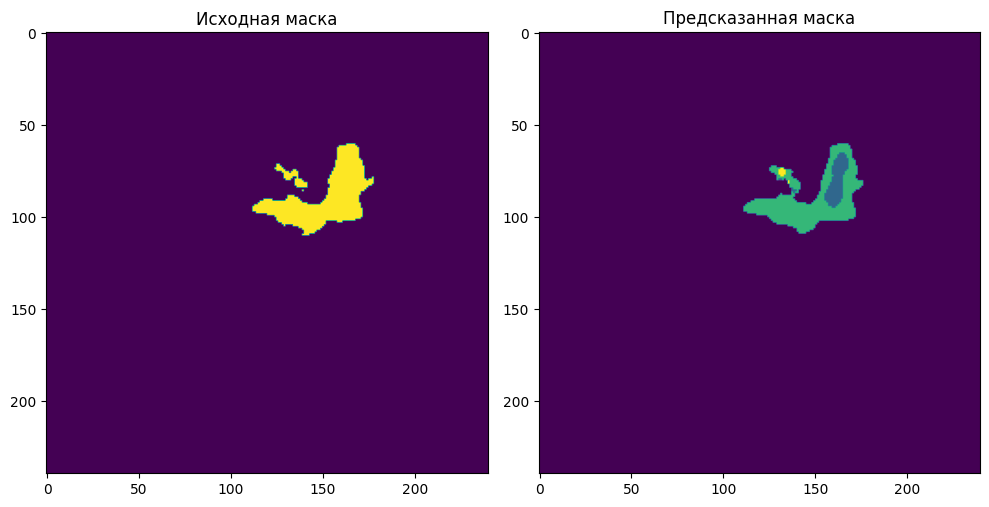

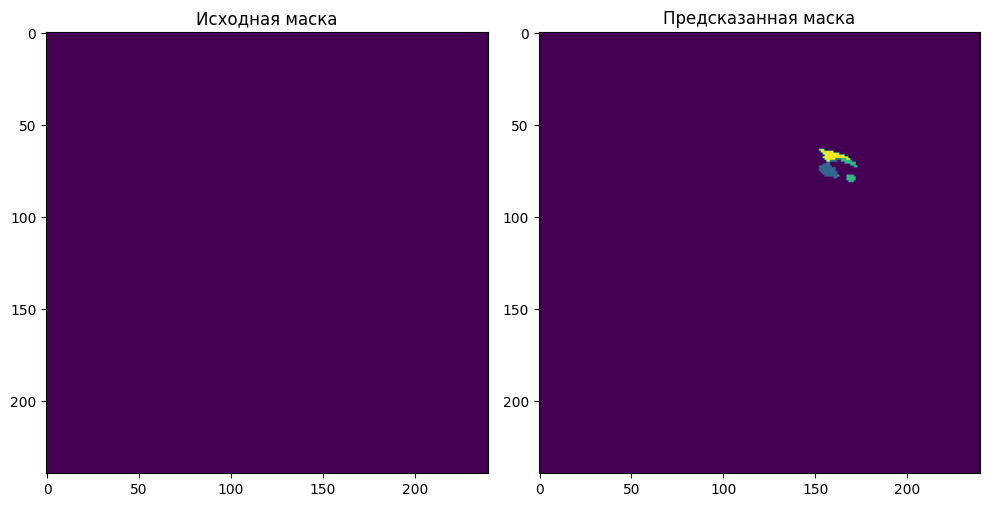

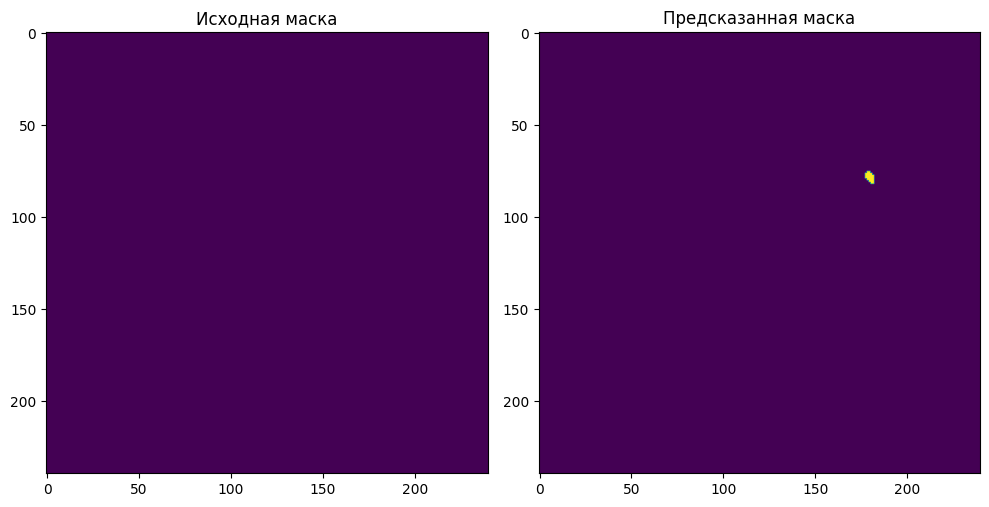

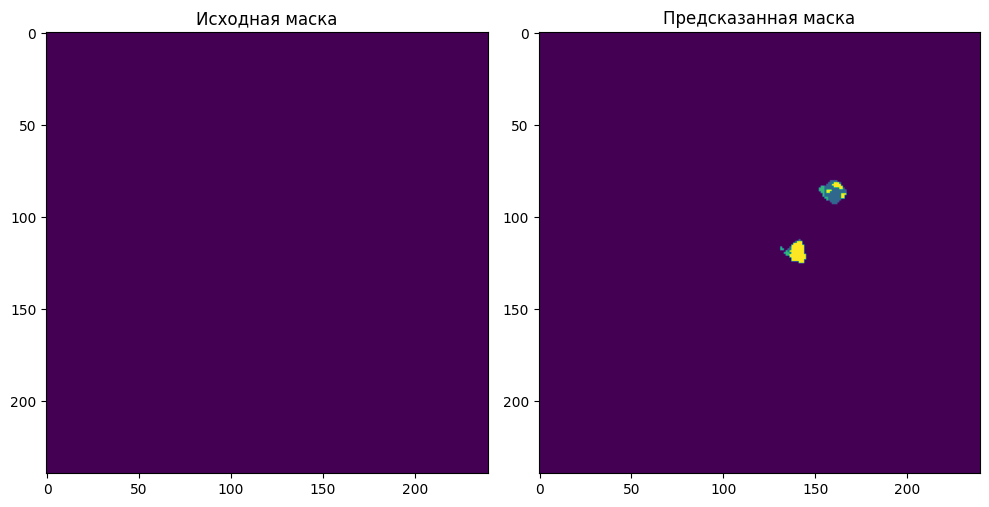

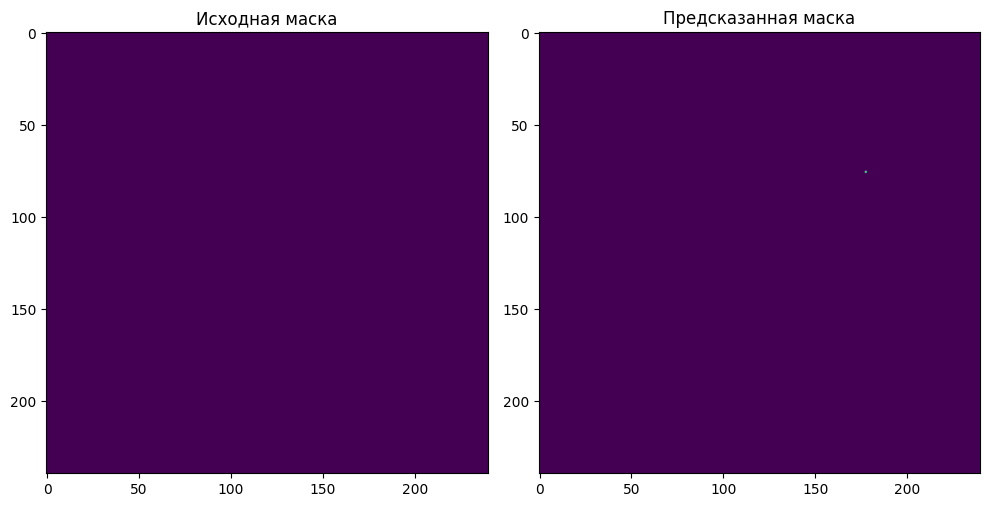

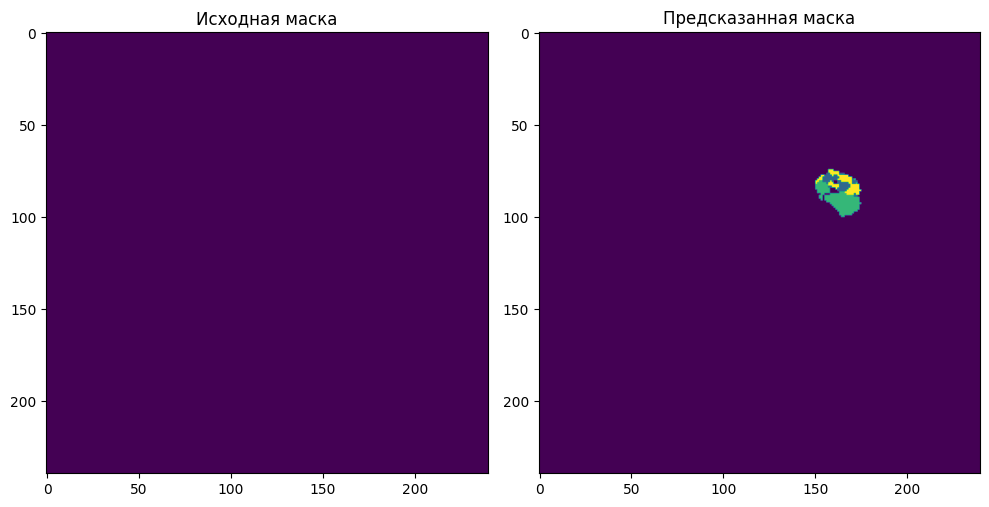

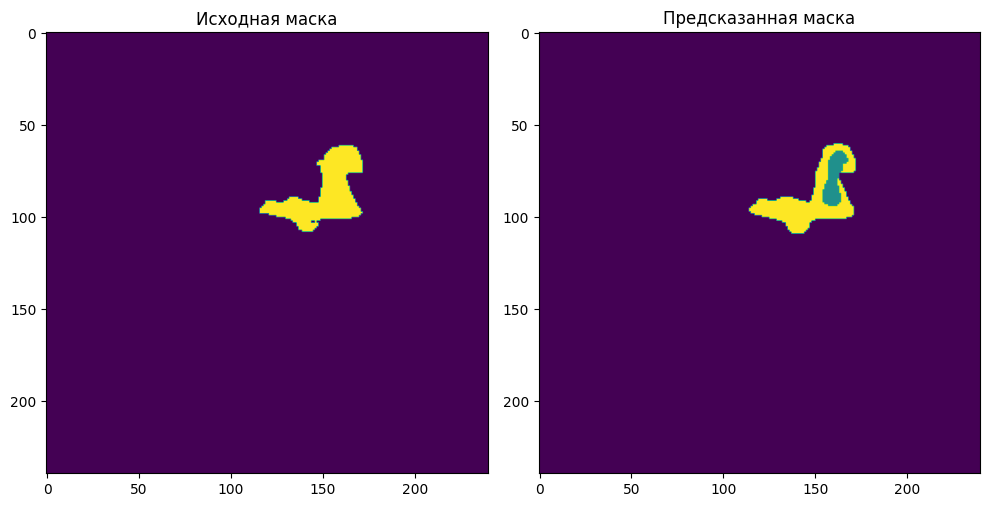

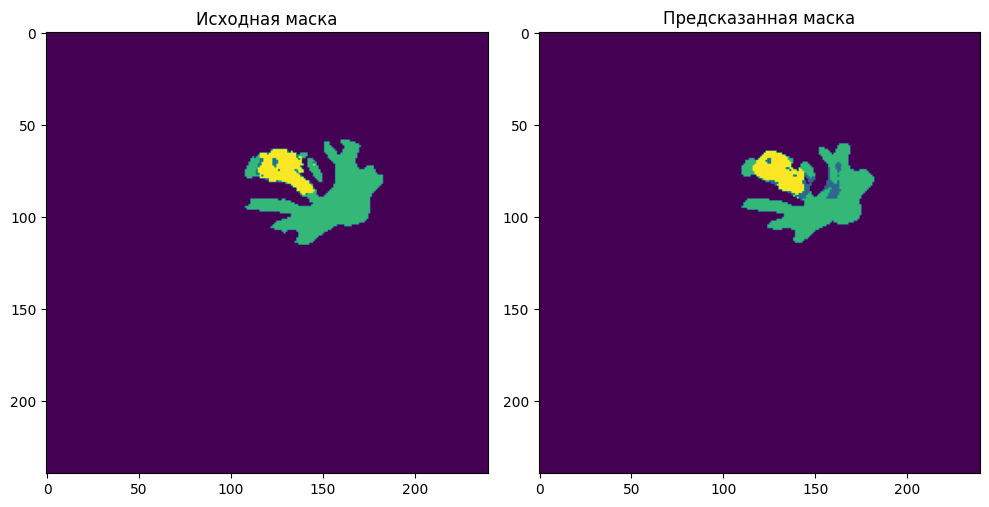

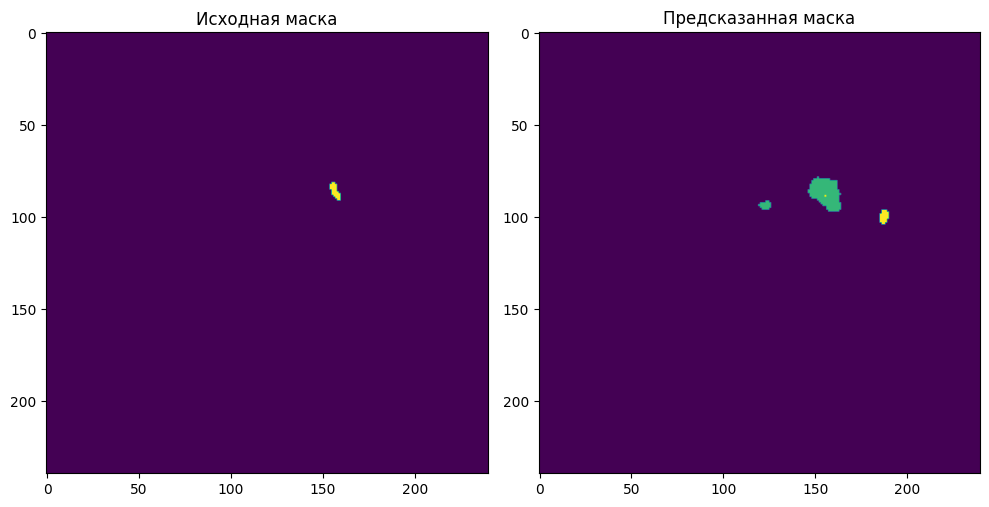

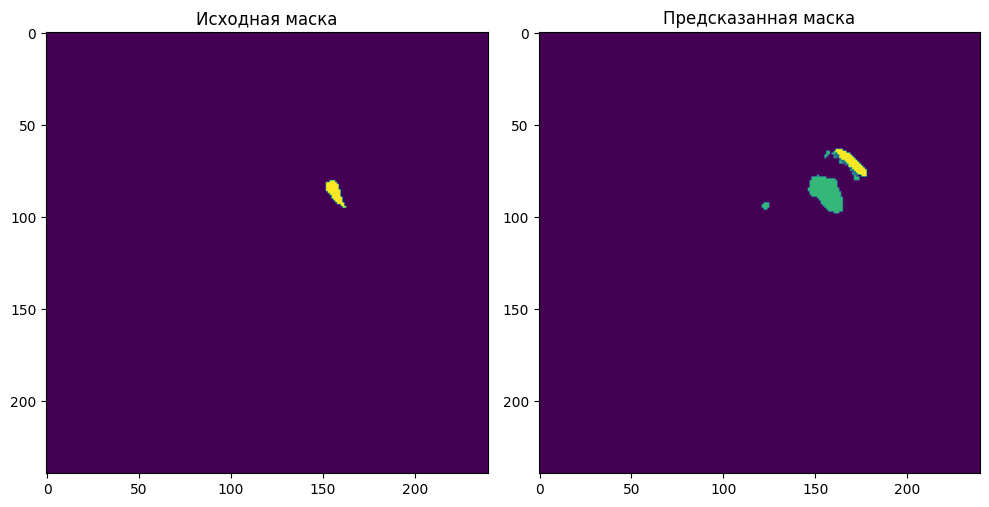

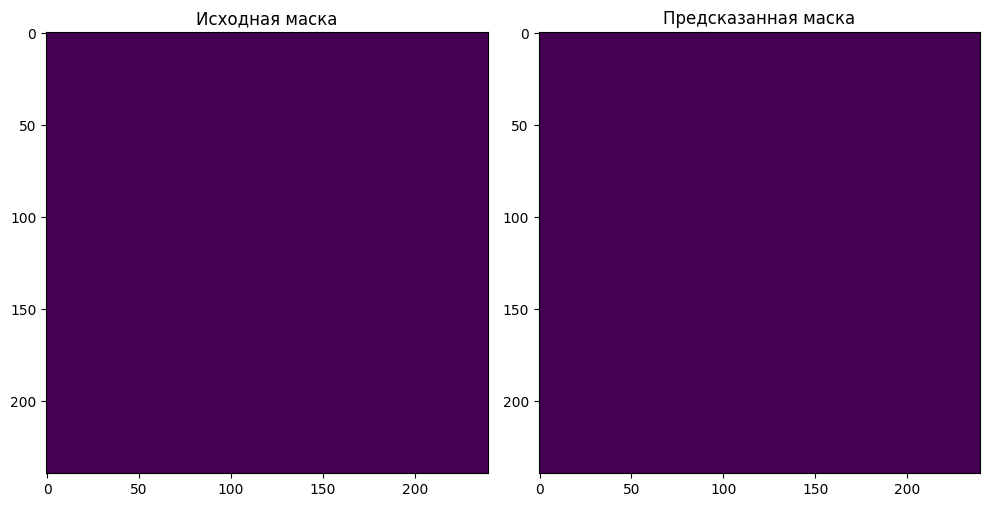

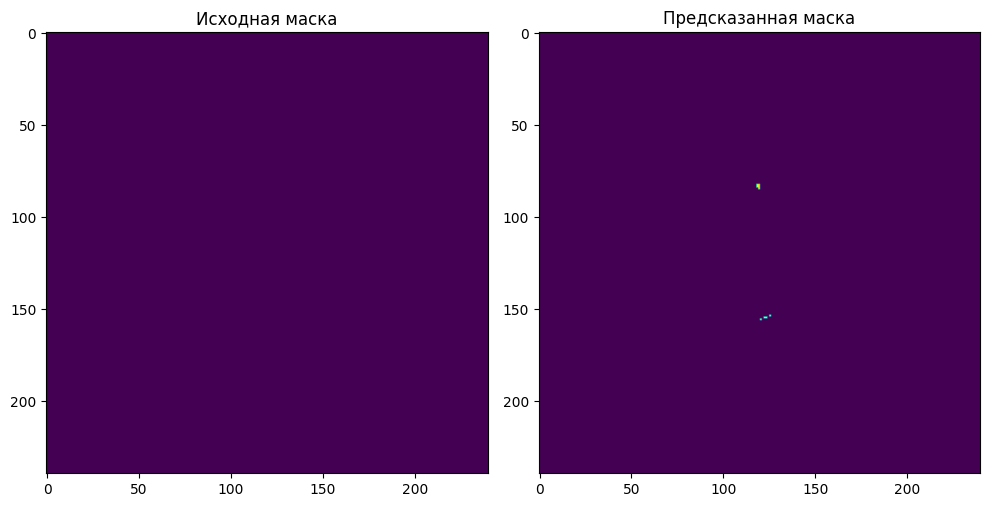

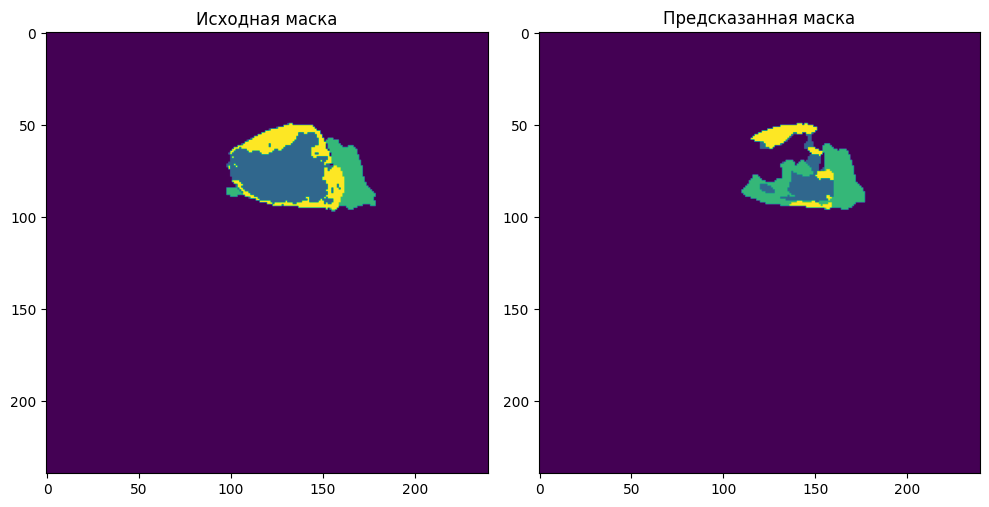

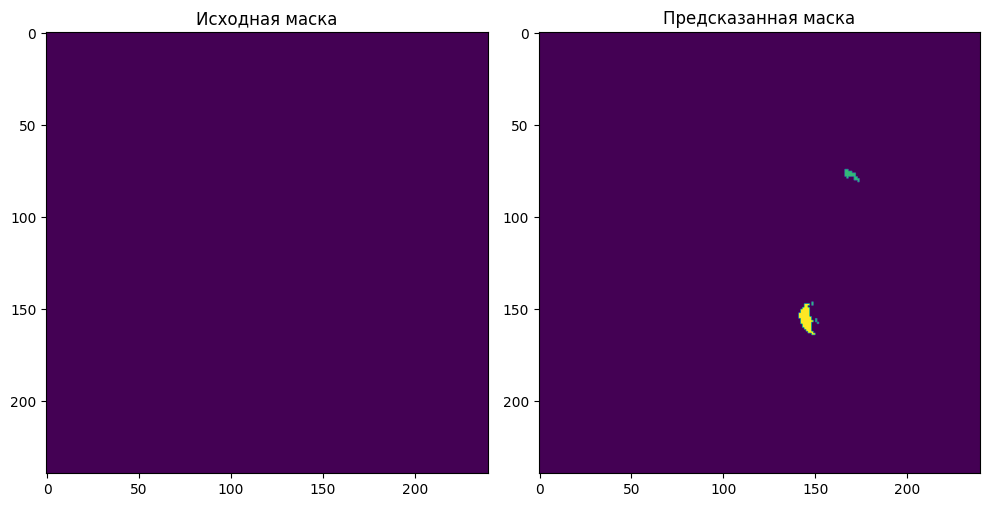

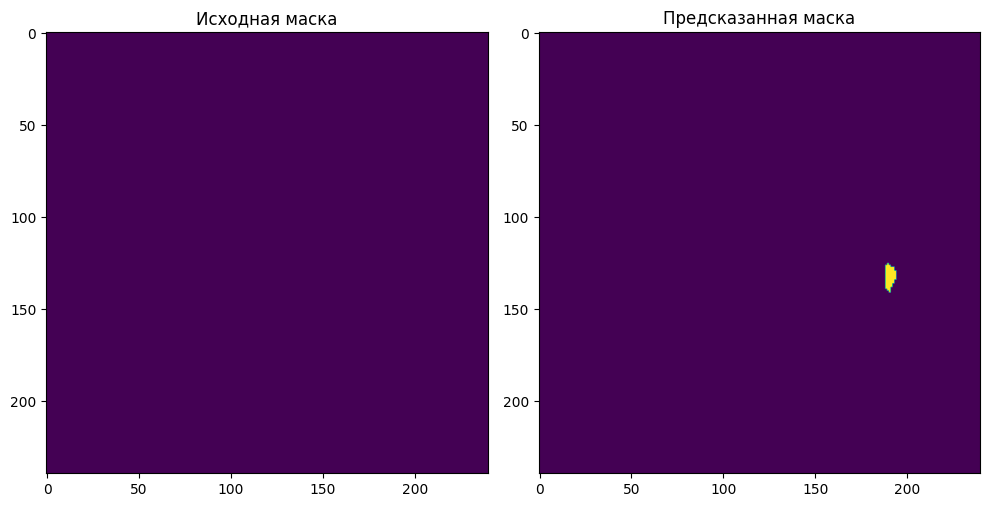

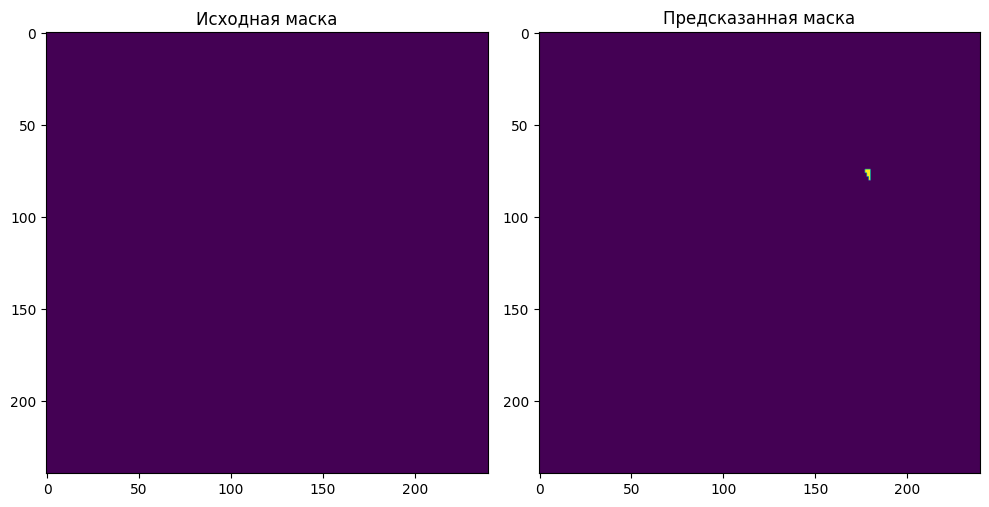

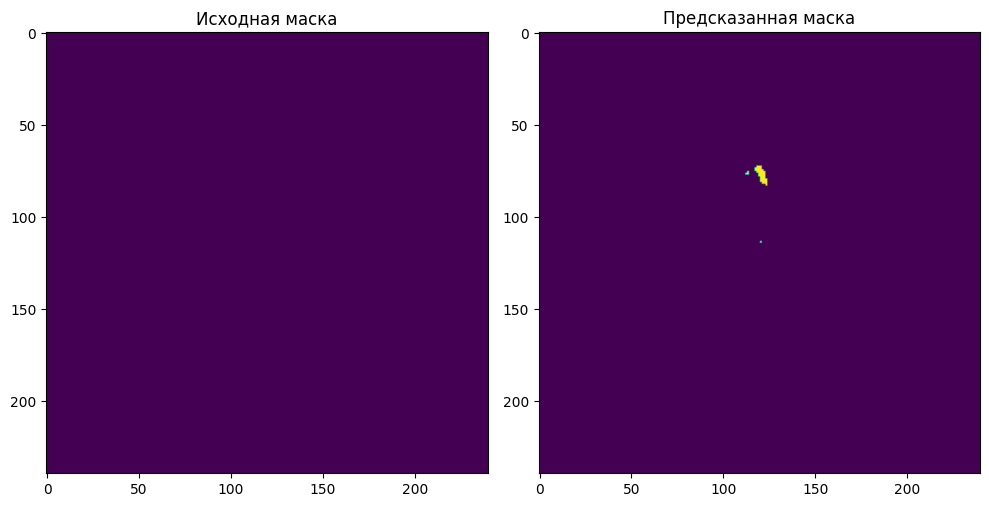

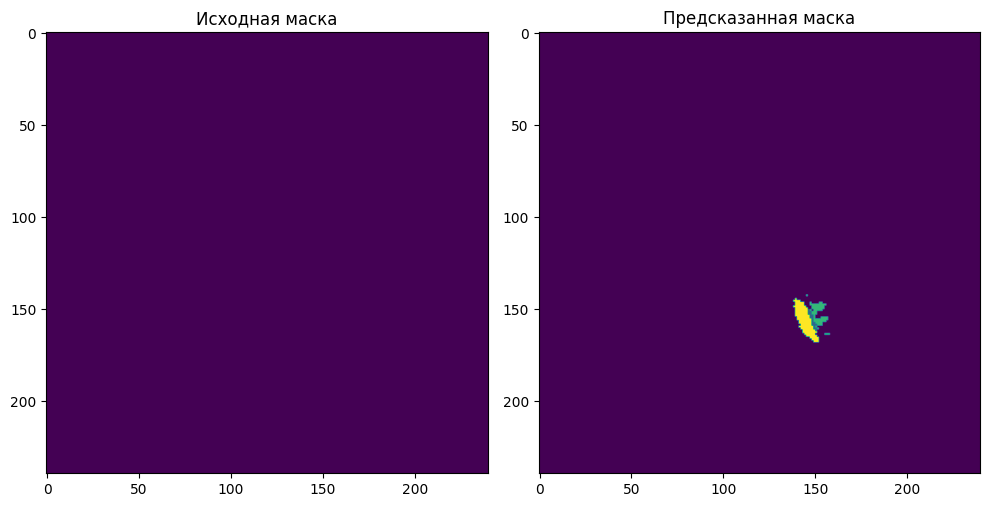

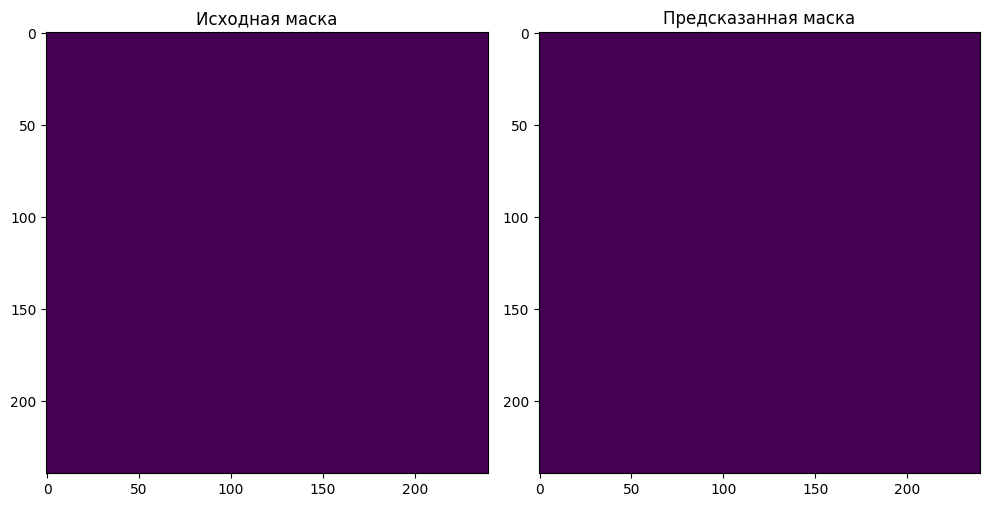

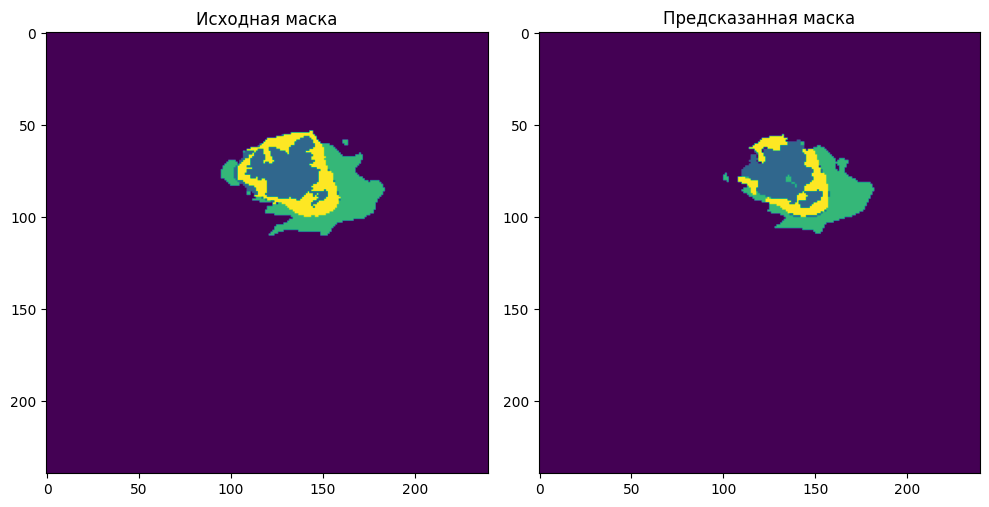

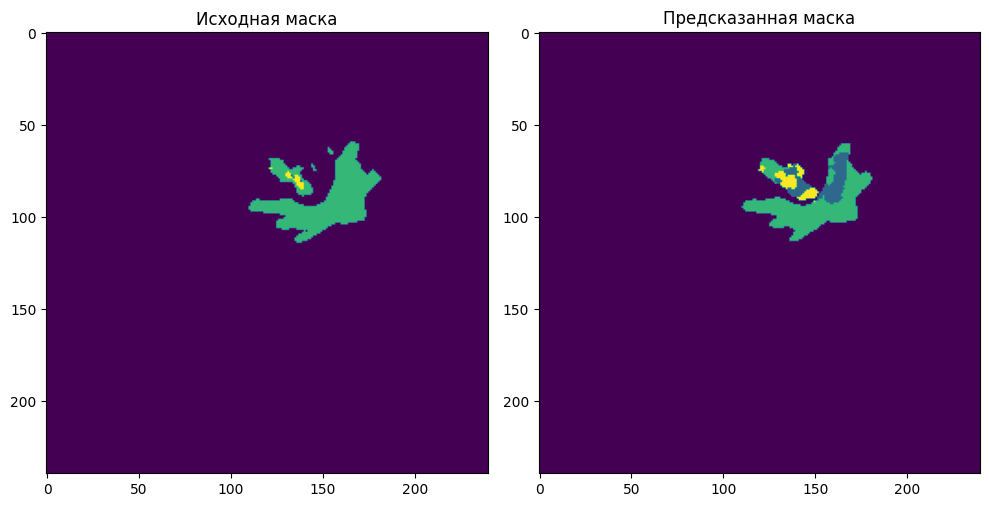

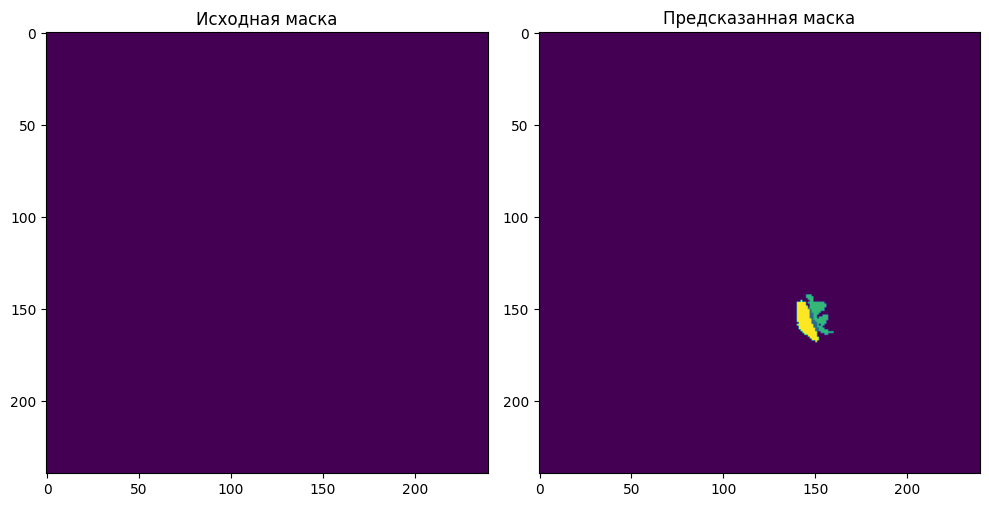

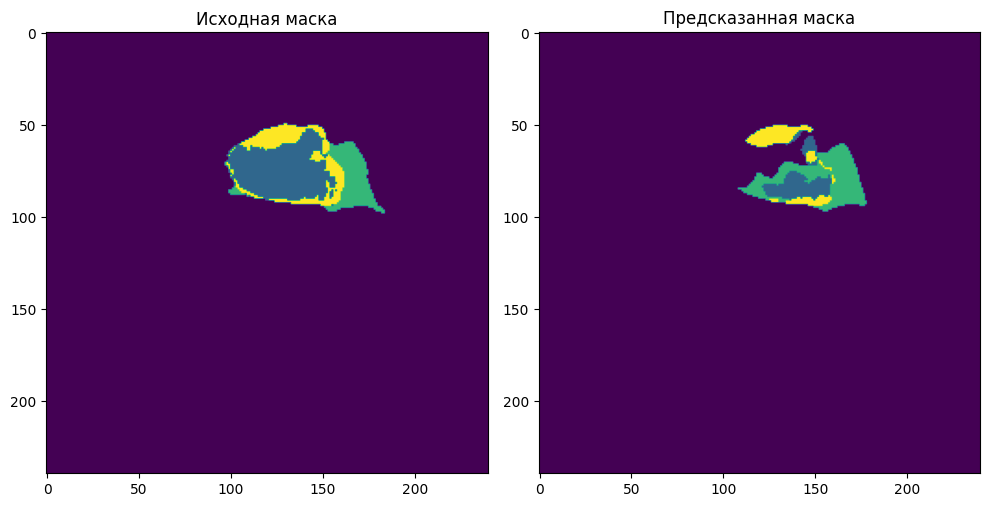

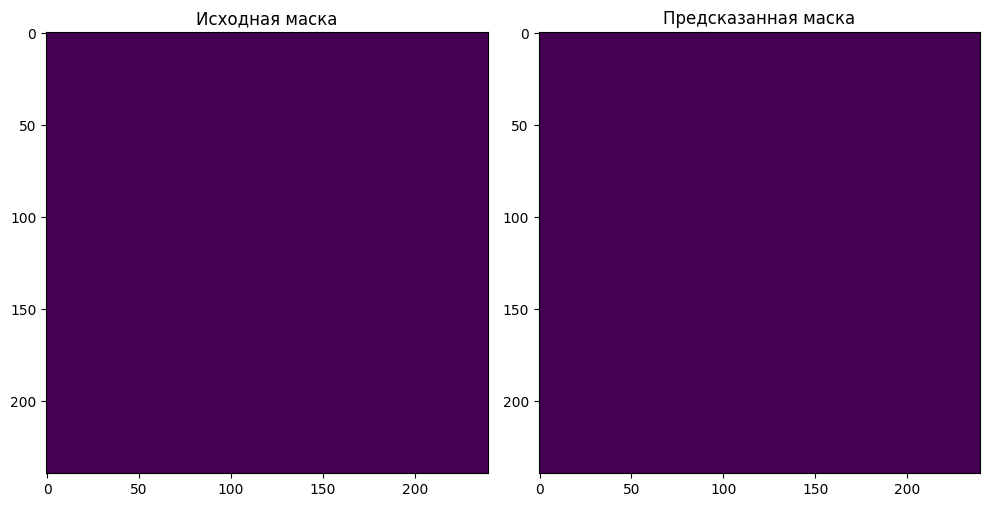

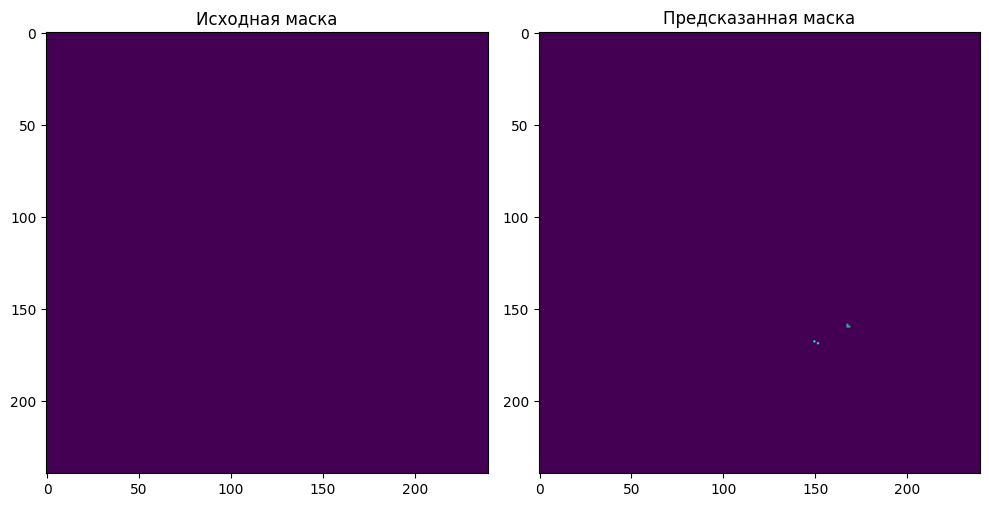

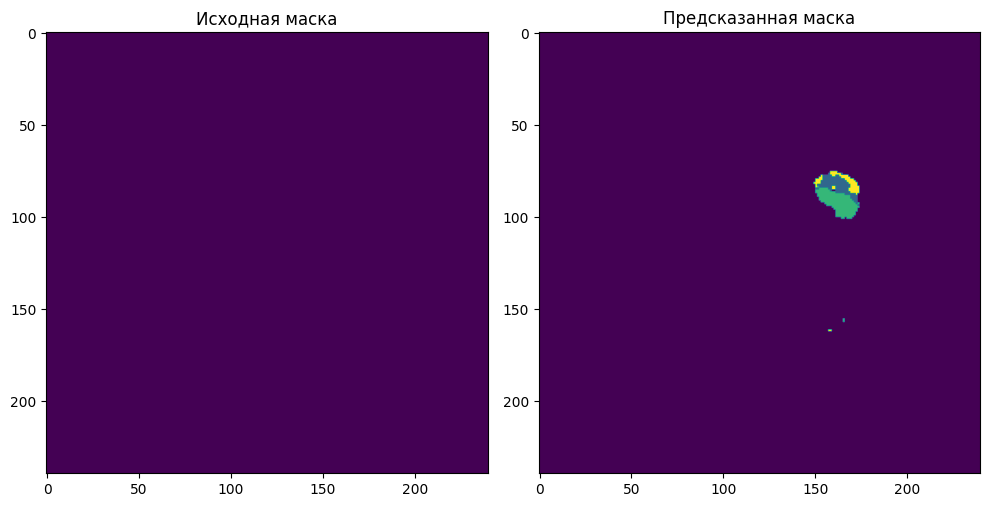

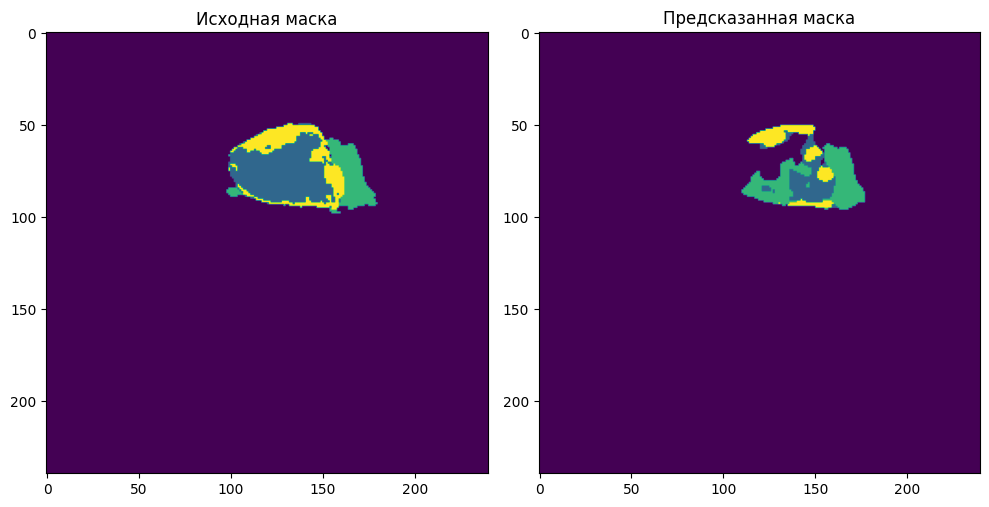

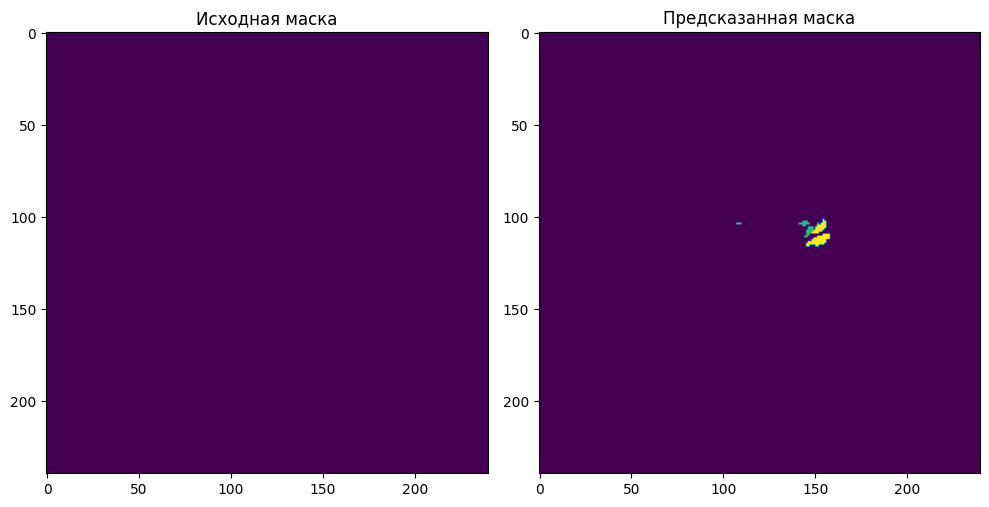

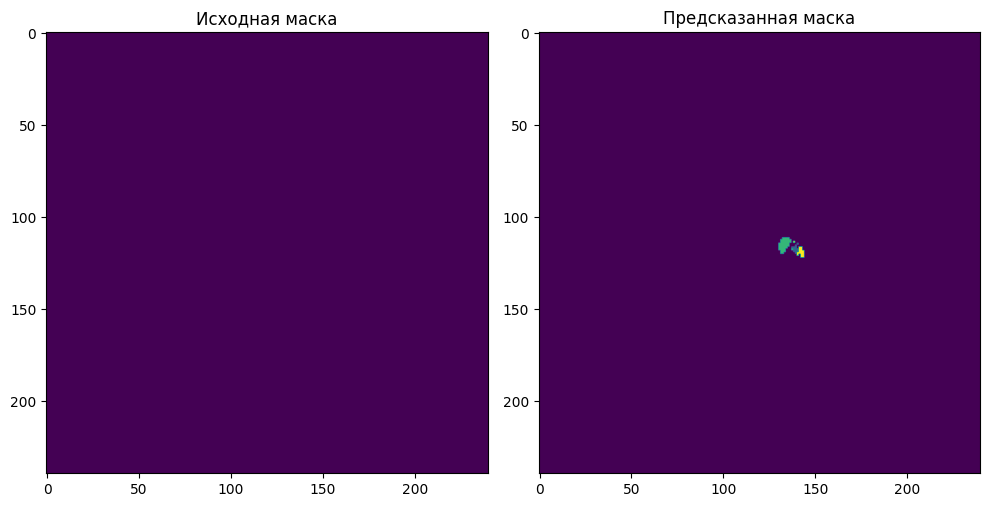

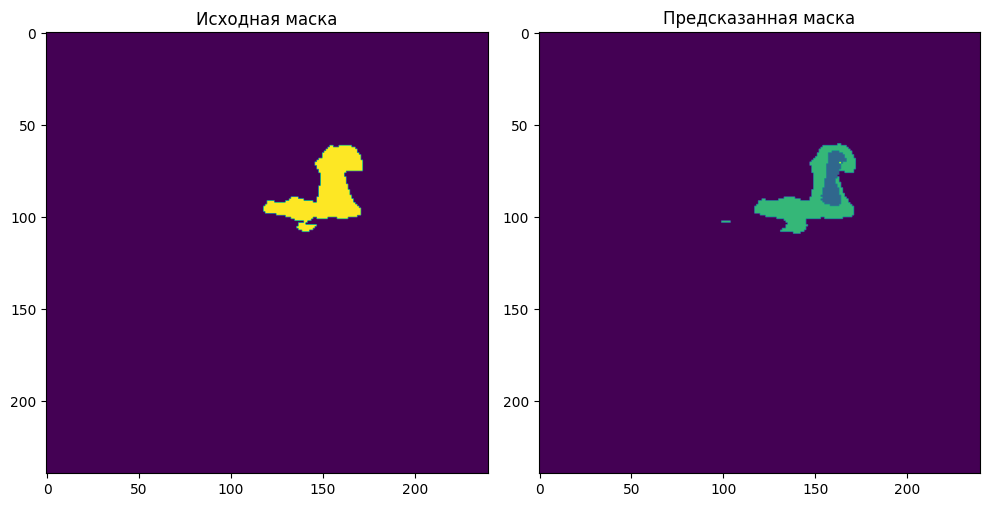

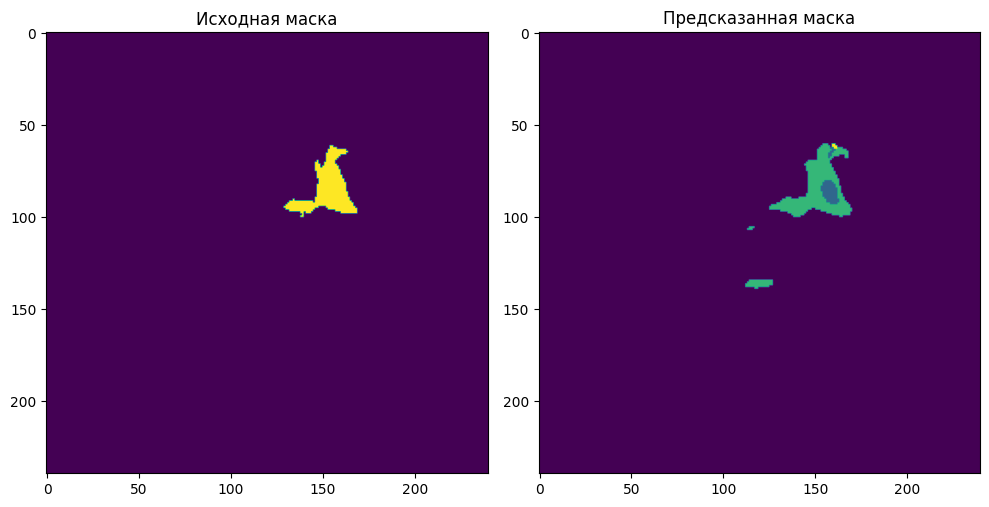

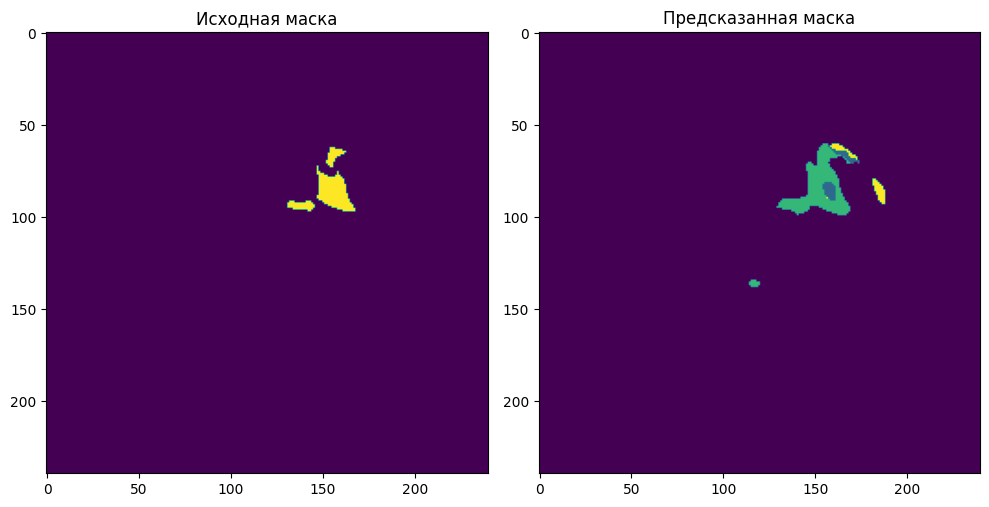

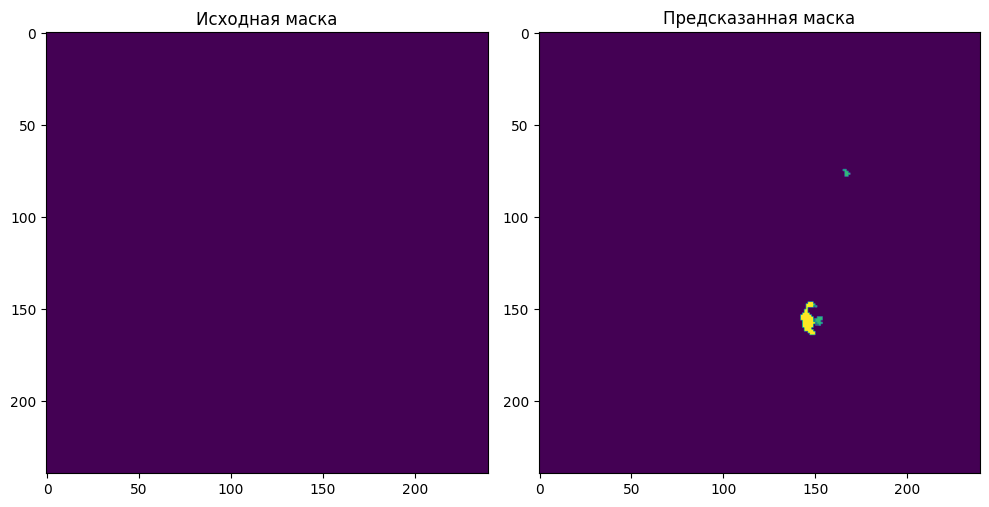

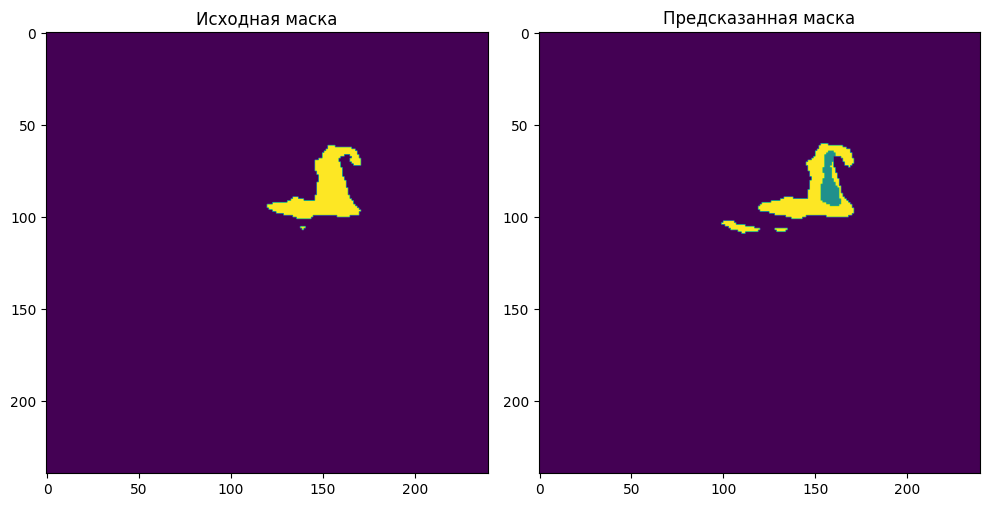

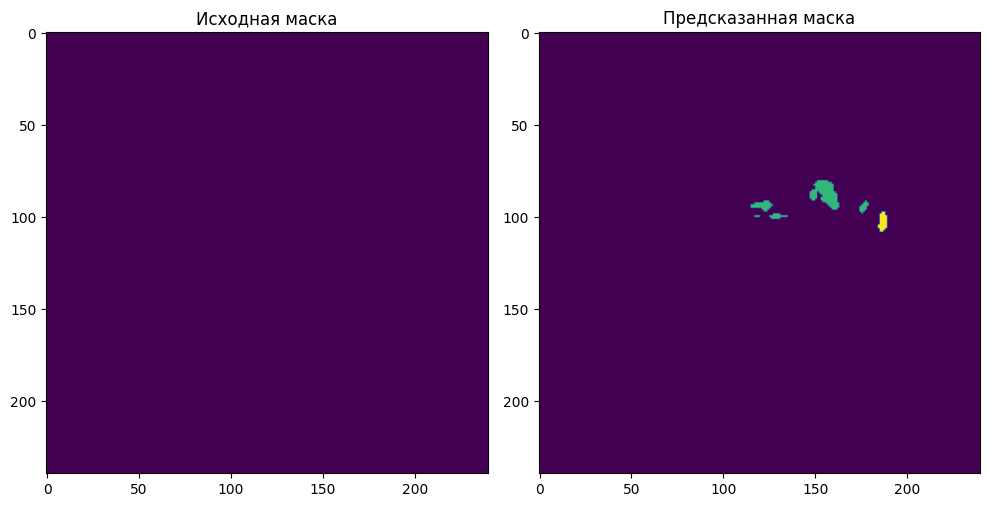

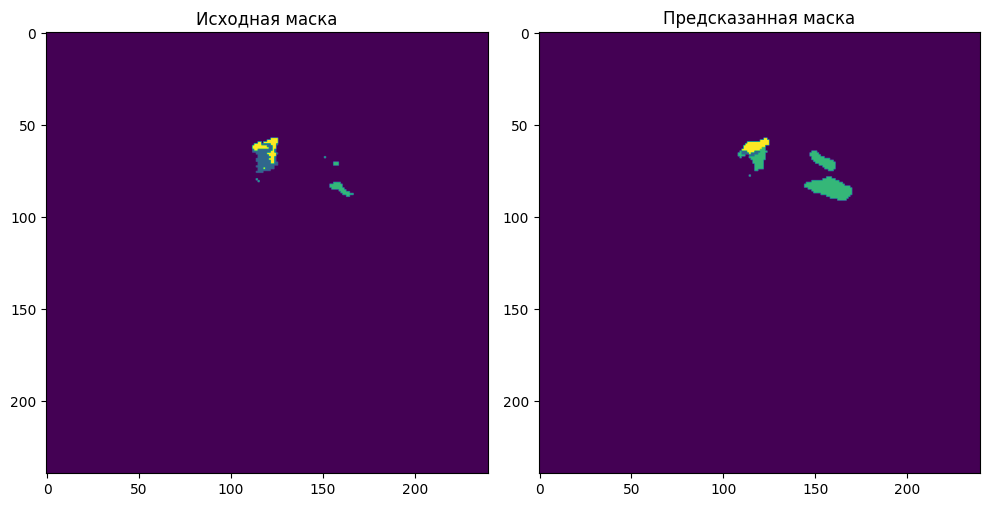

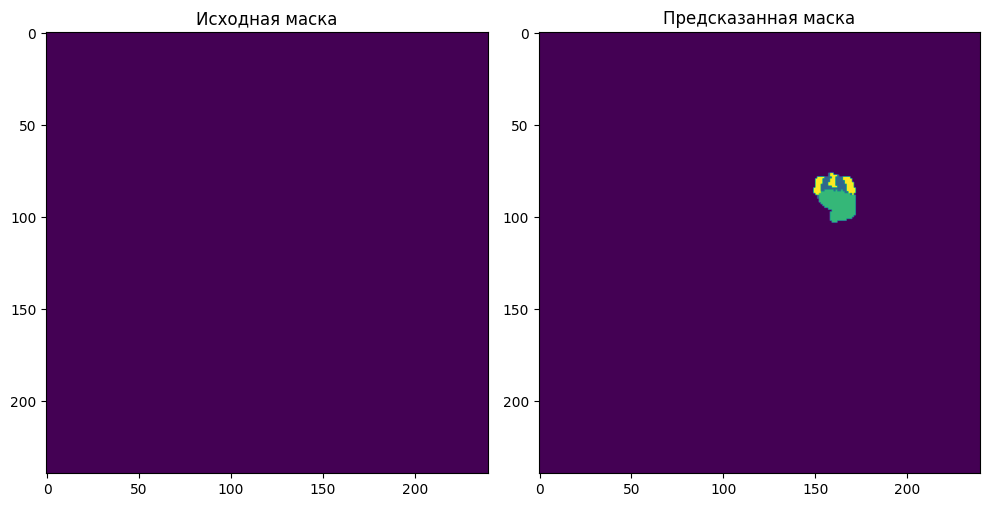

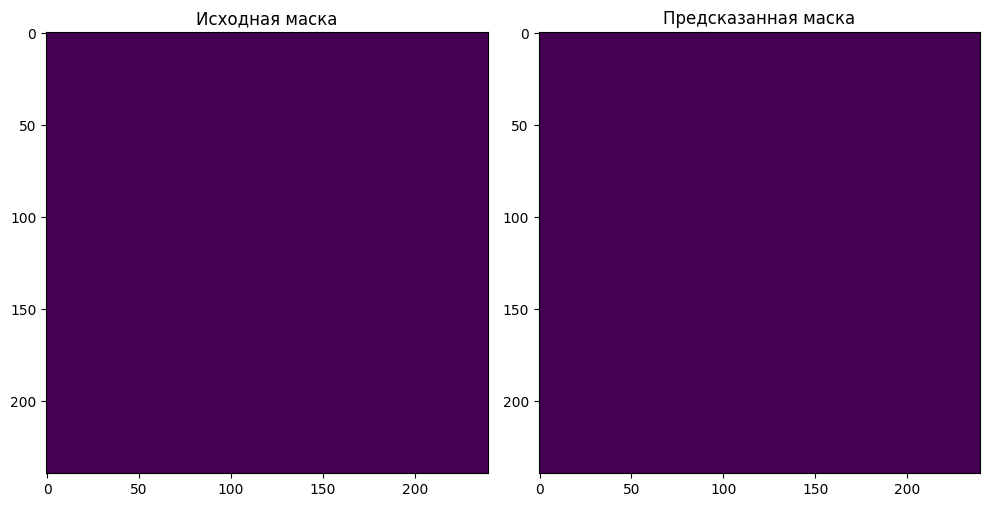

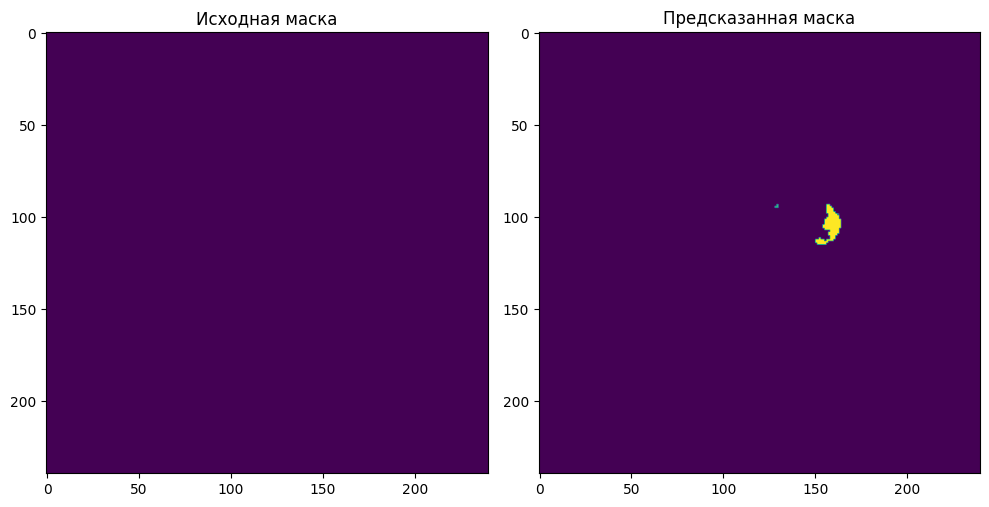

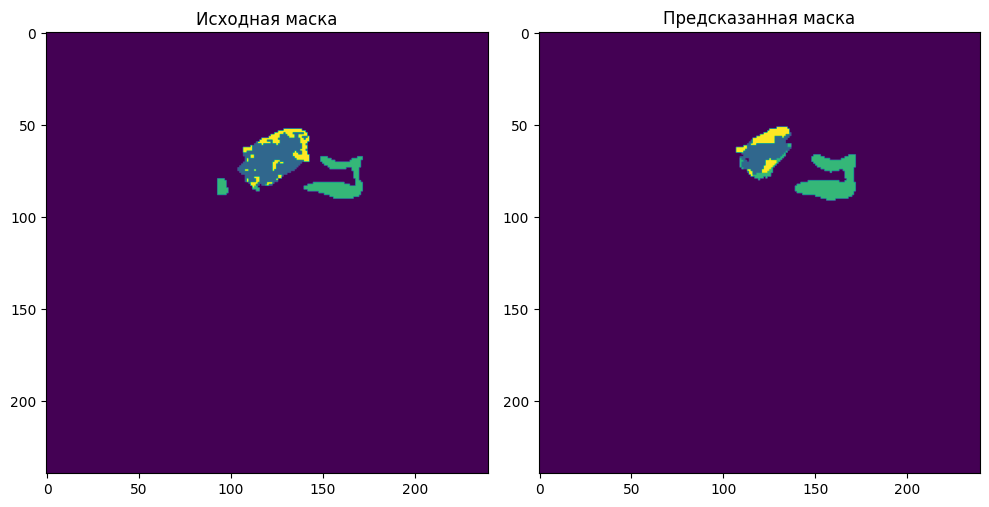

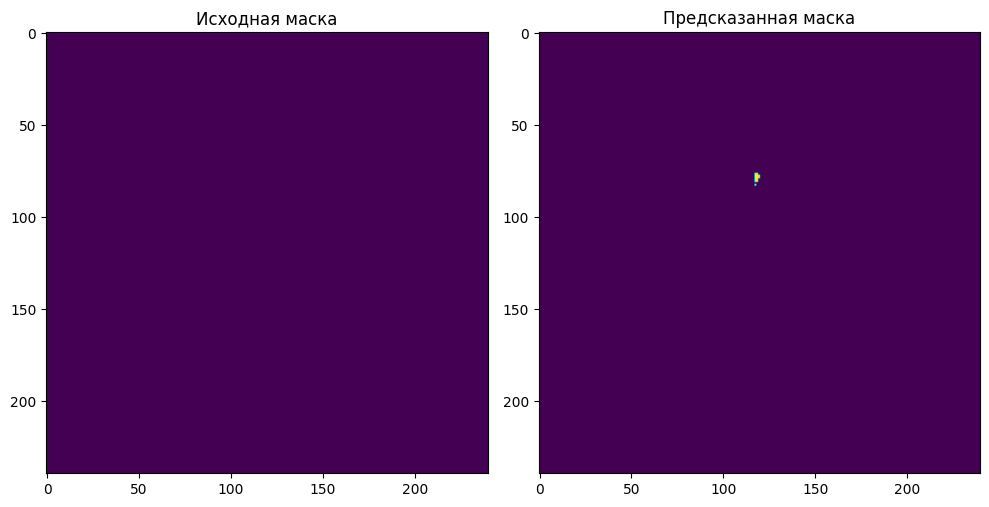

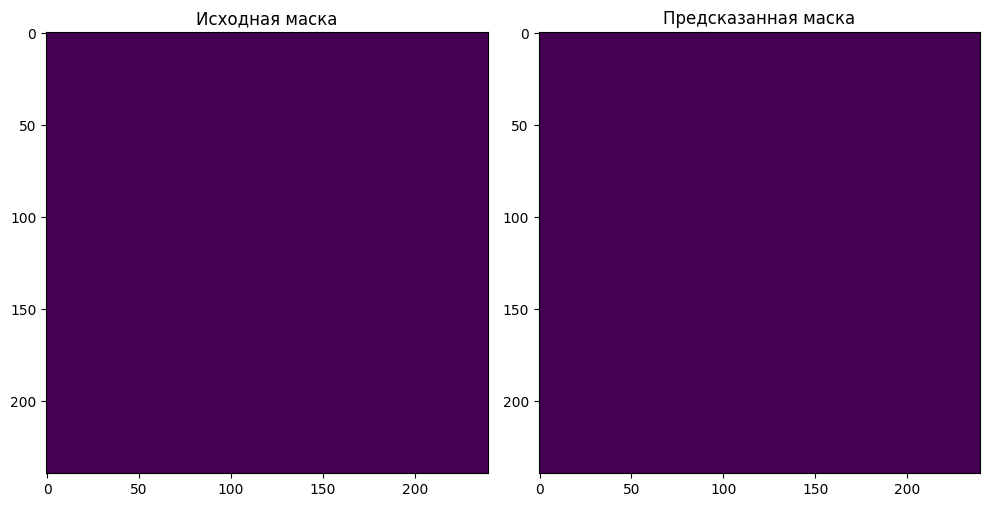

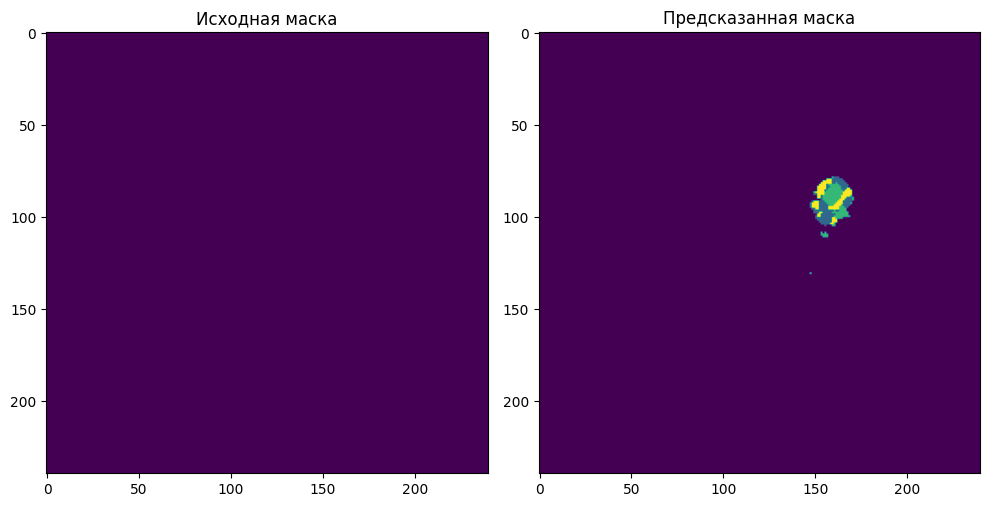

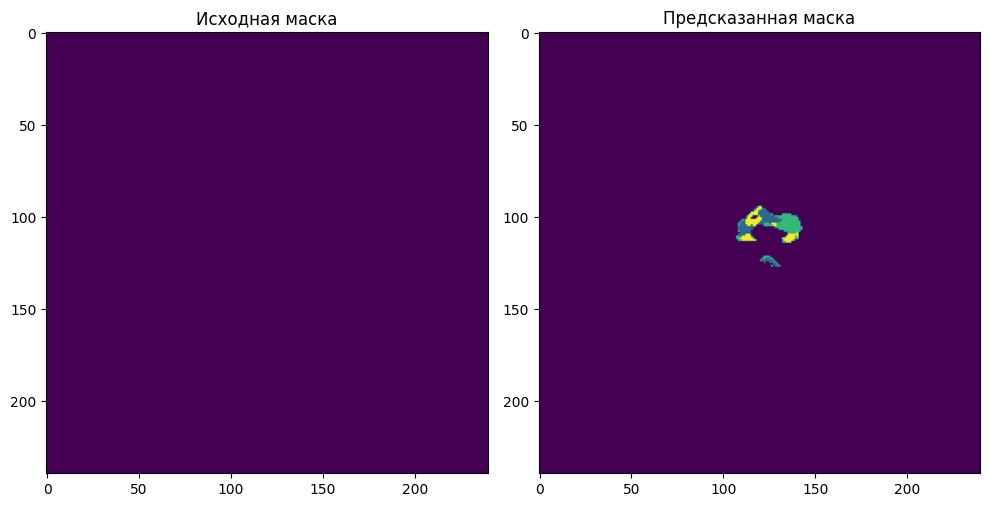

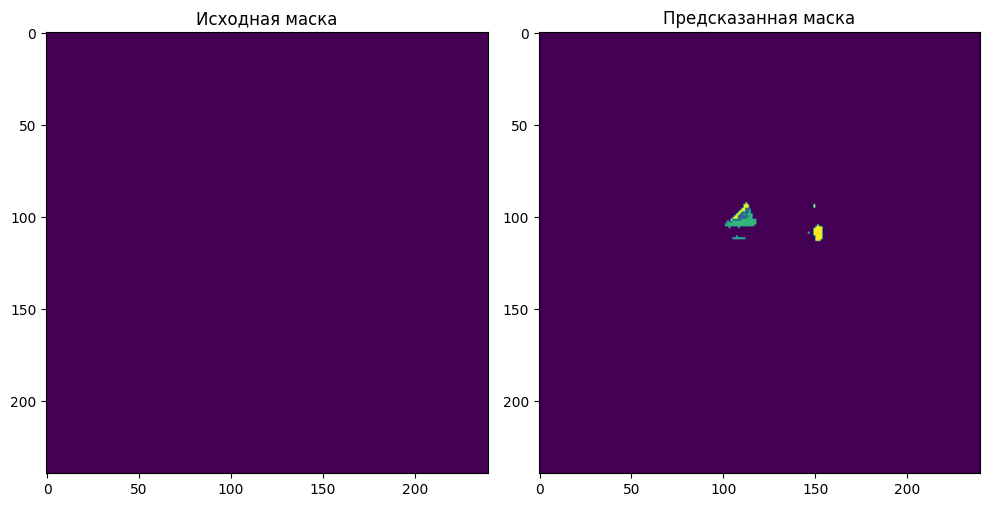

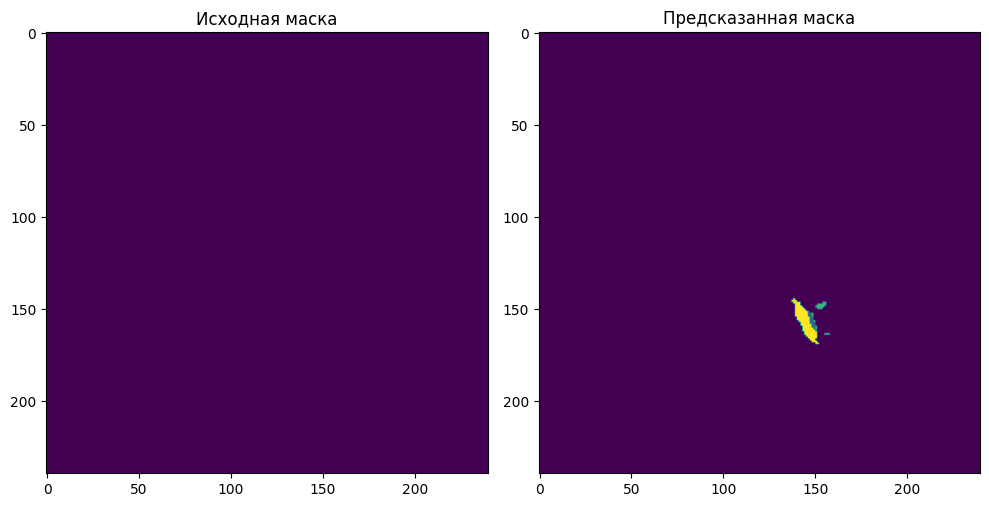

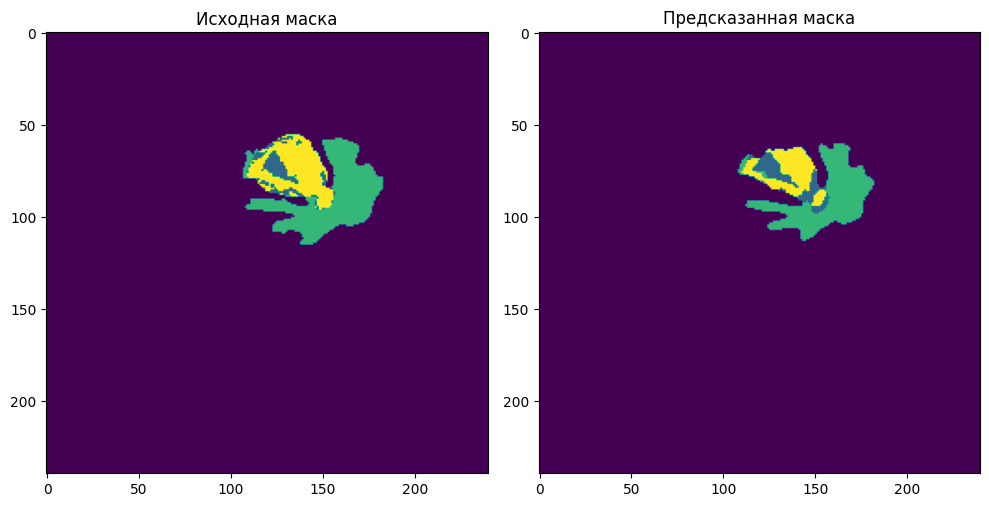

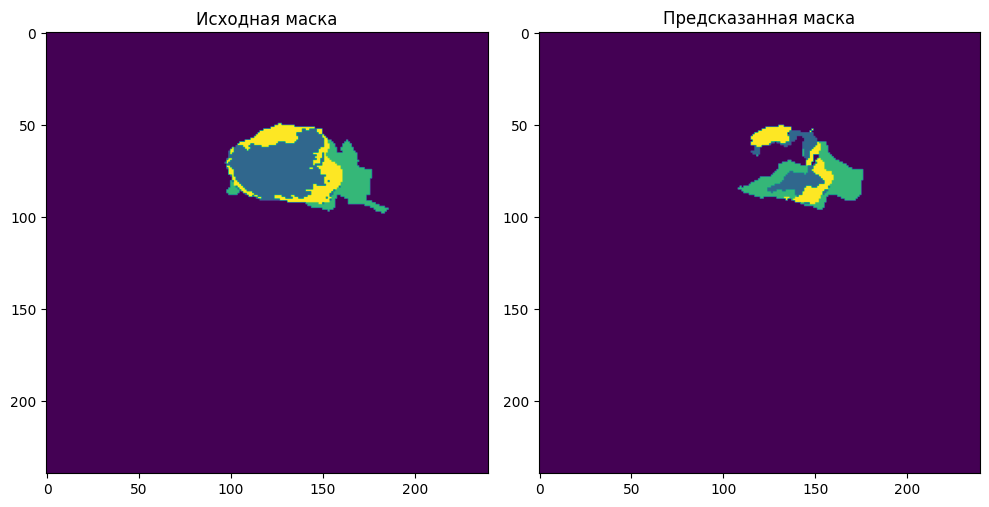

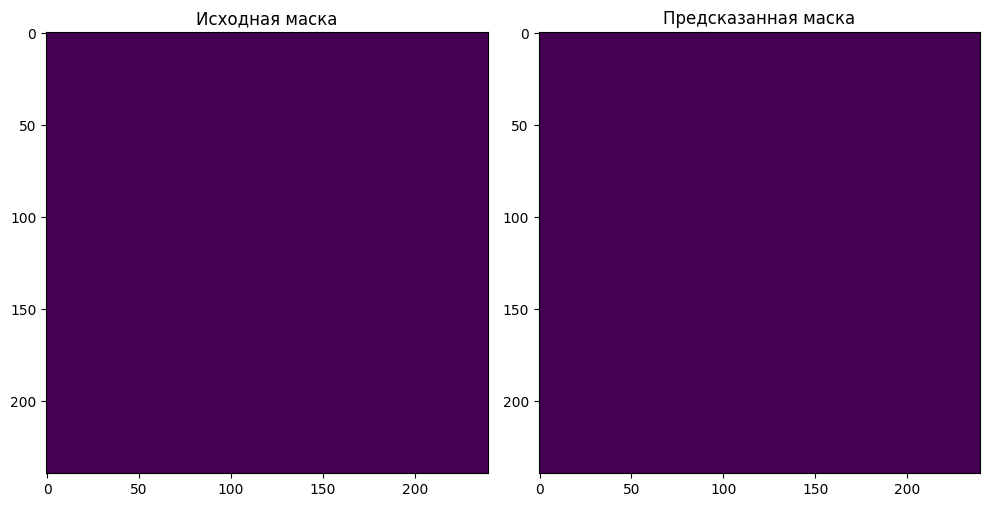

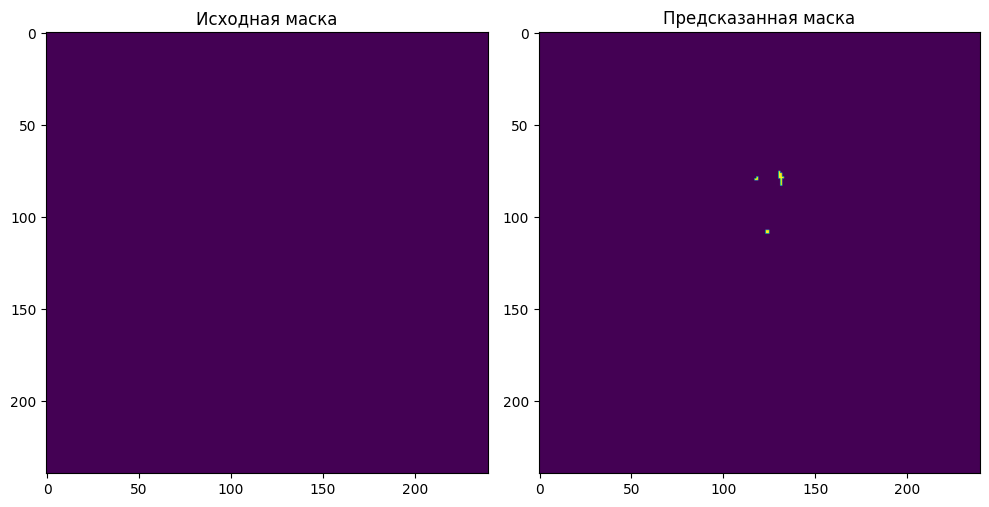

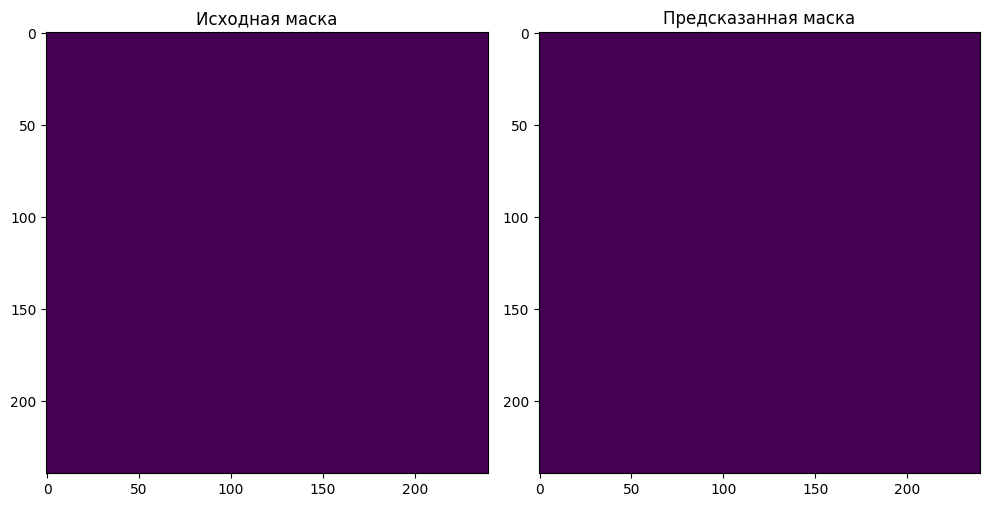

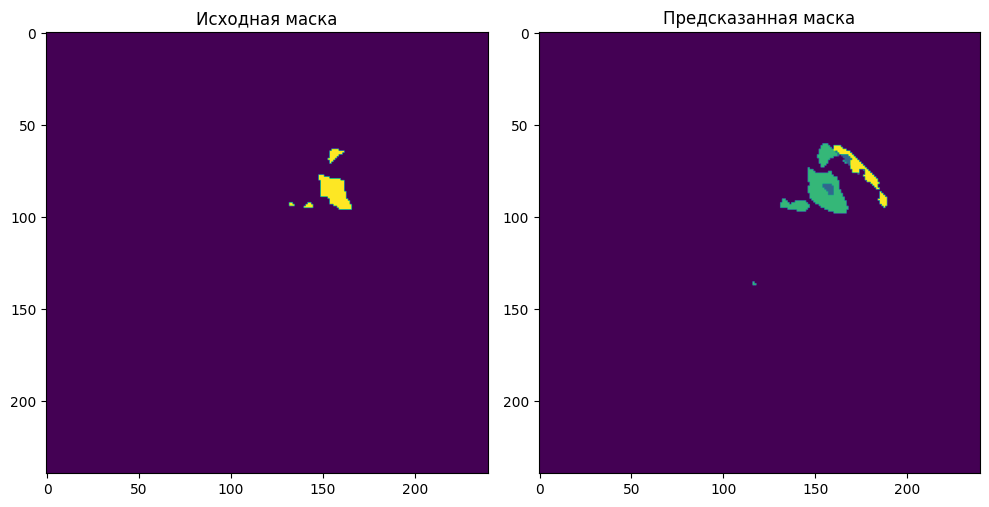

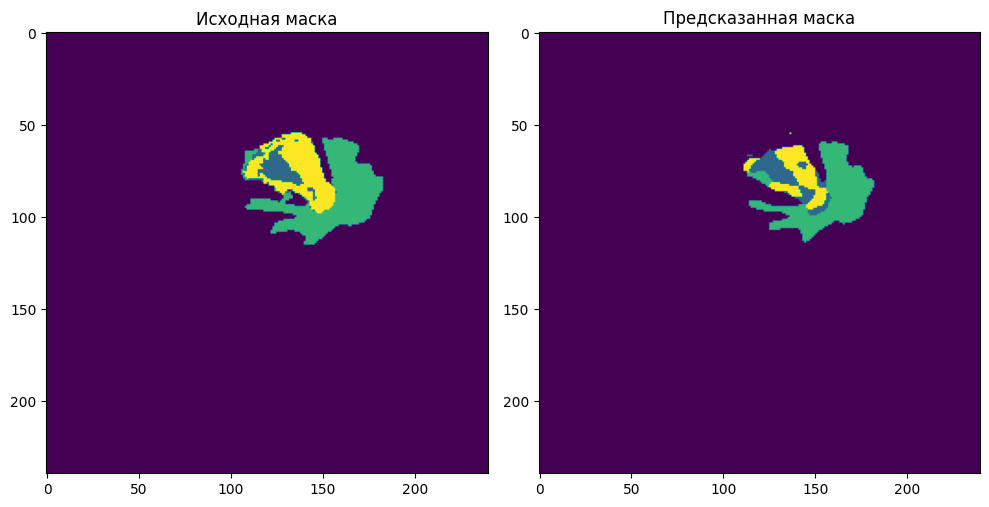

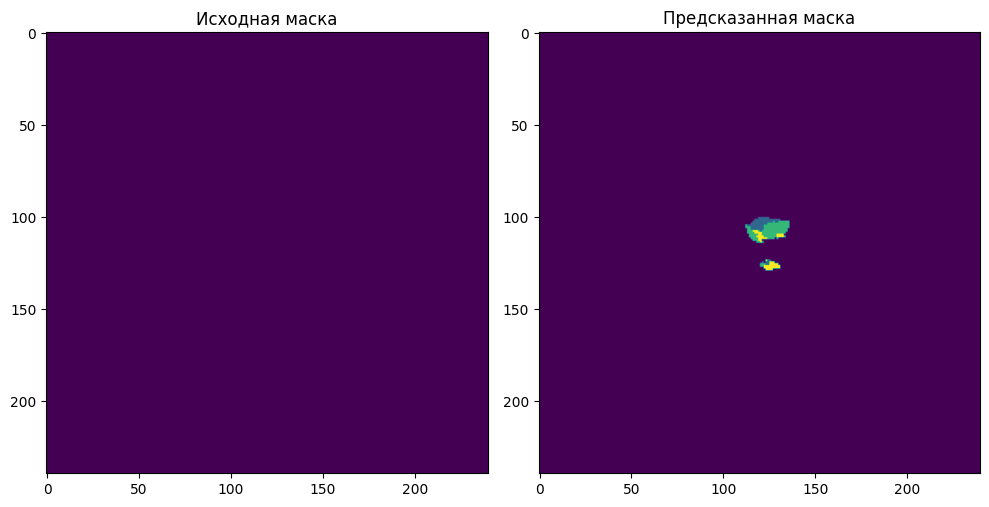

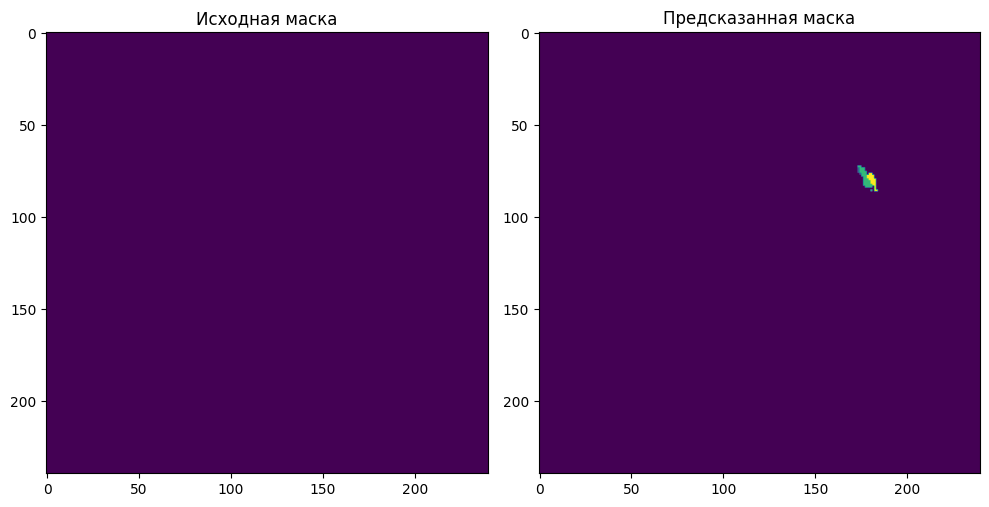

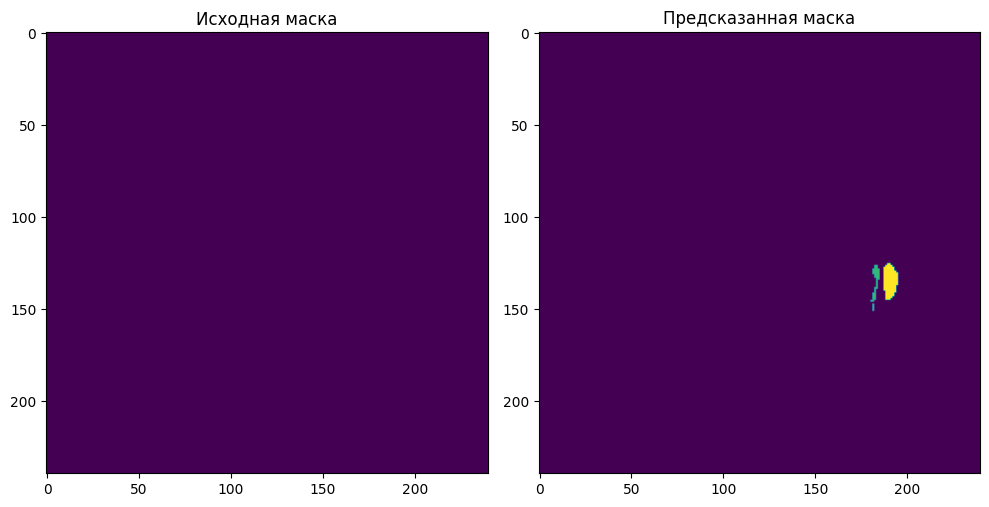

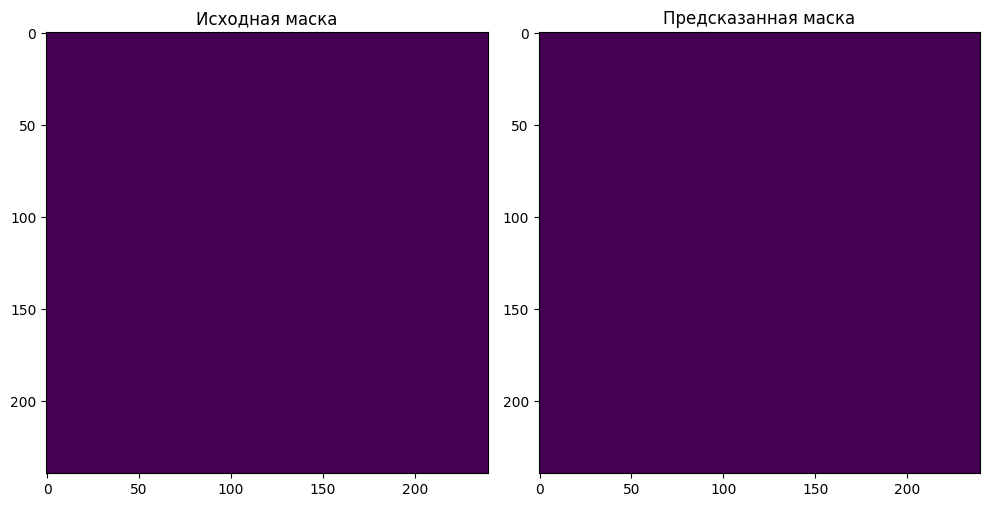

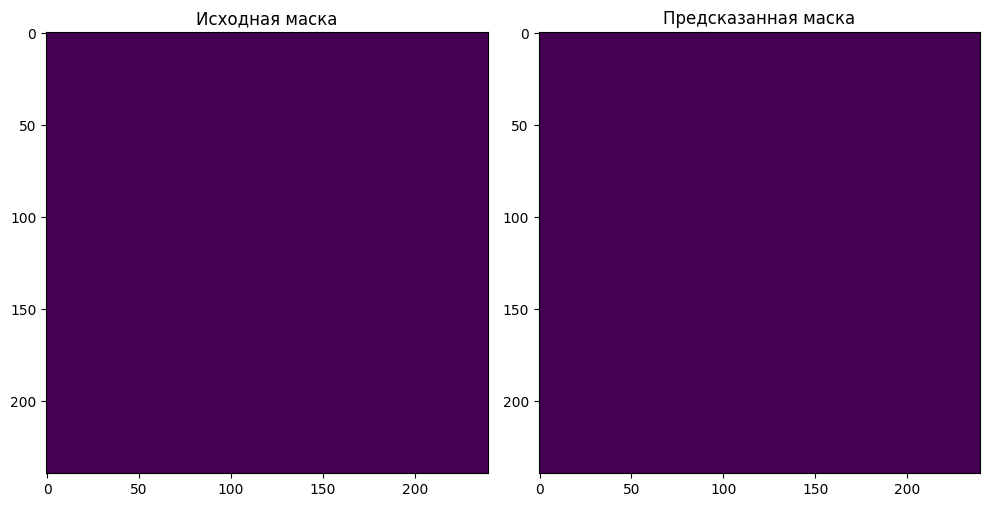

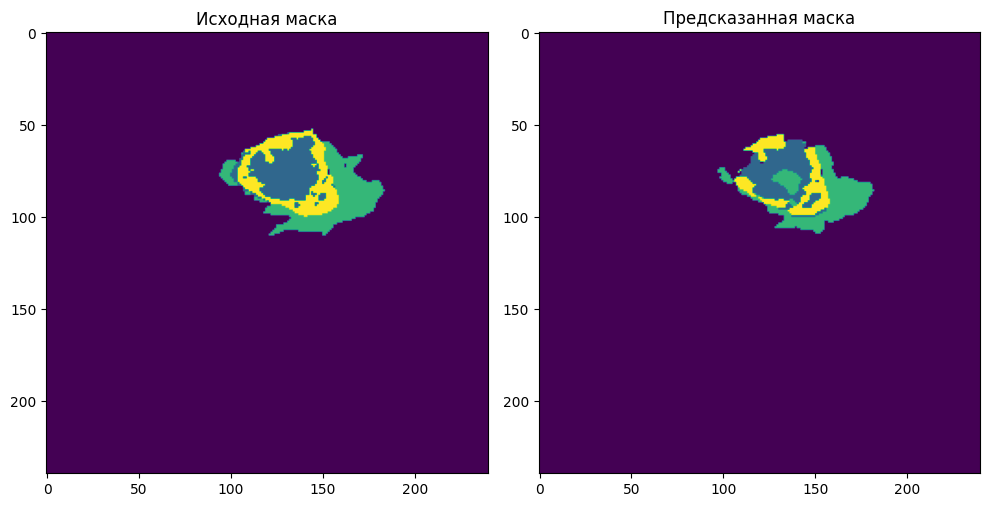

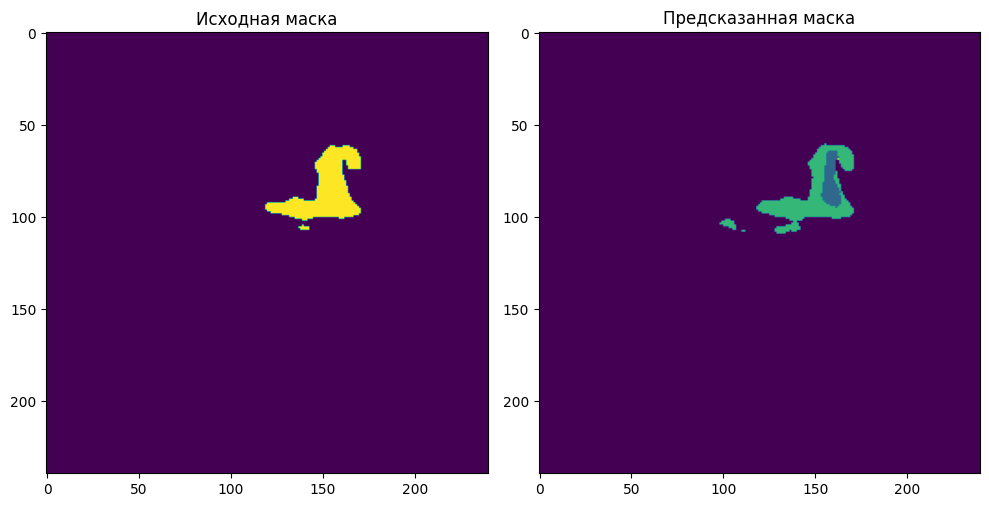

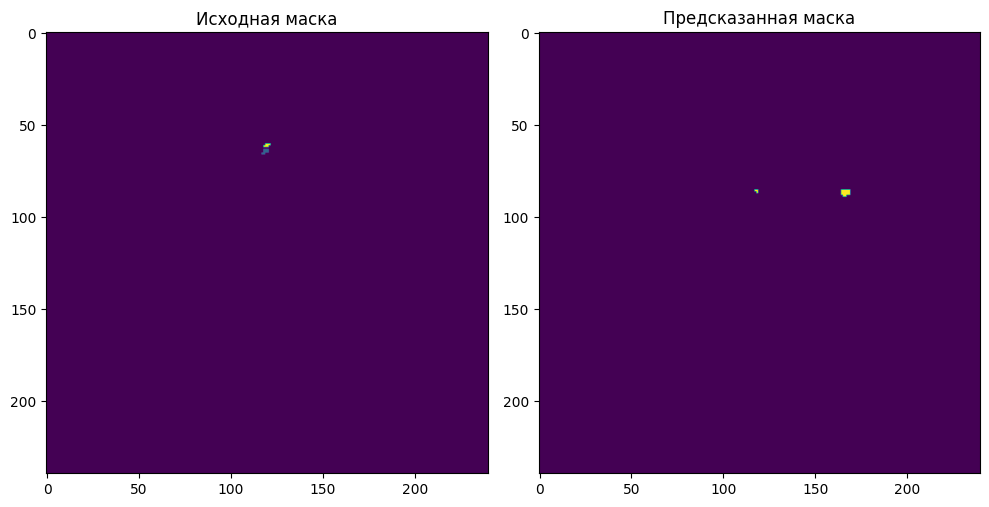

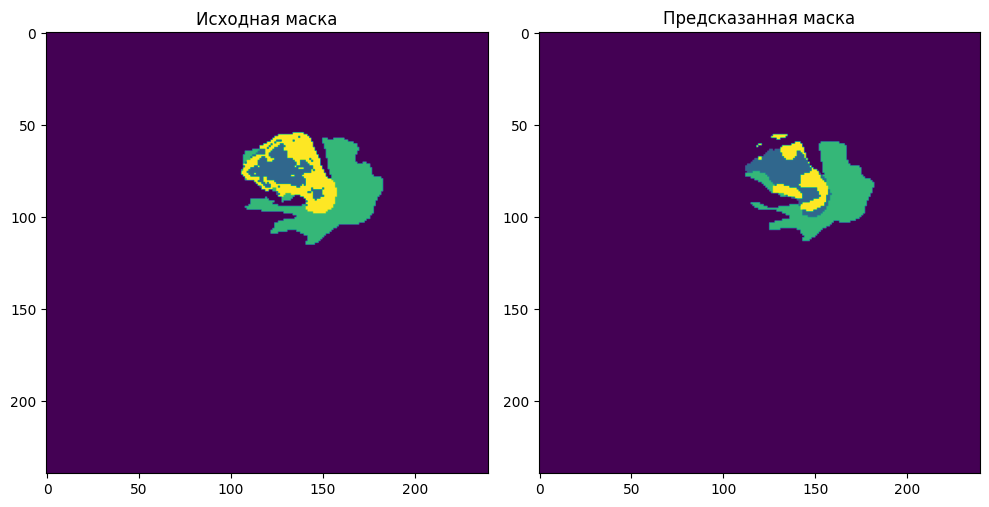

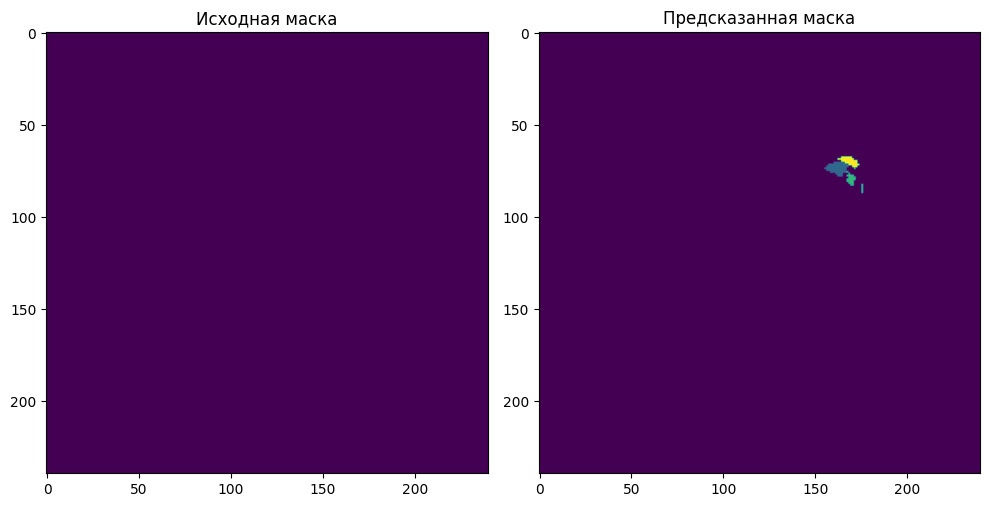

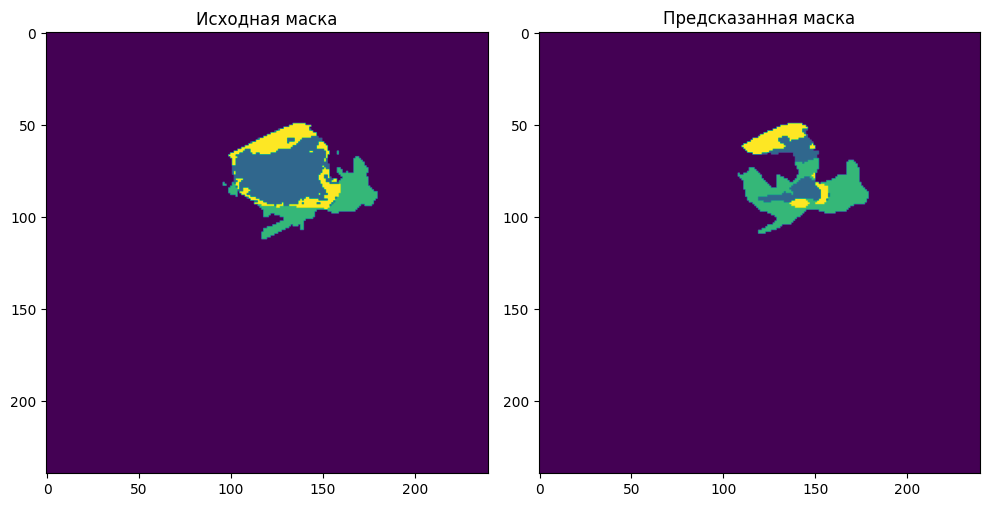

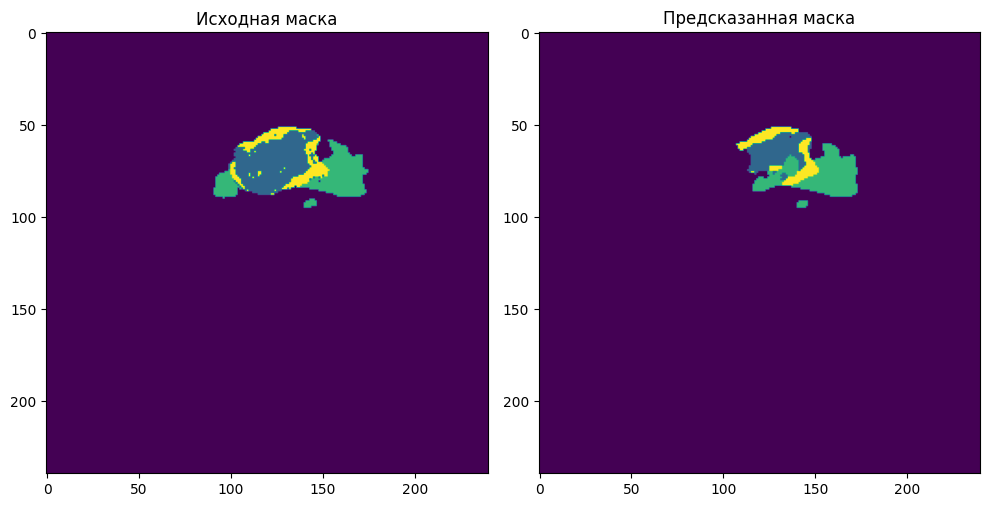

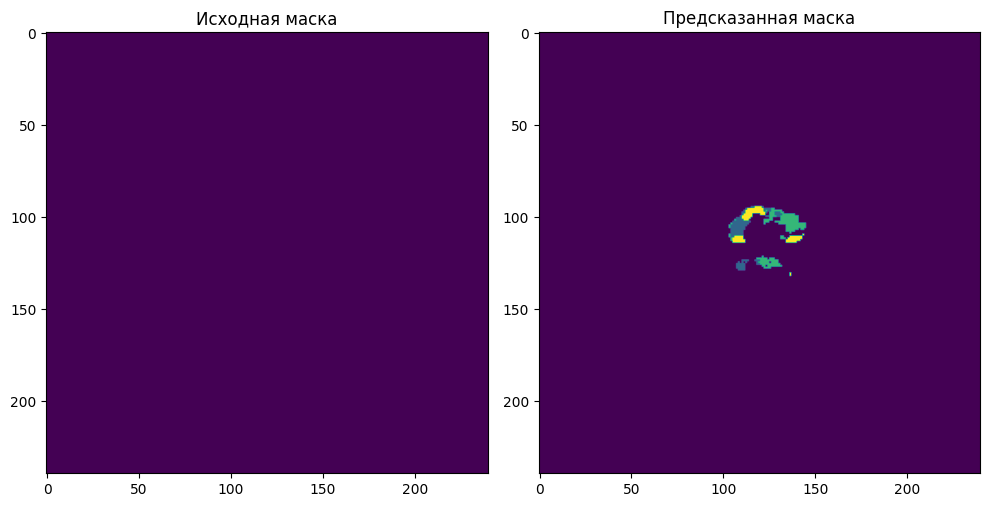

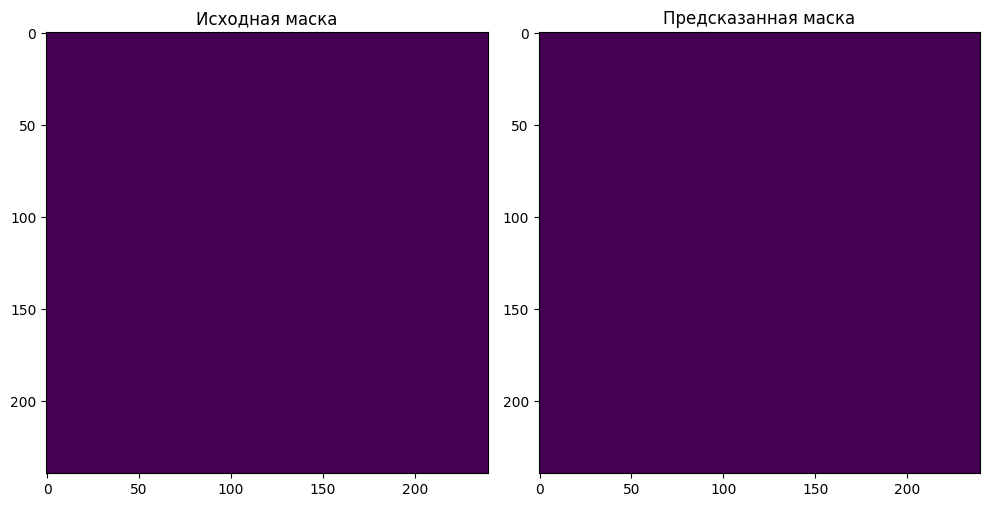

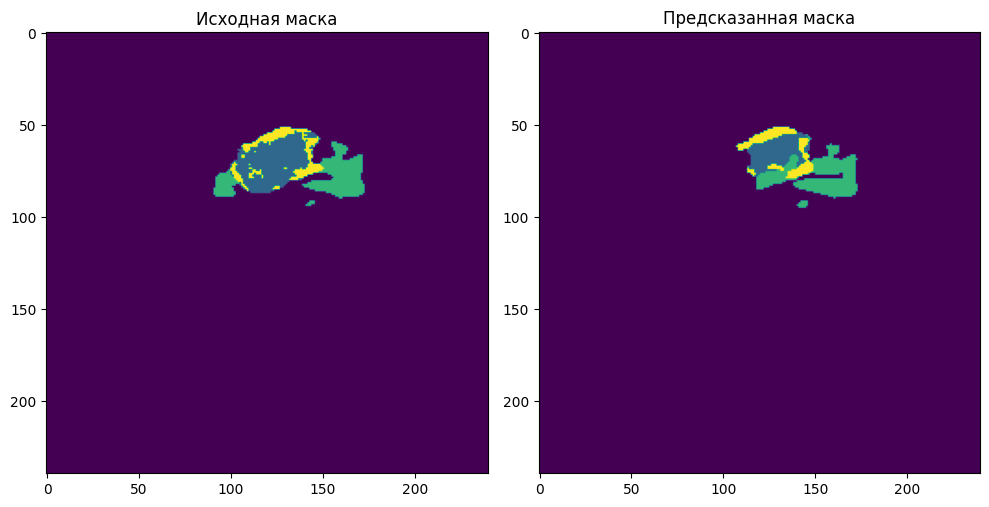

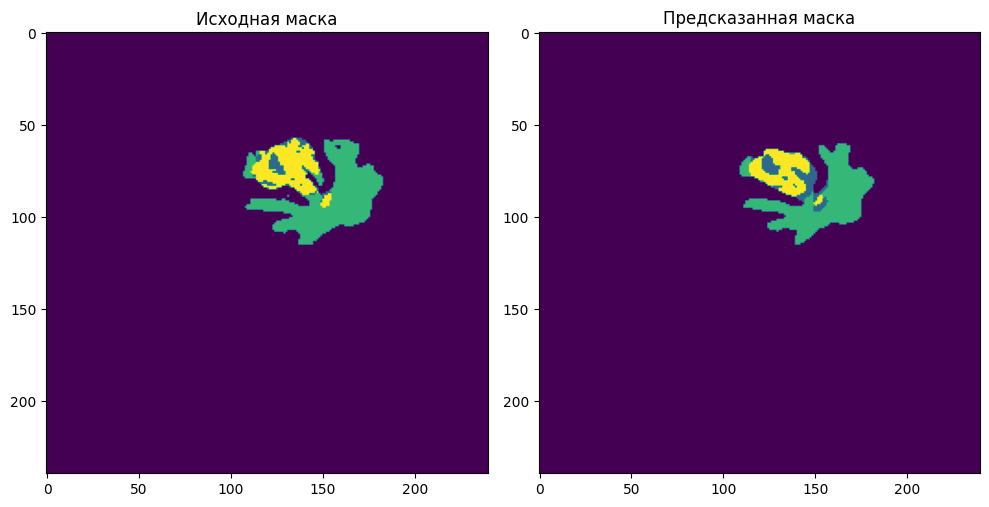

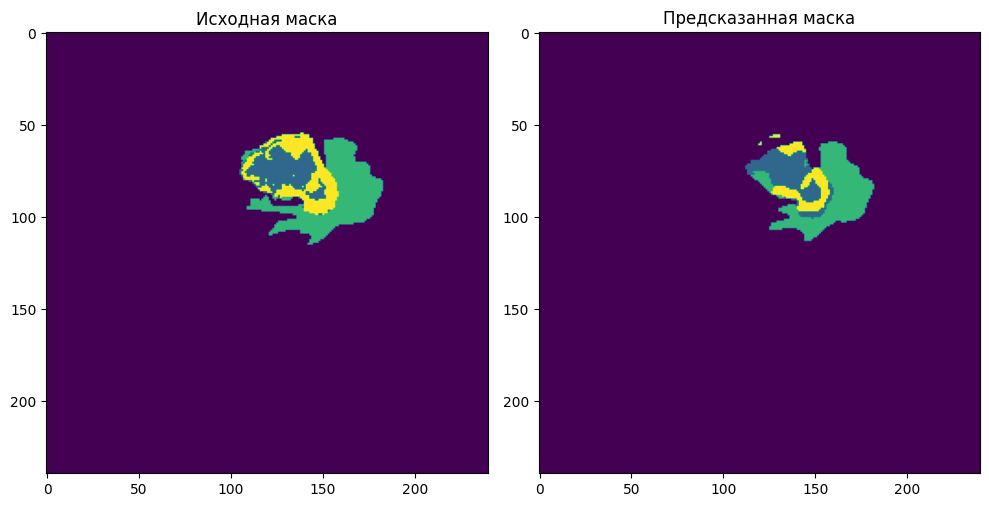

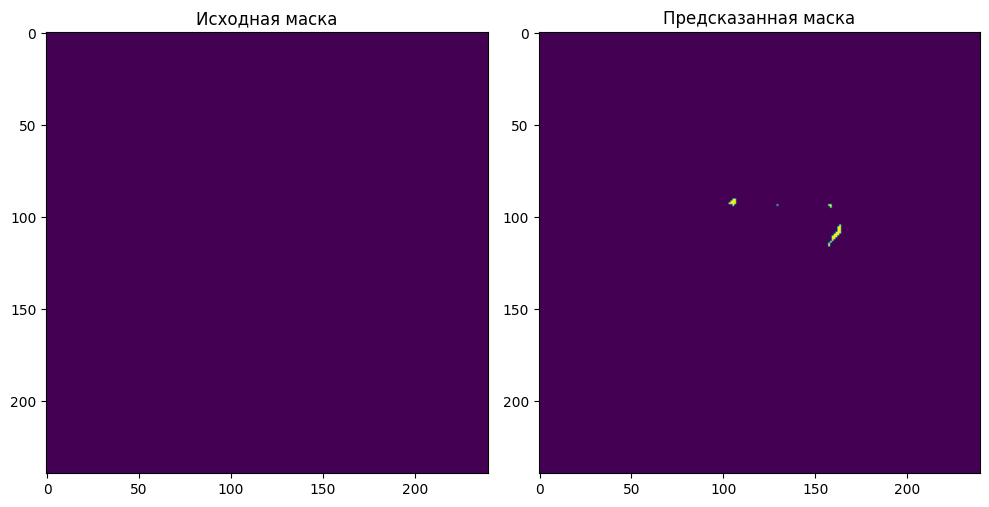

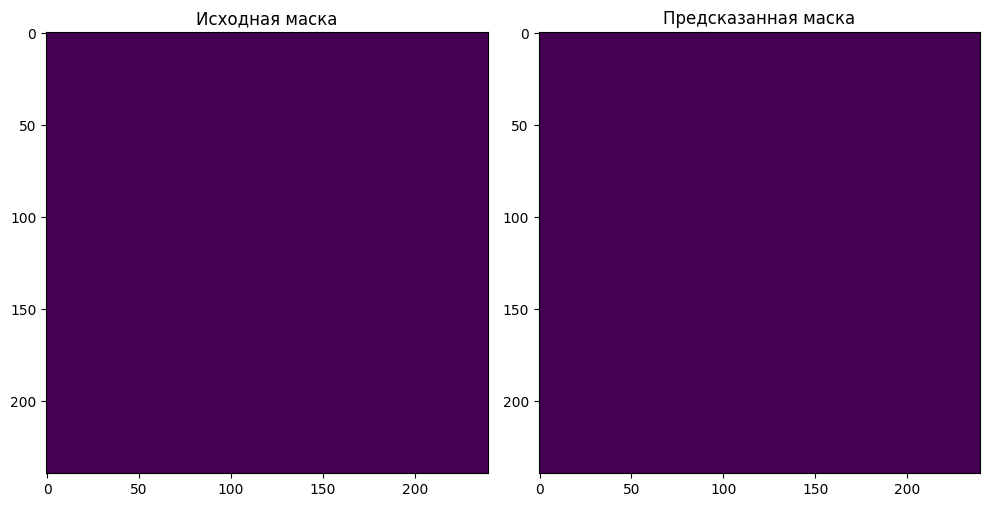

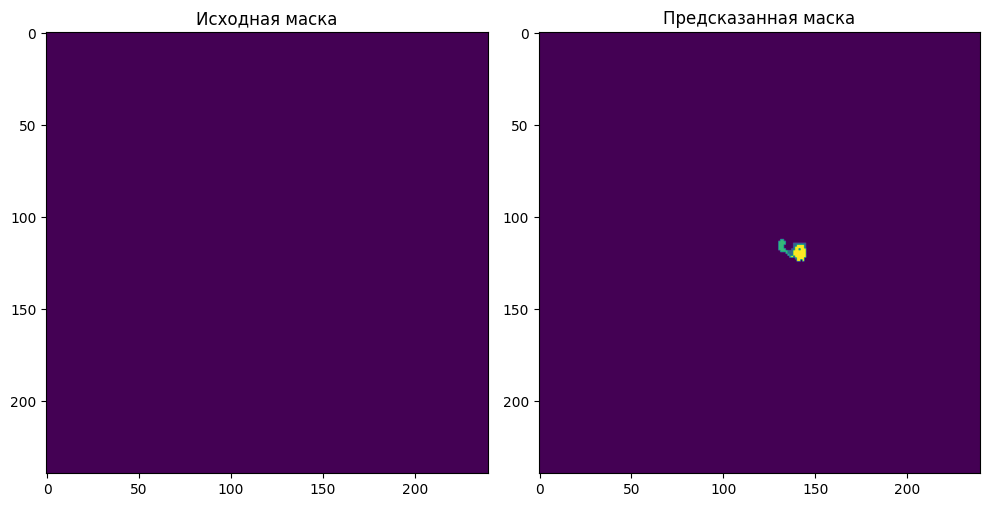

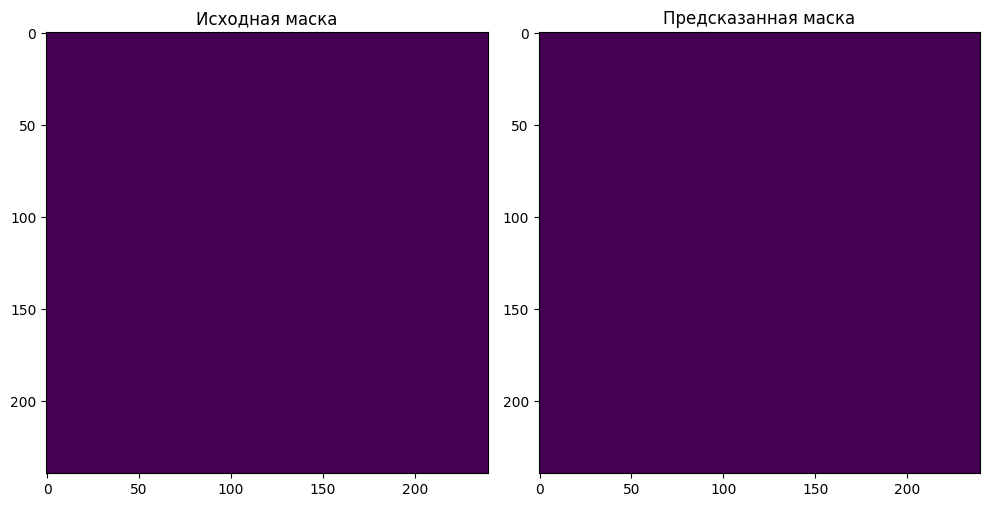

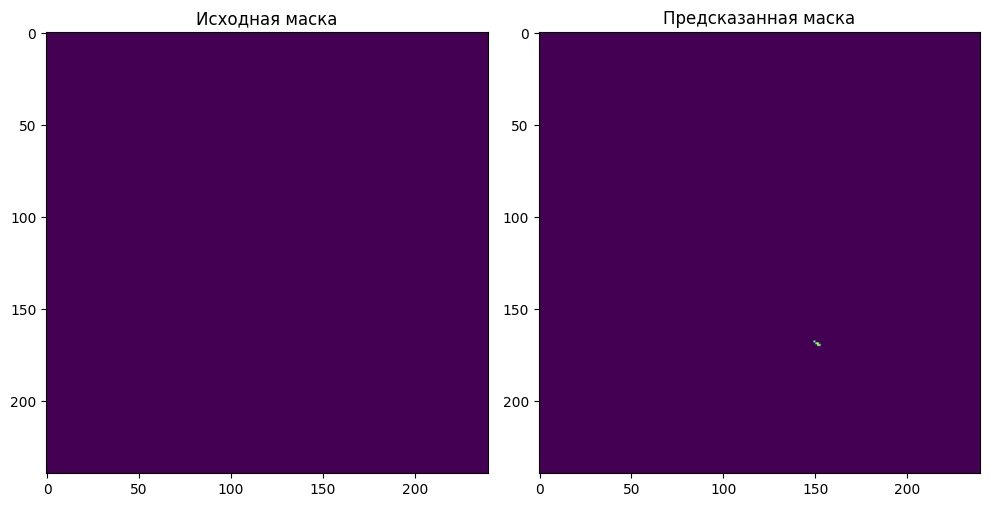

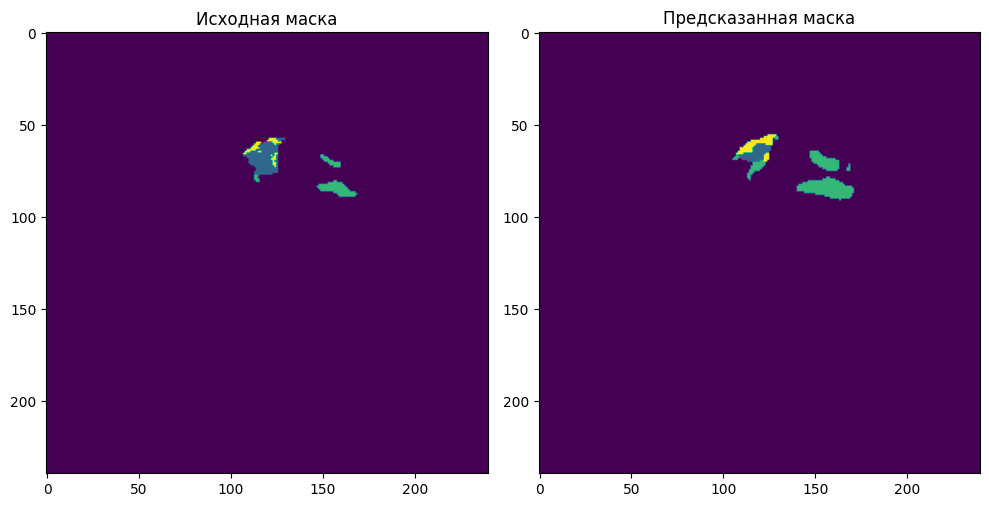

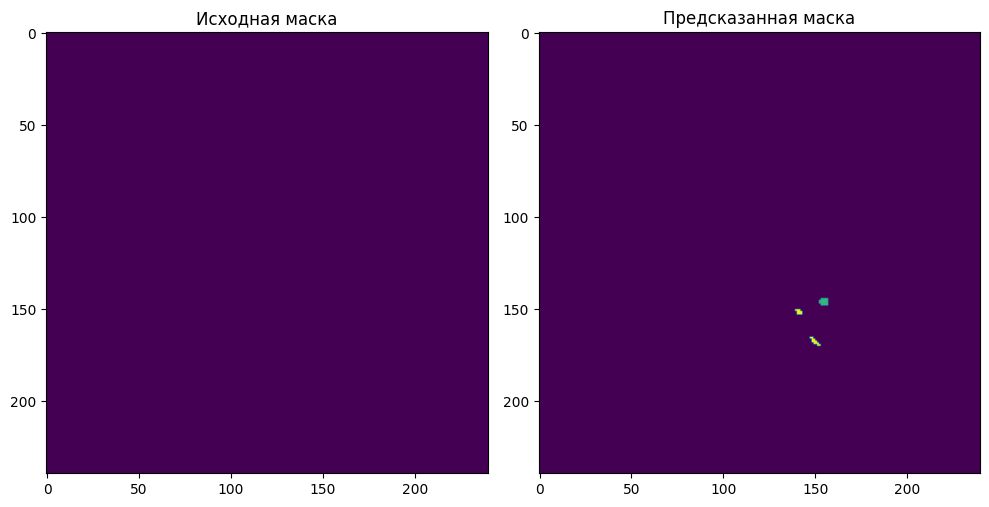

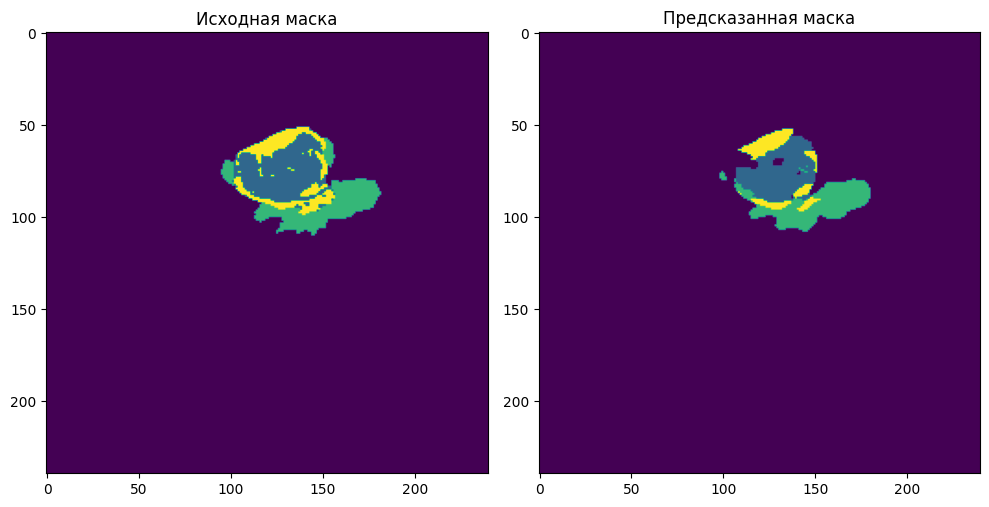

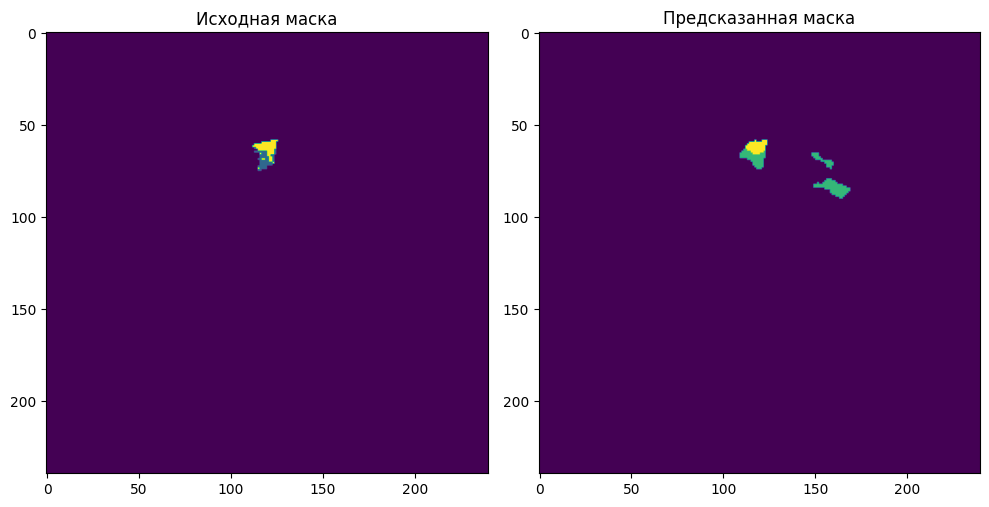

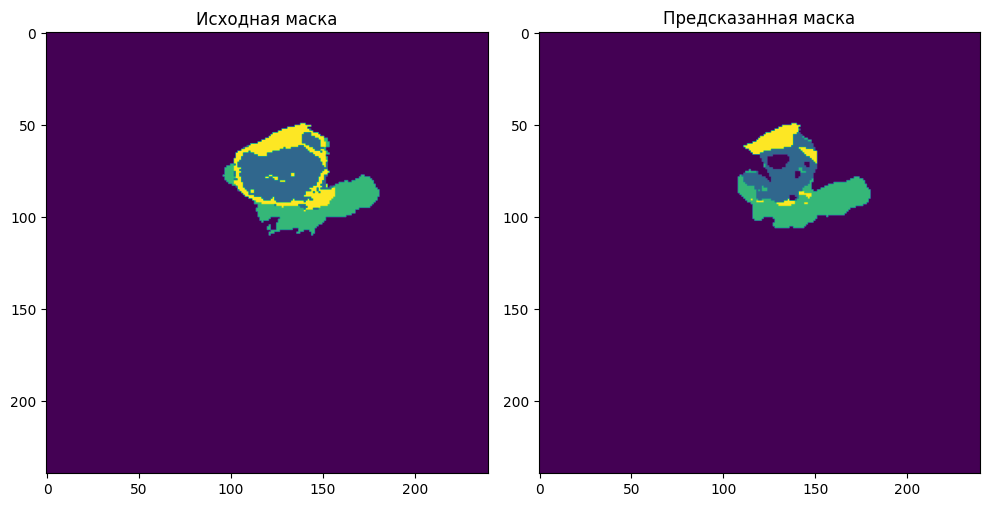

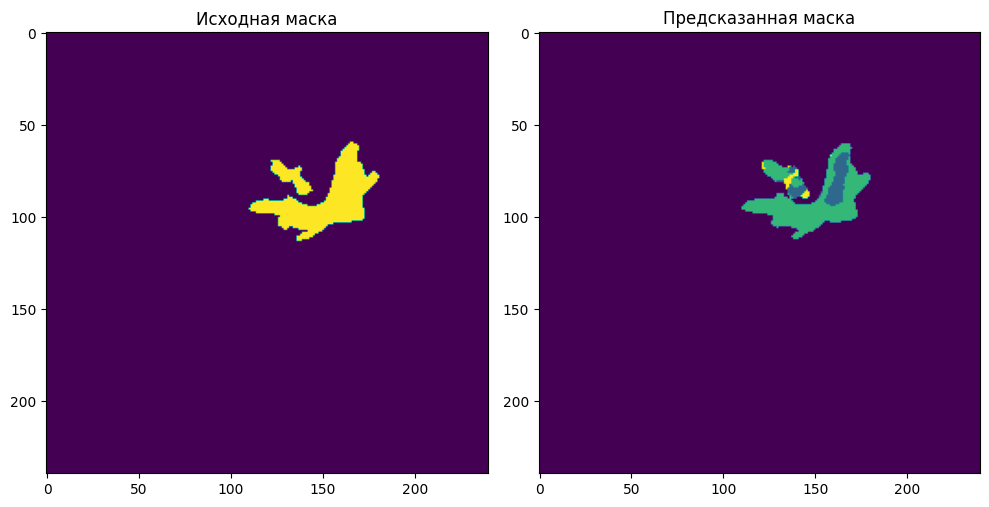

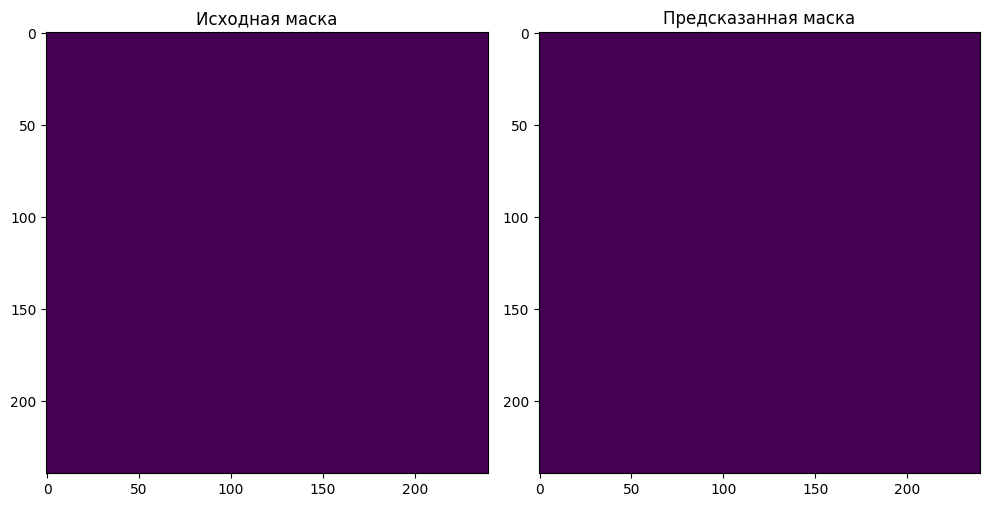

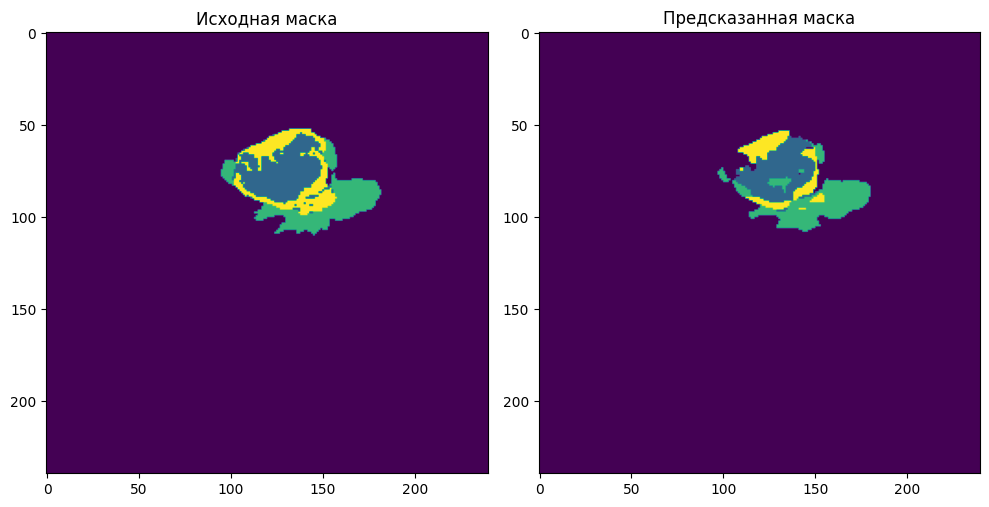

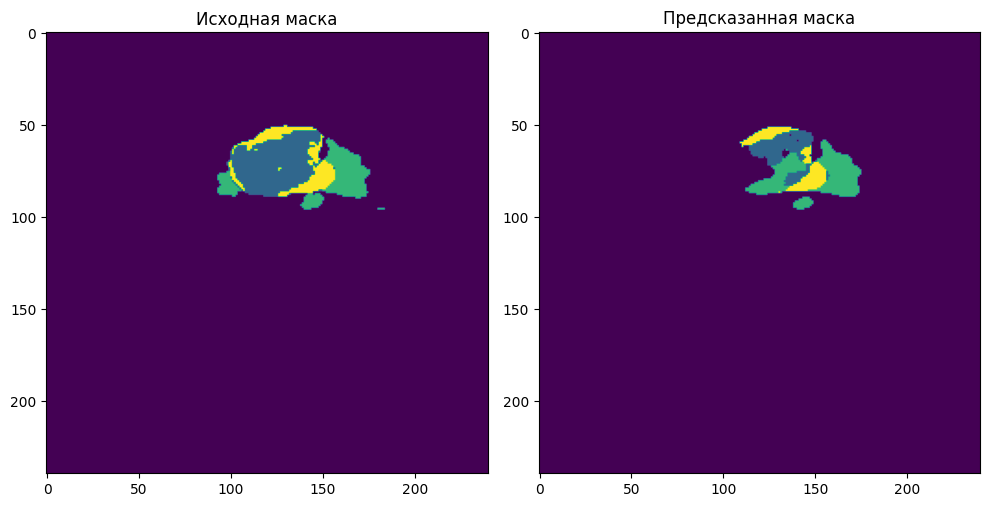

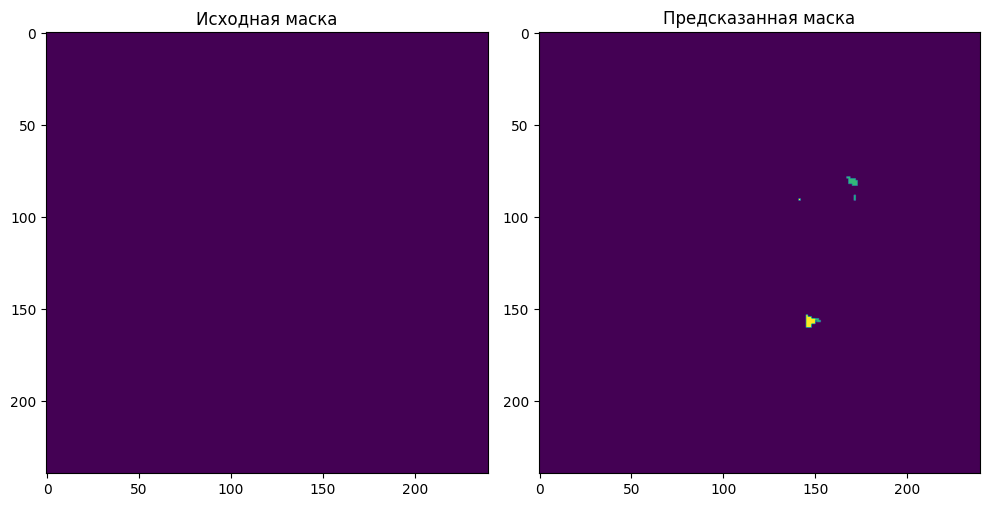

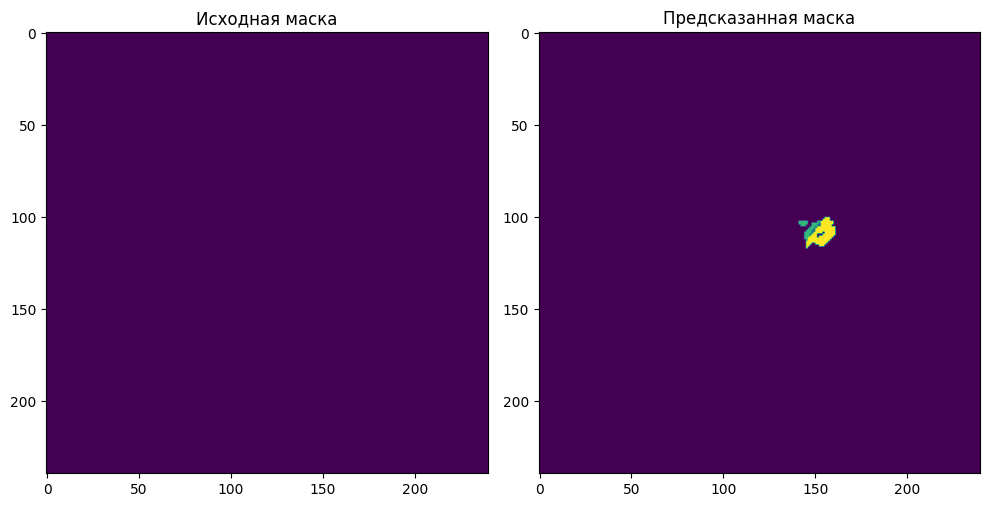

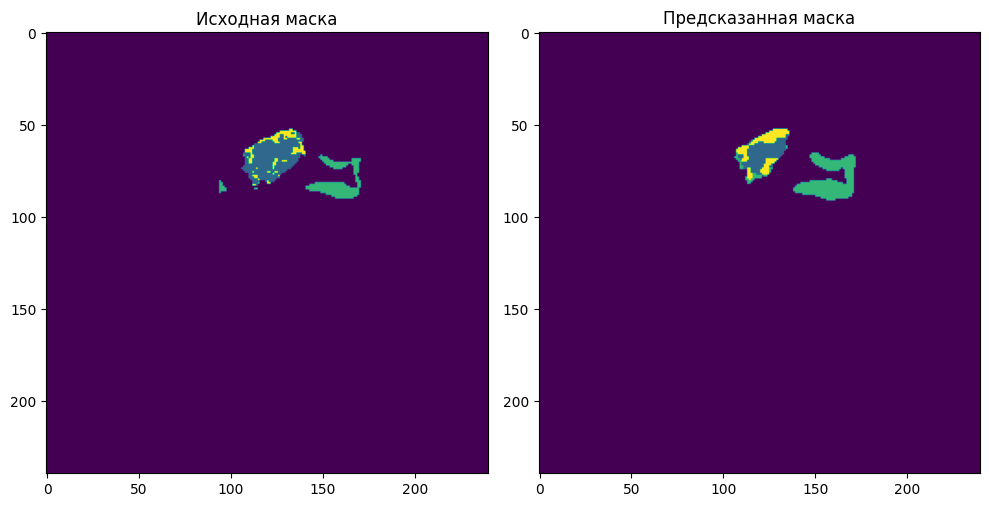

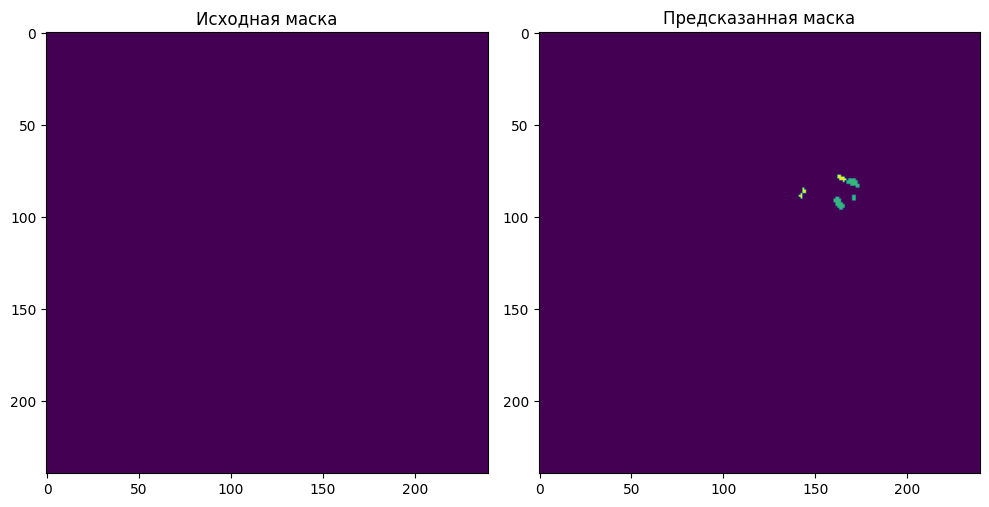

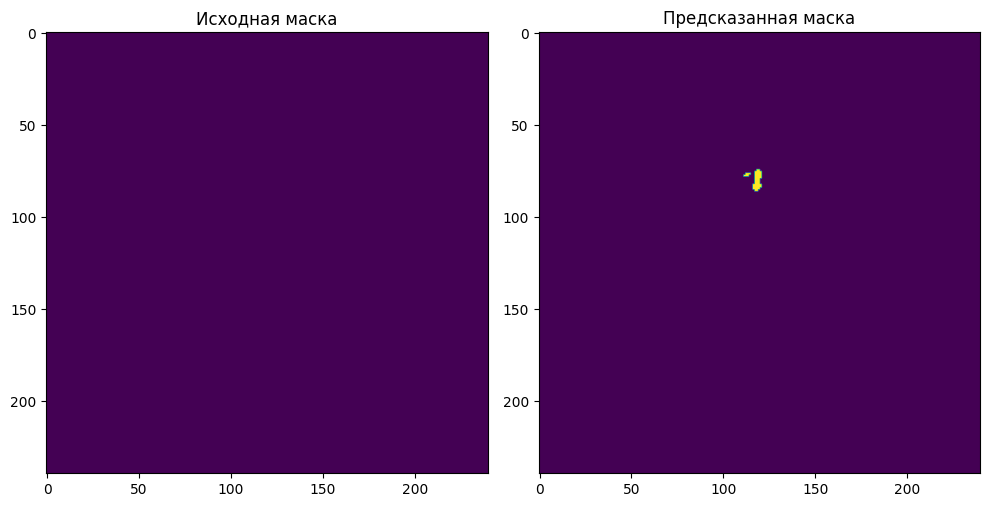

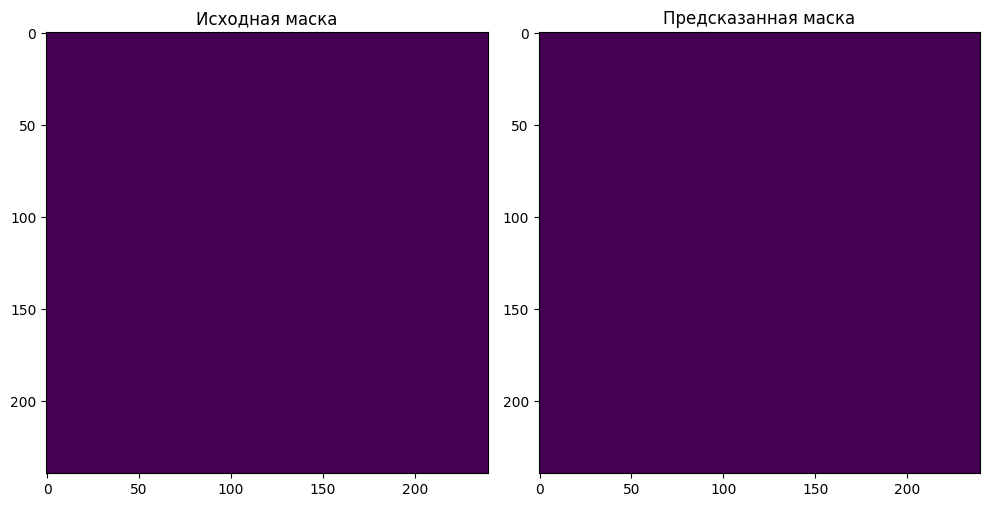

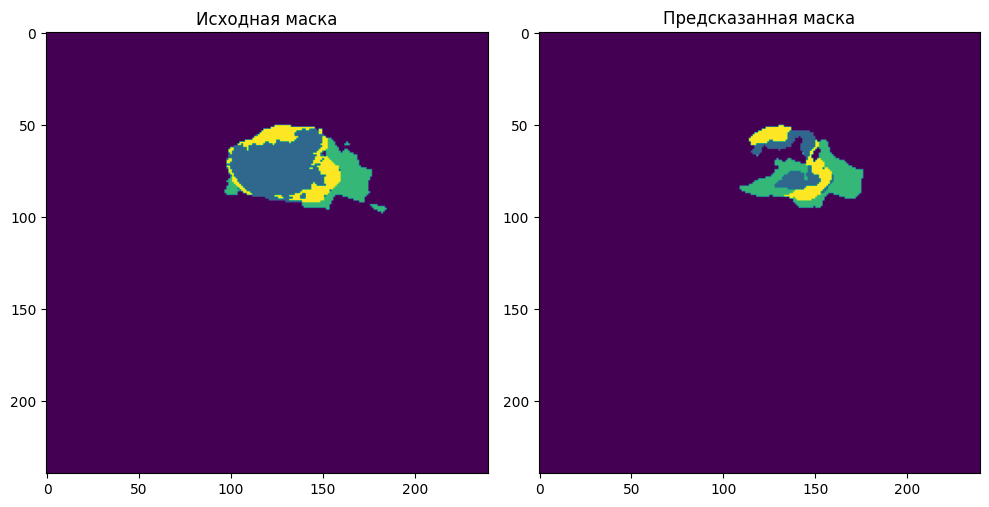

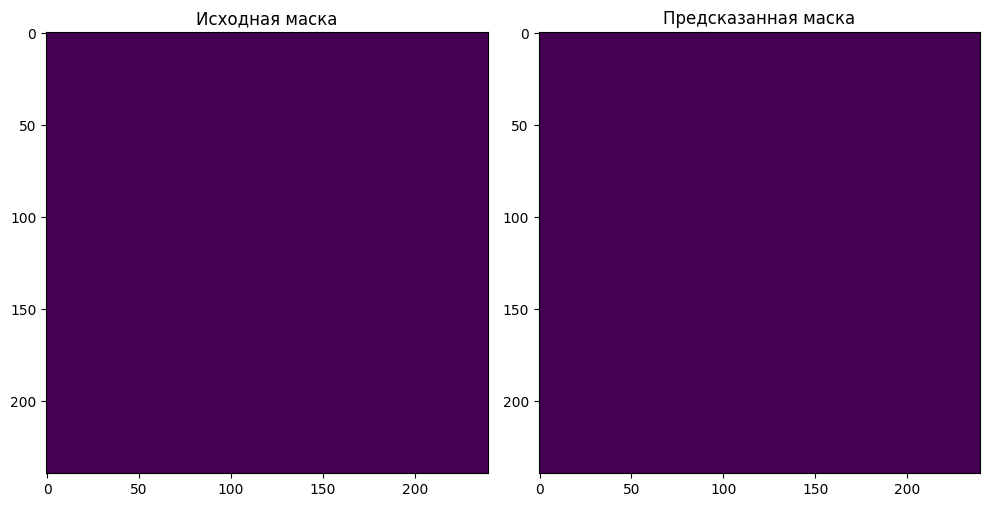

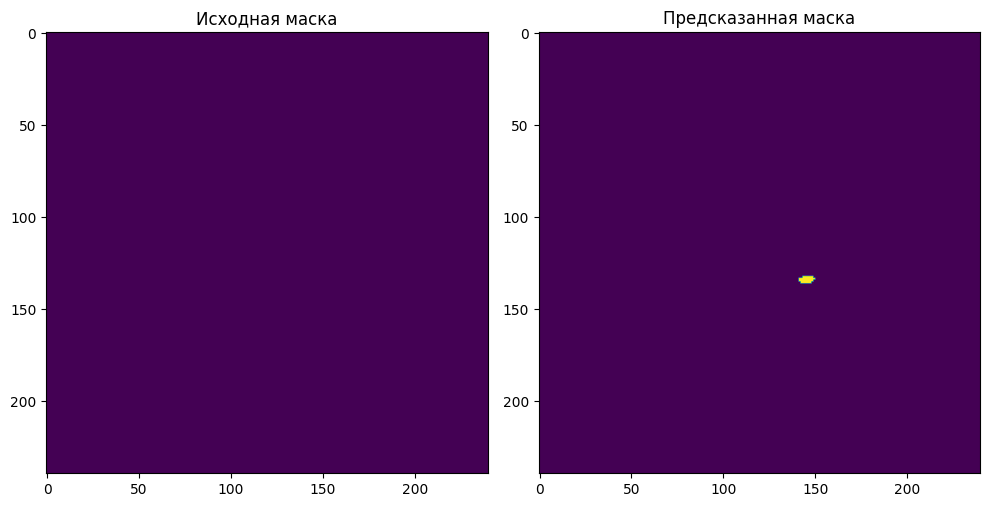

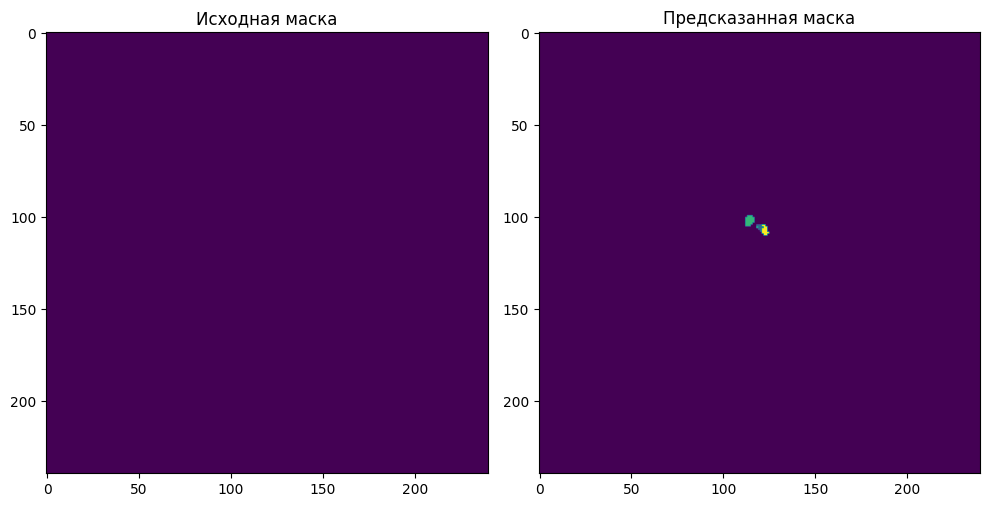

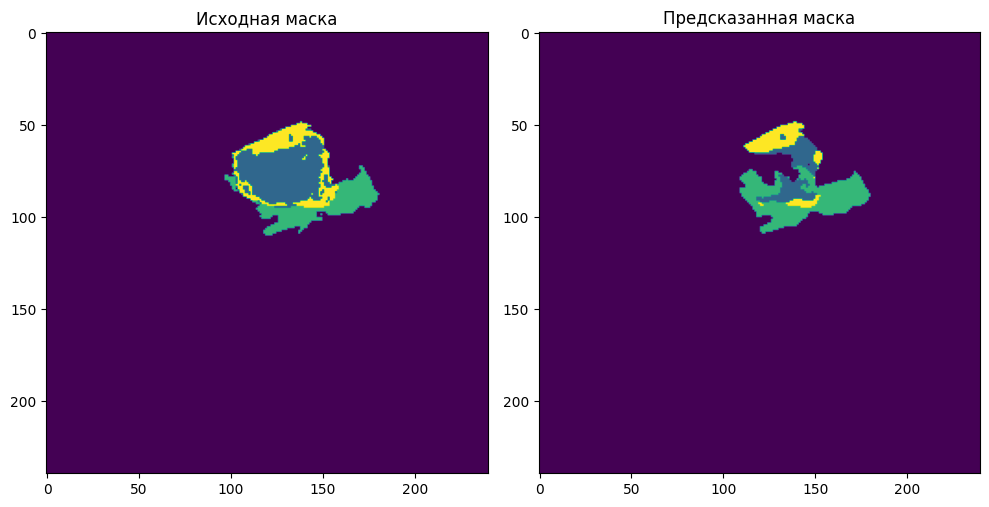

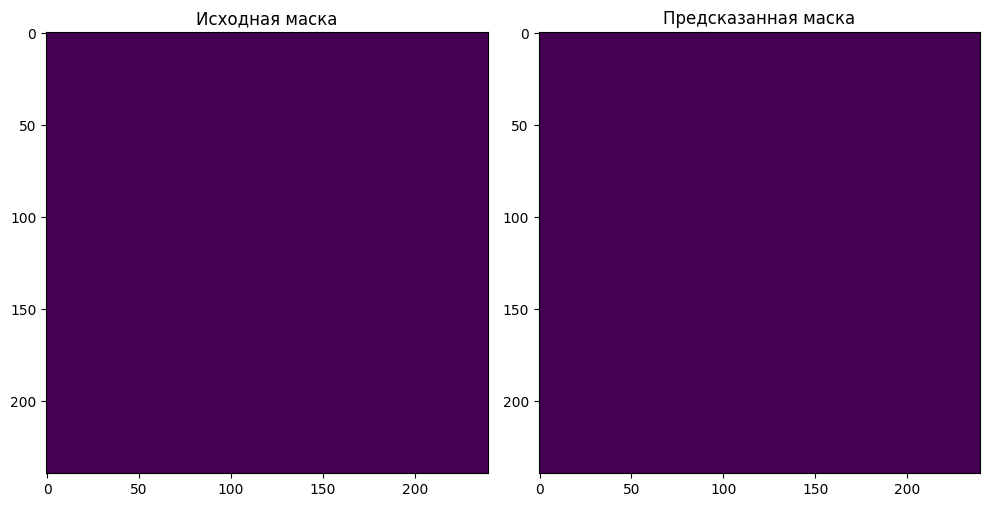

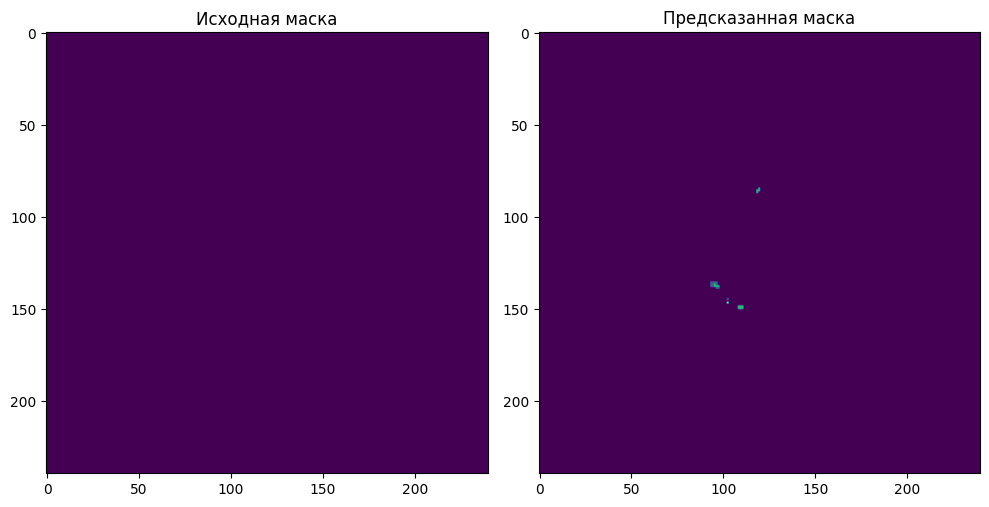

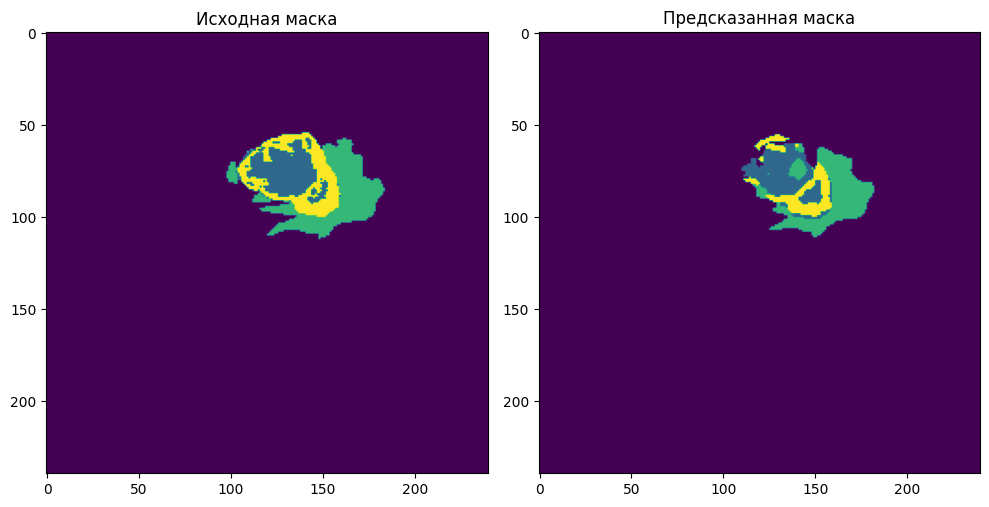

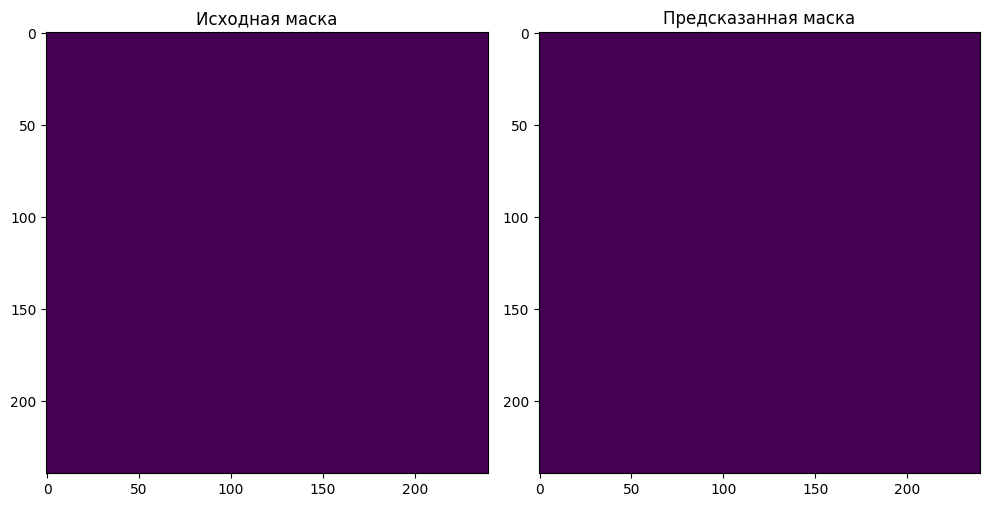

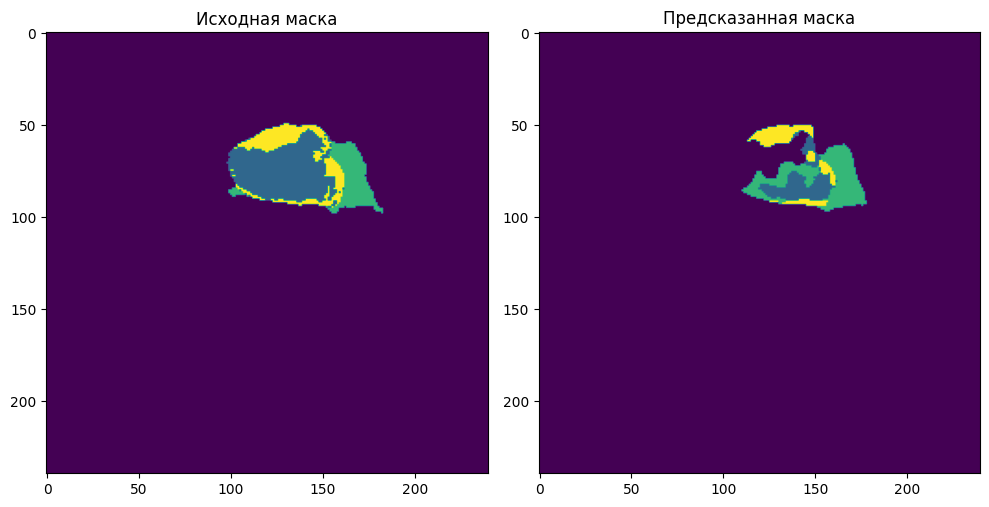

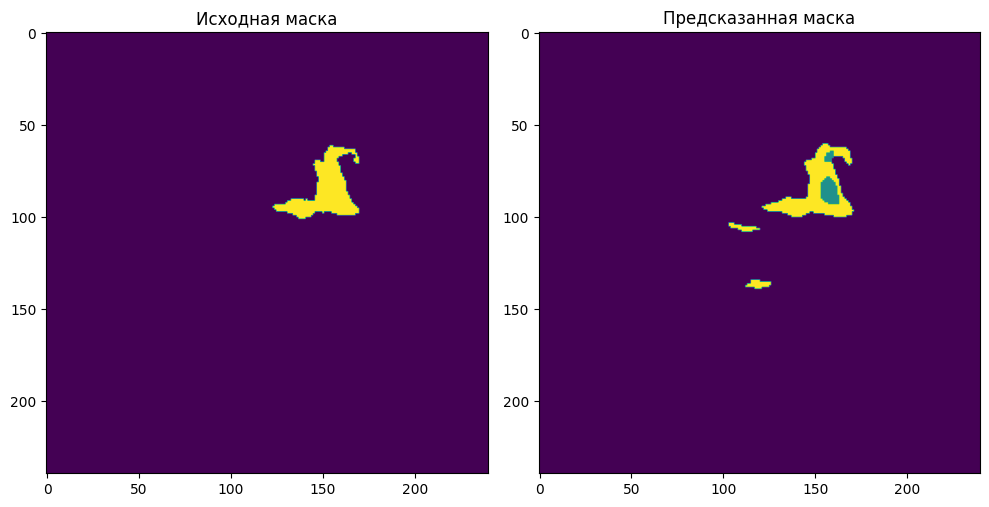

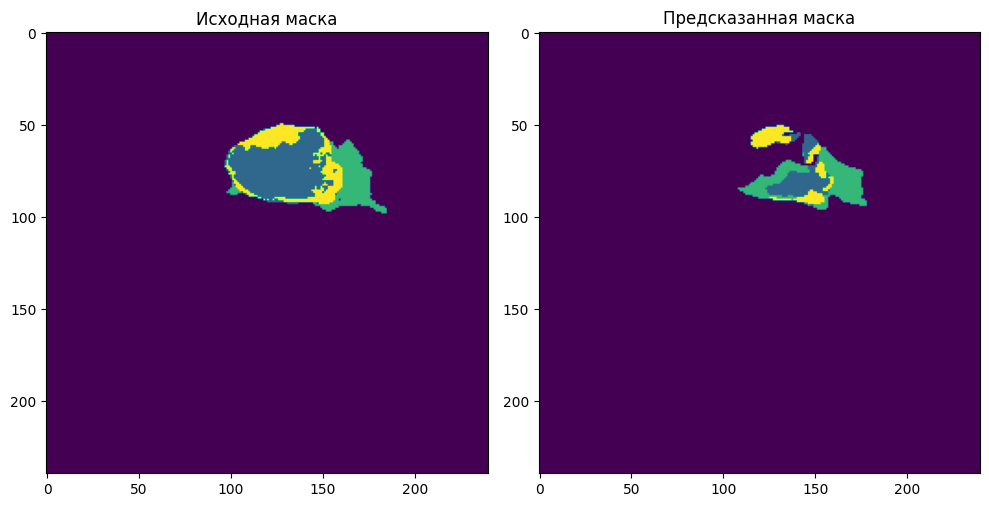

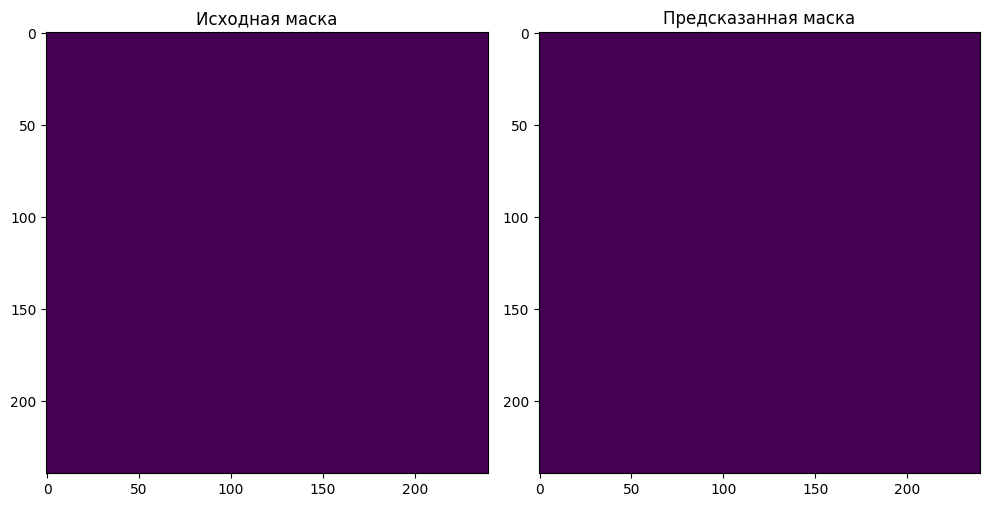

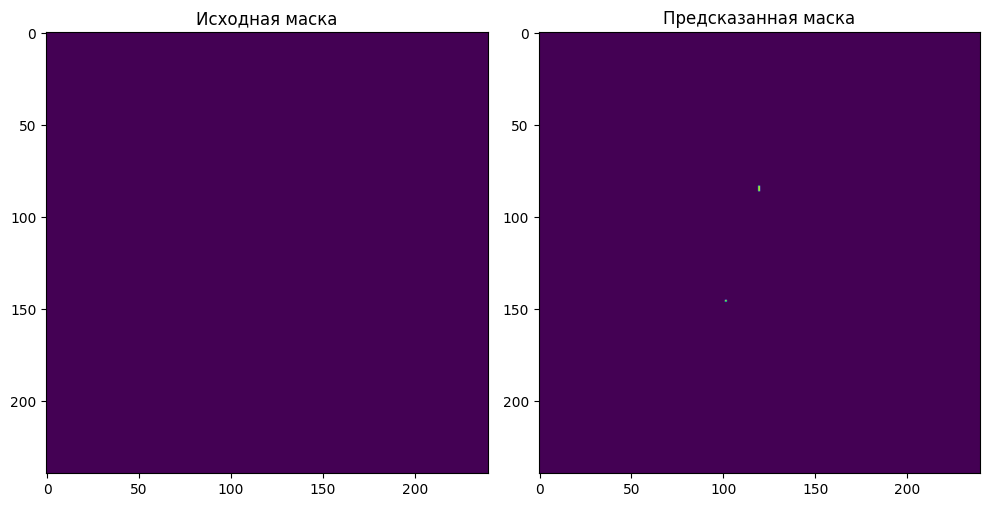

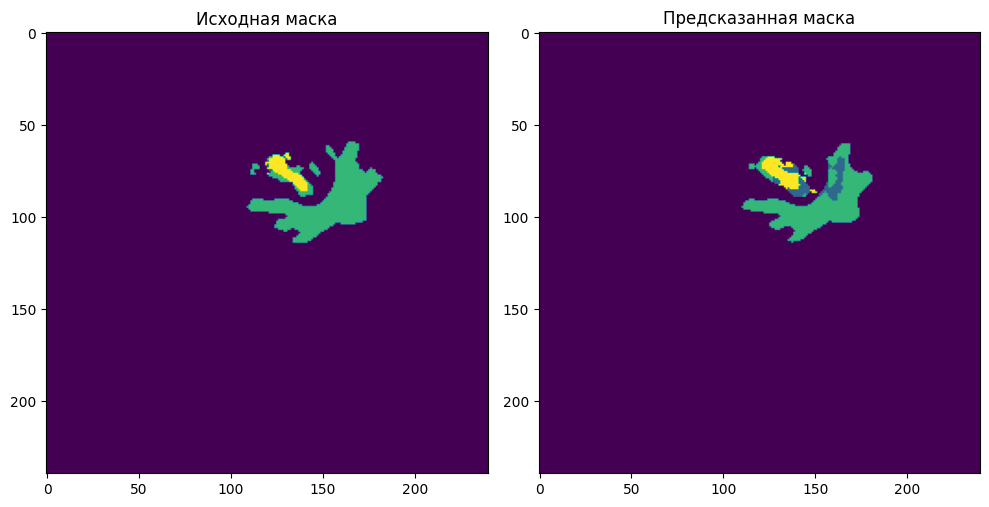

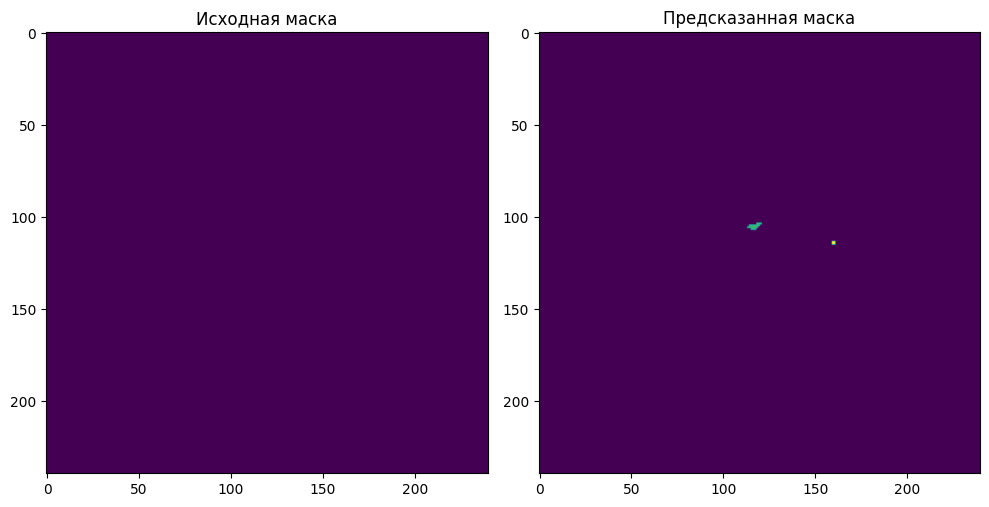

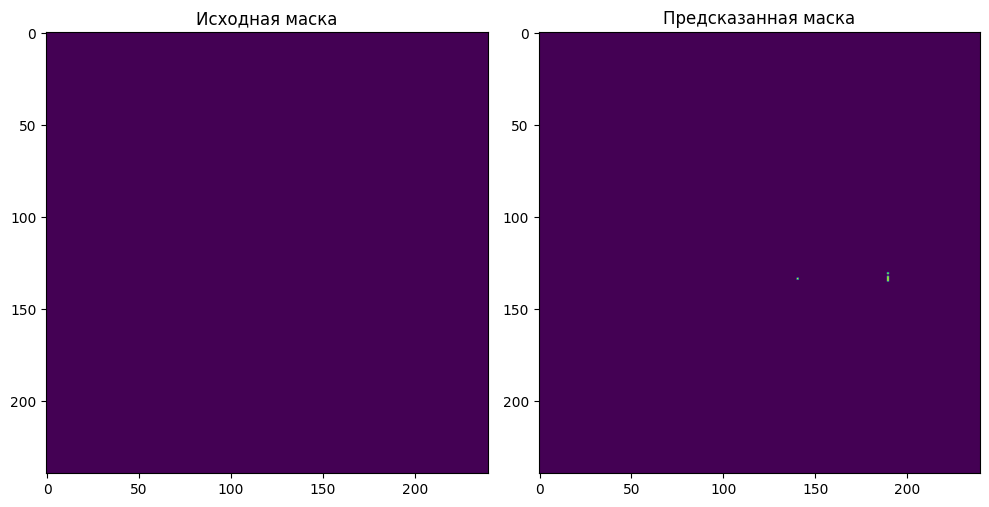

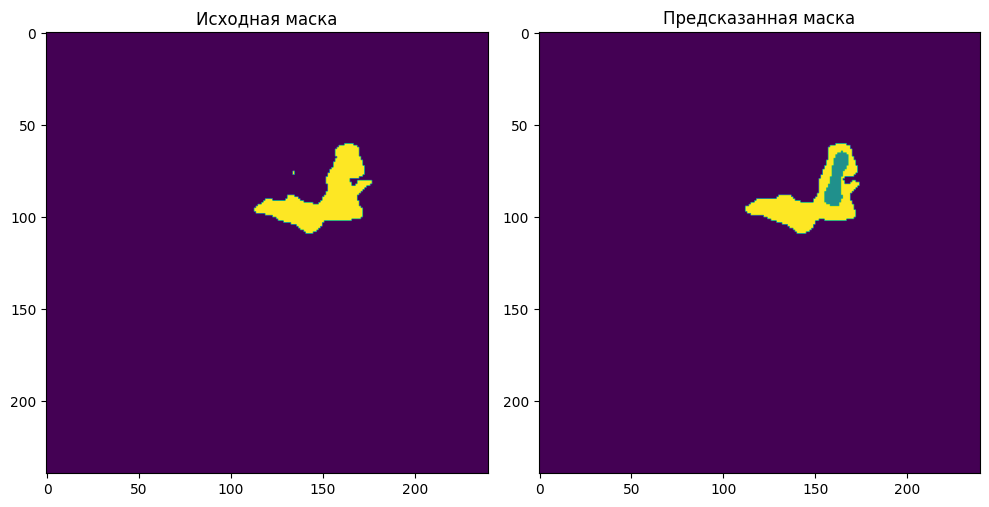

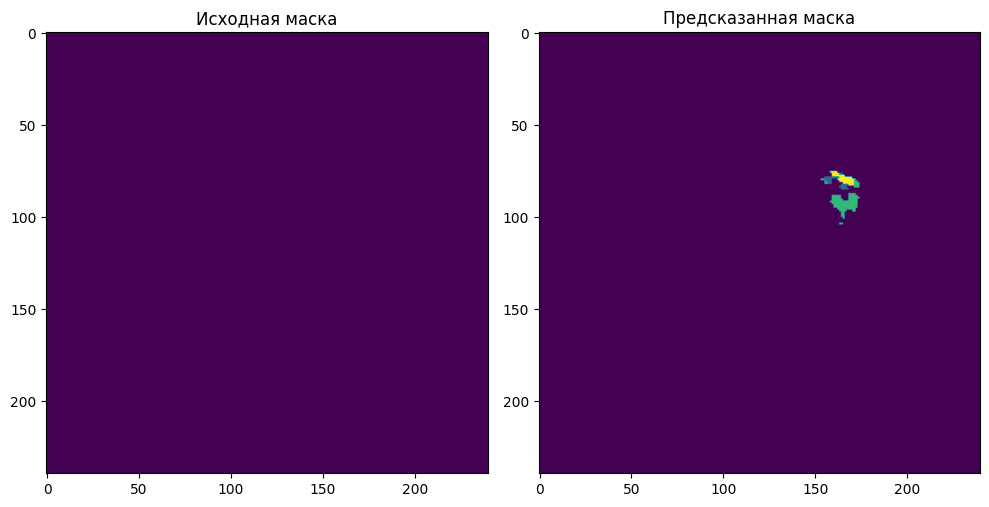

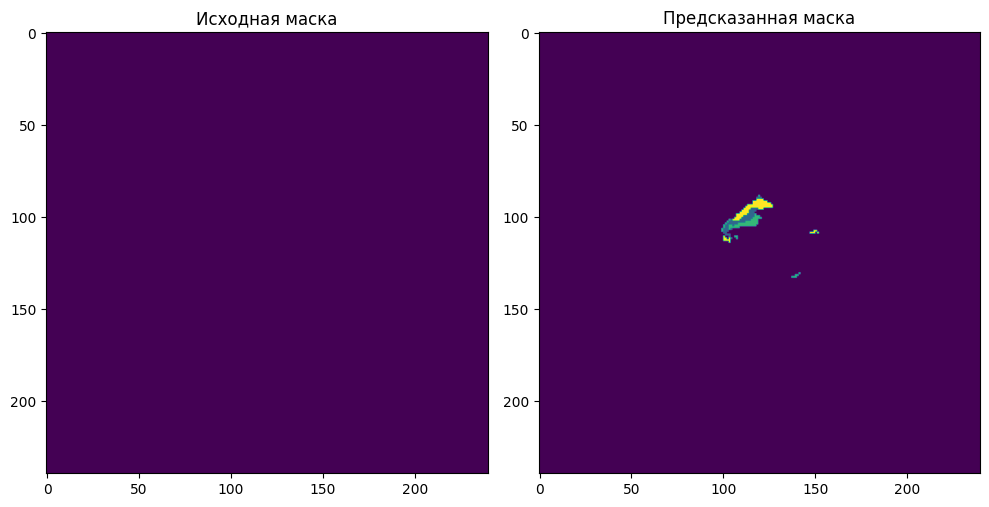

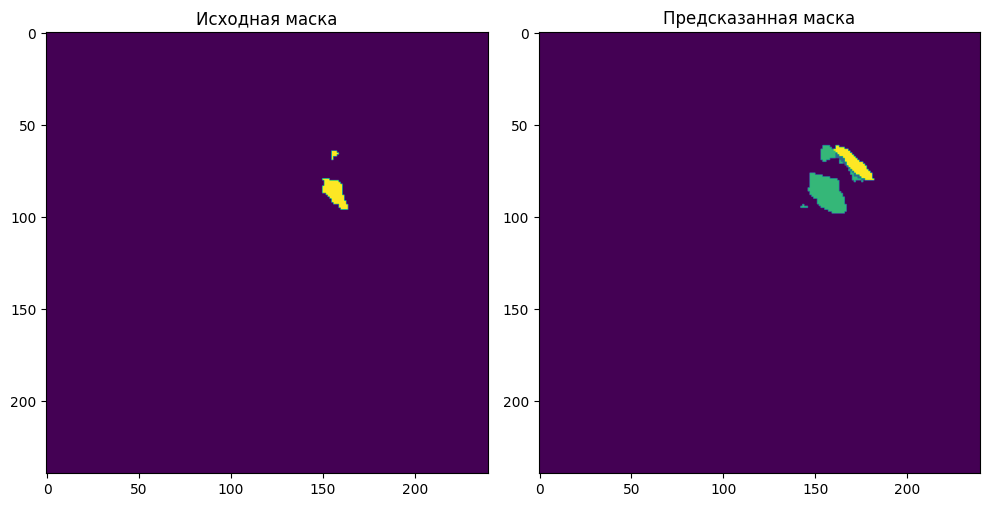

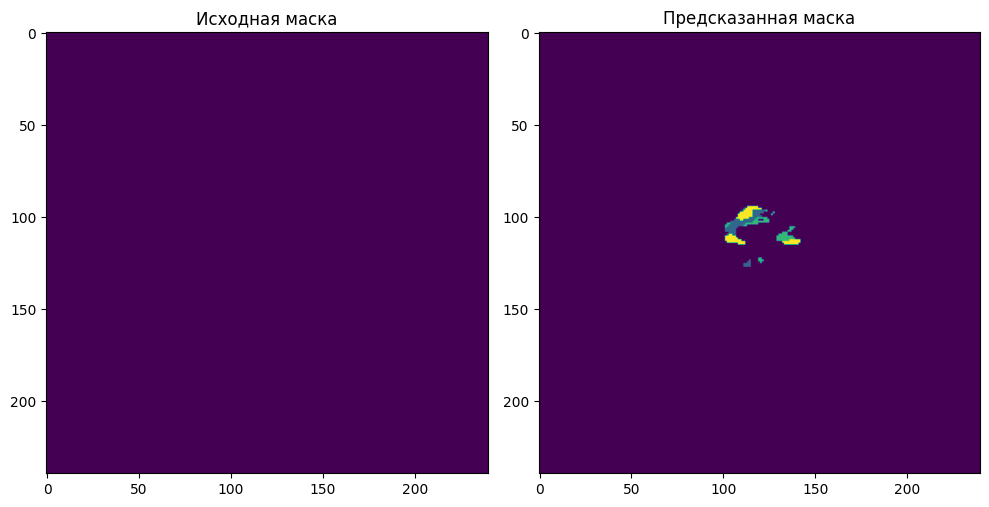

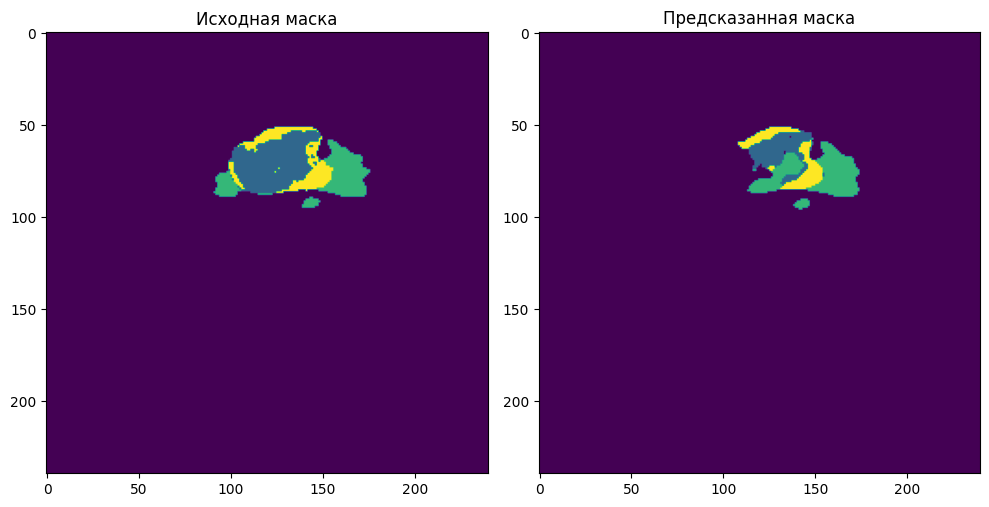

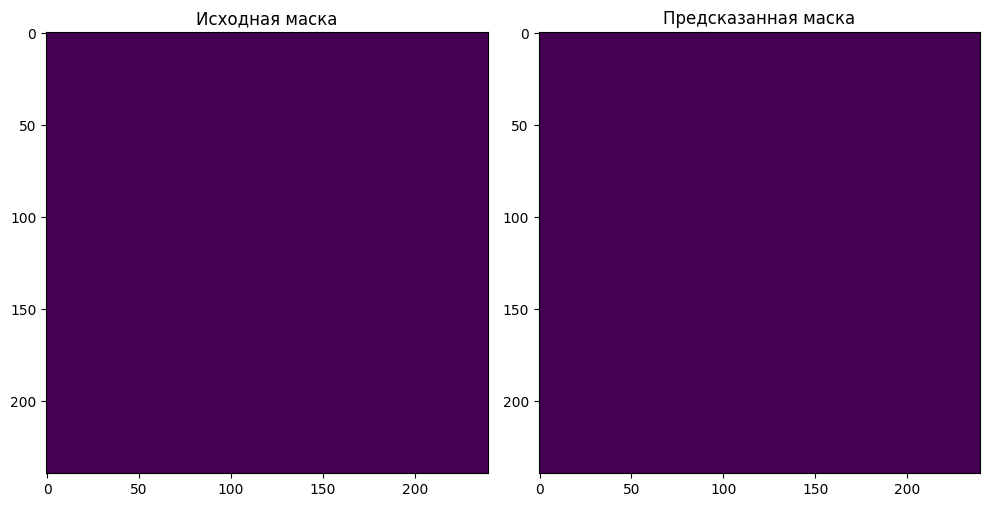

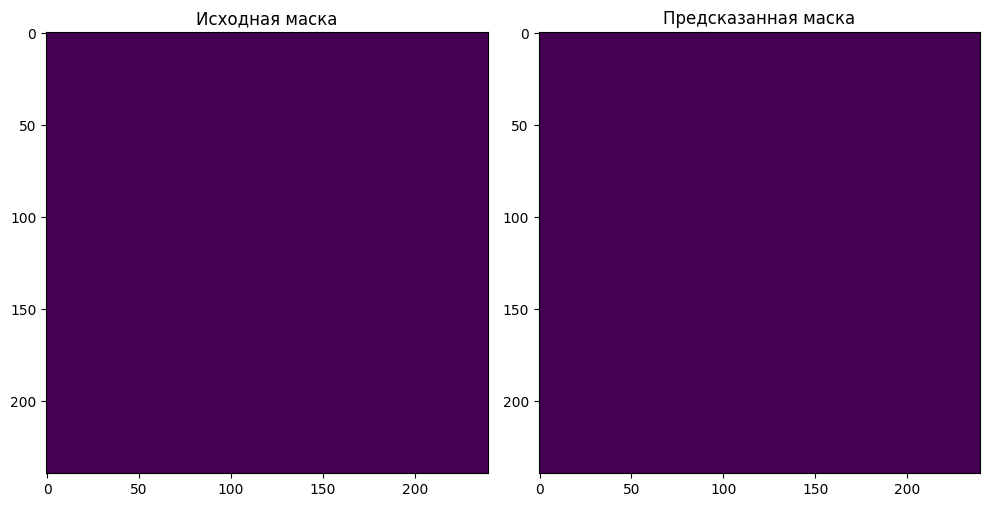

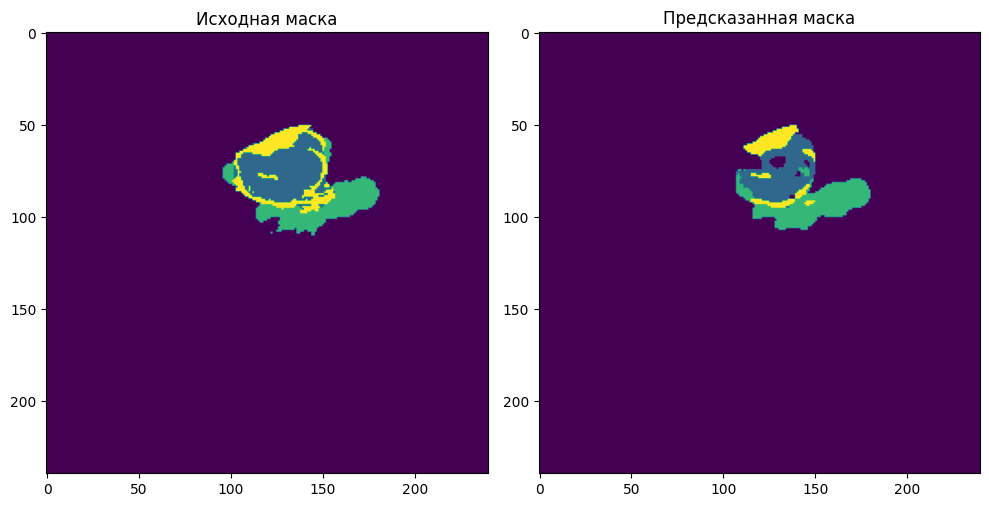

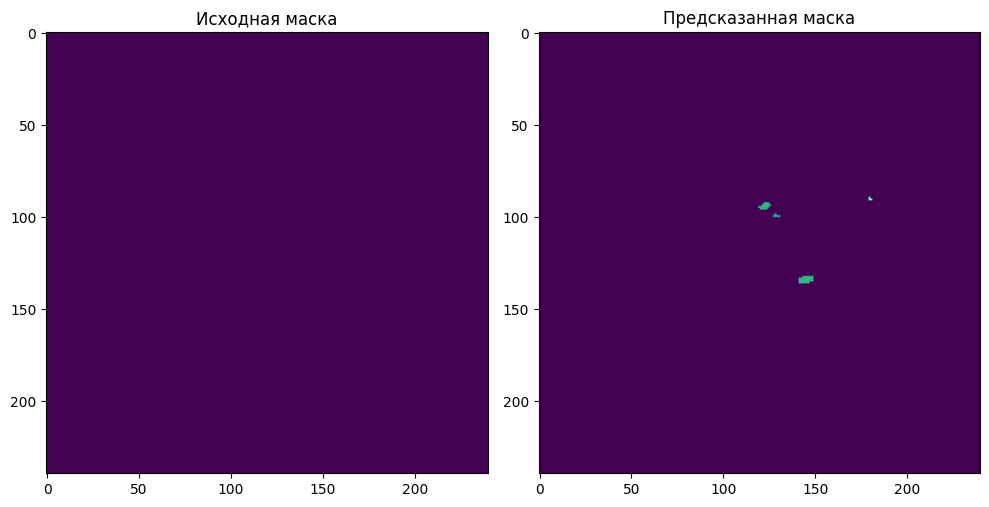

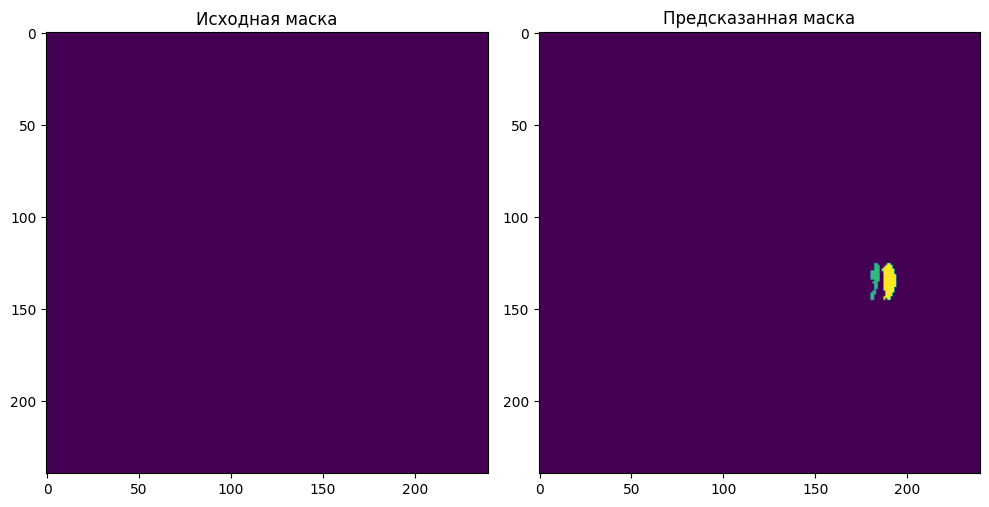

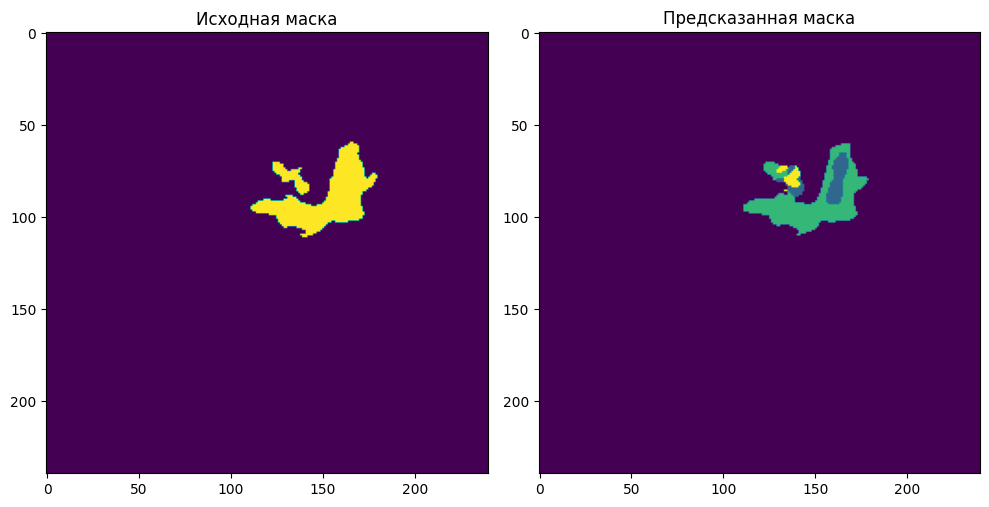

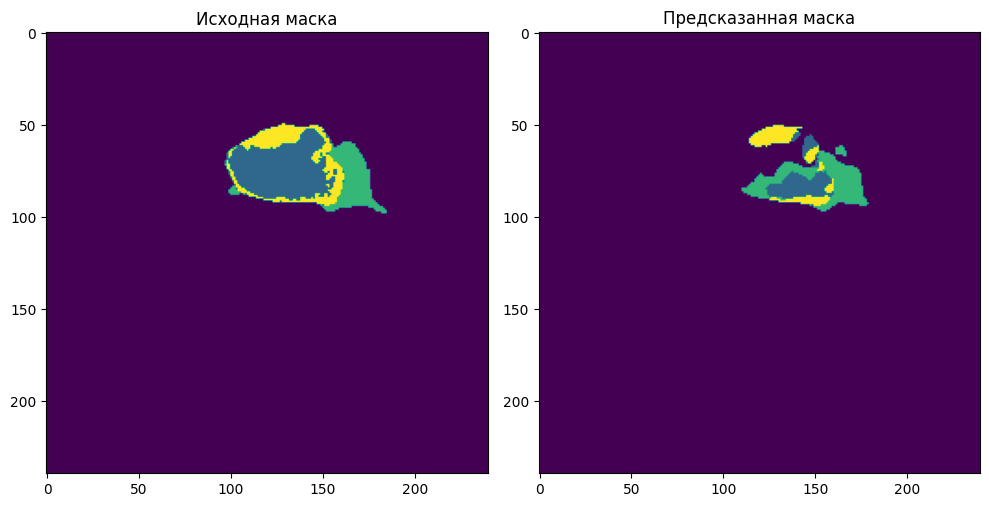

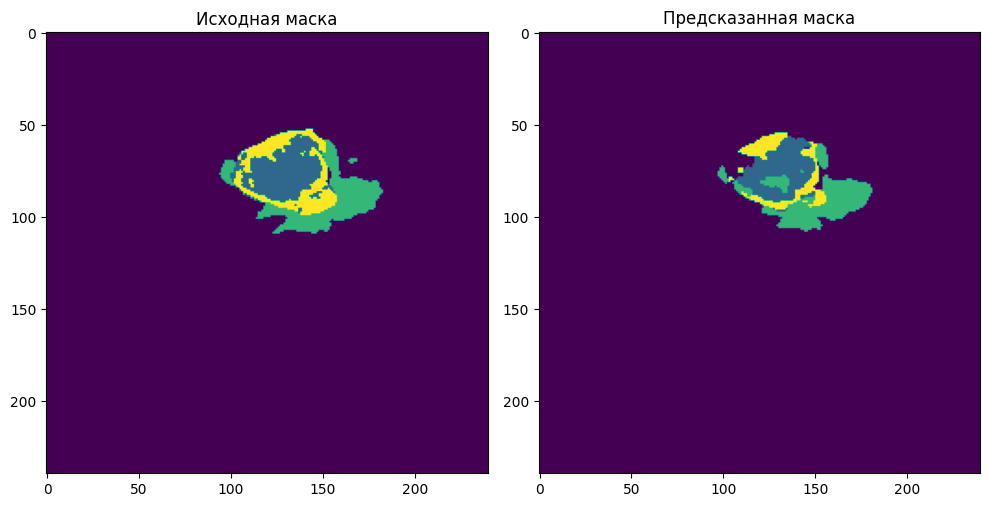

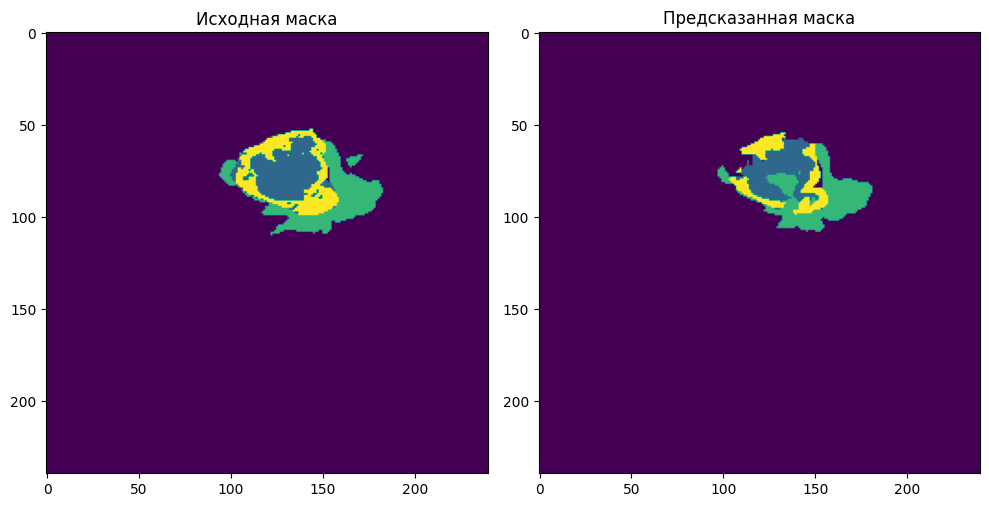

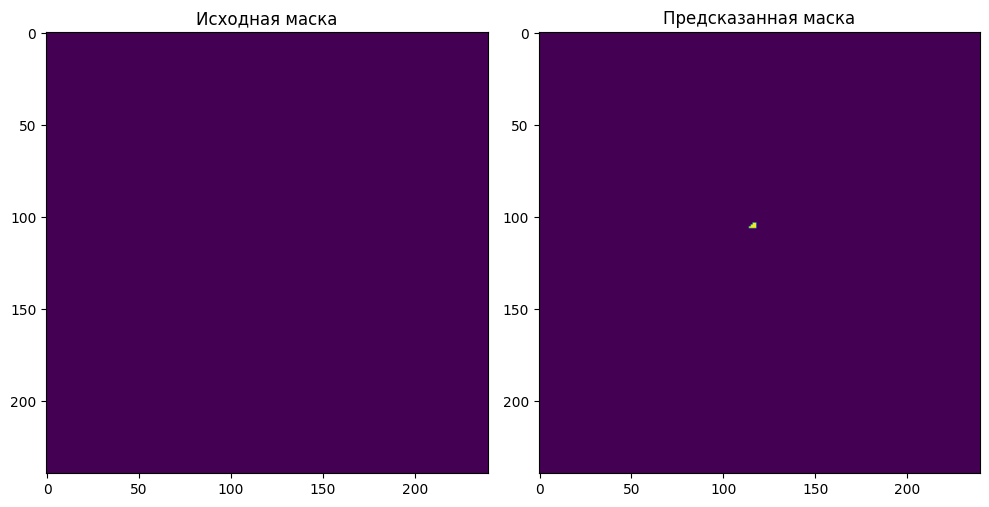

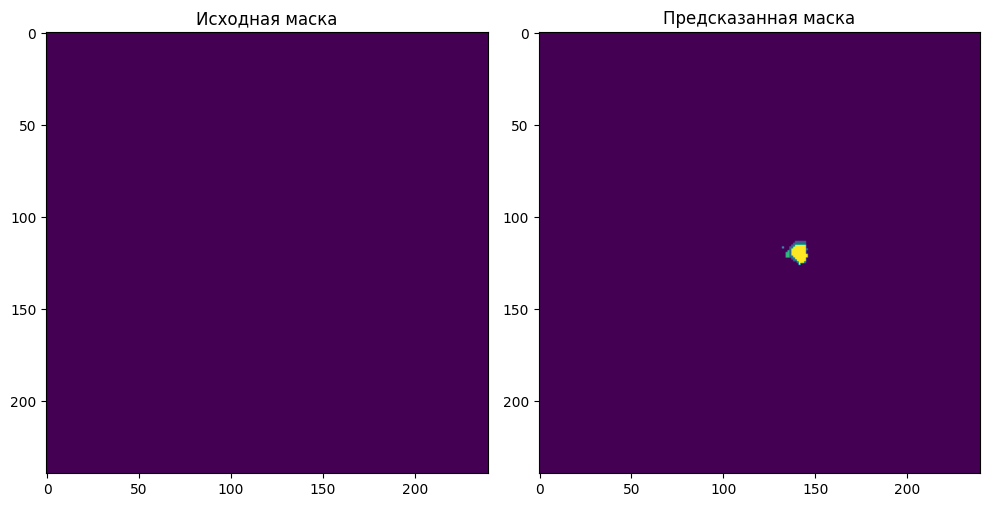

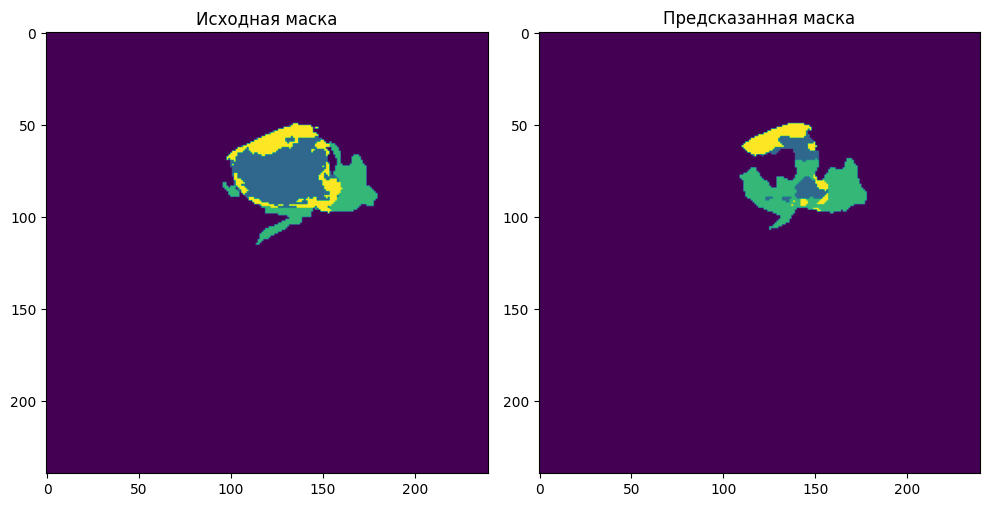

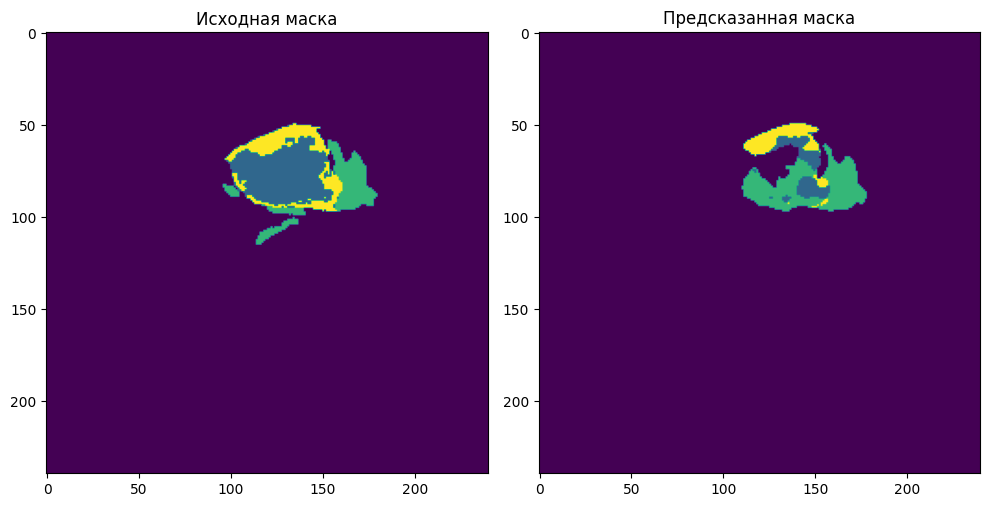

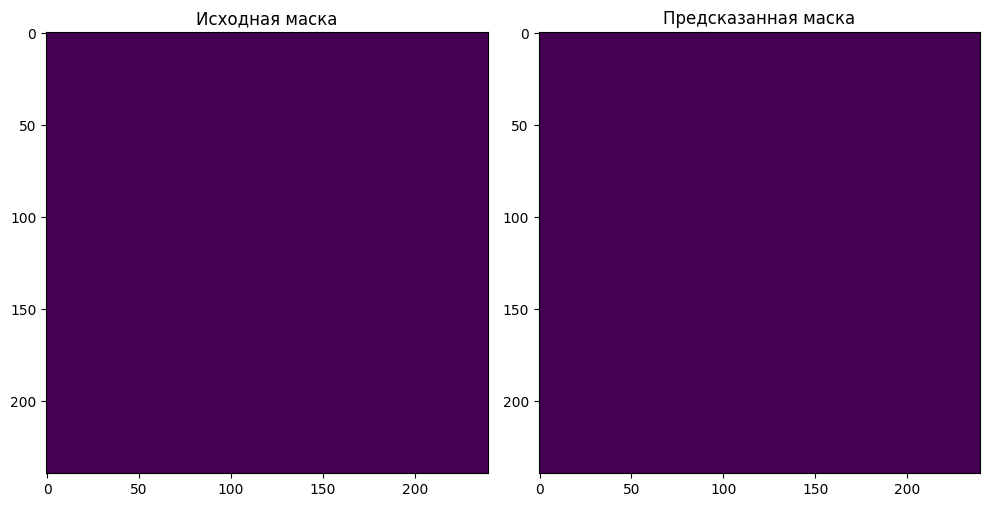

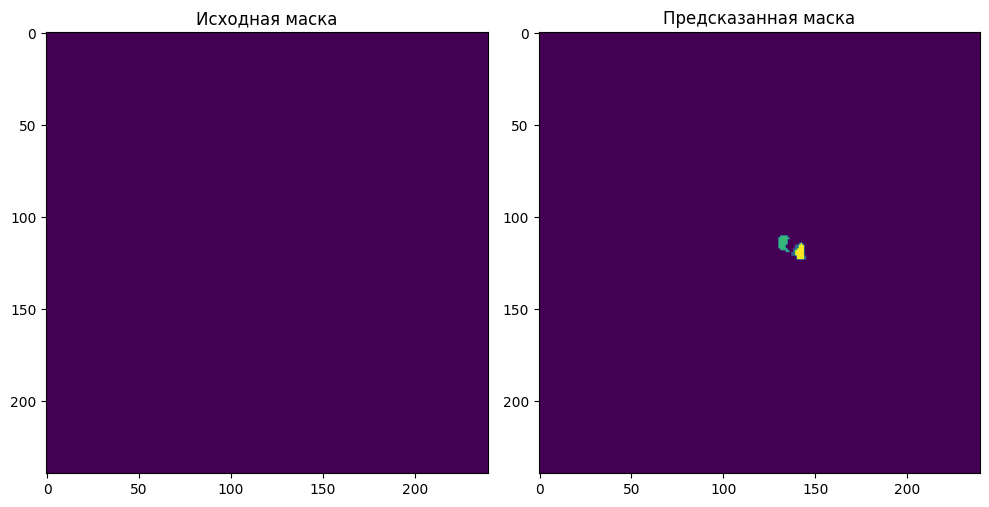

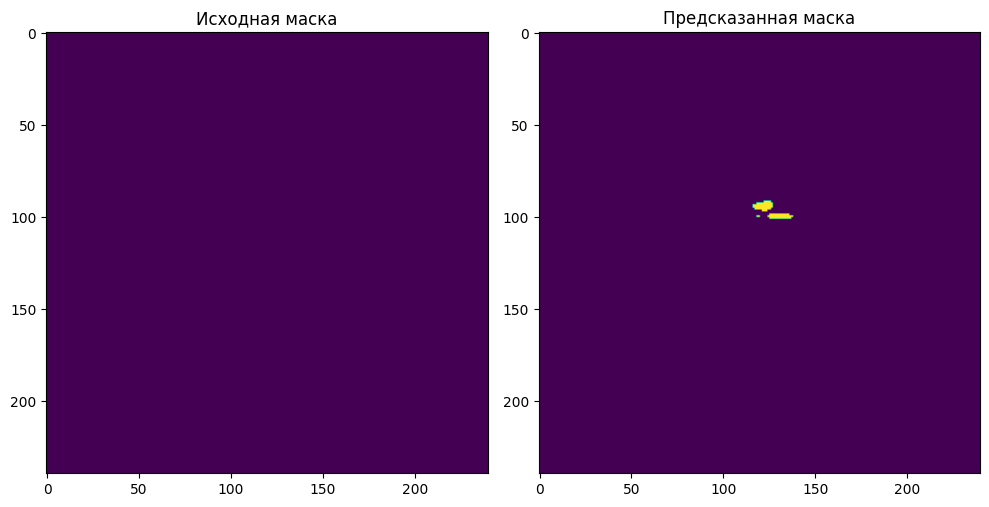

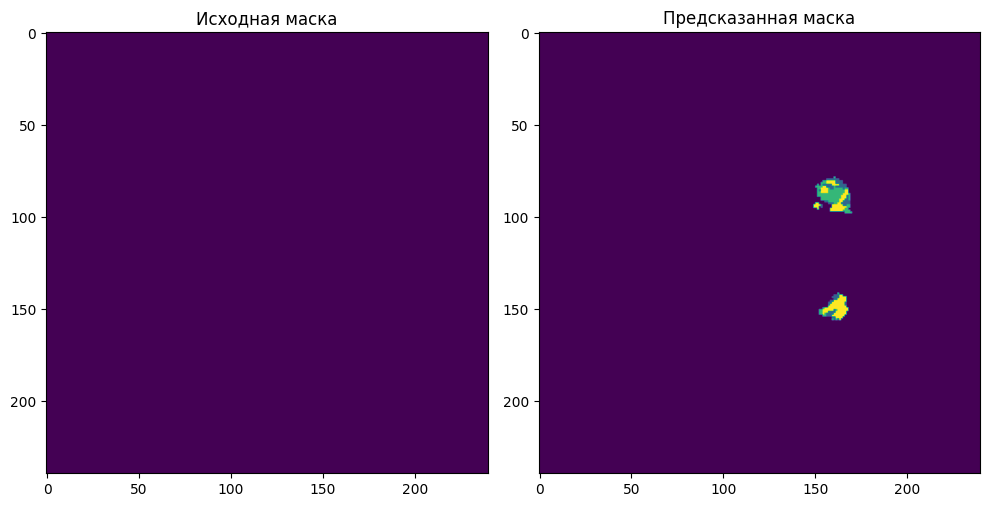

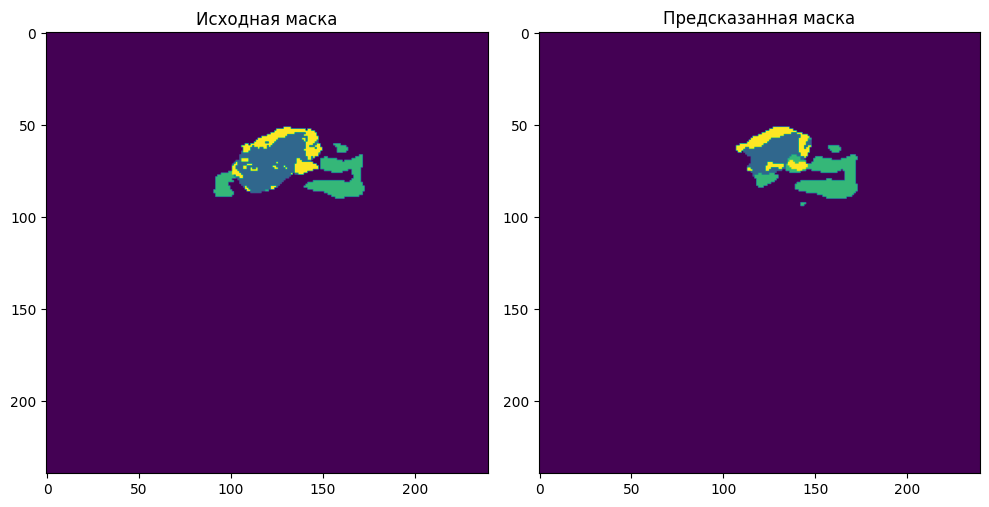

In [ ]:
try:
  while True:
       for i in range(len(patient_file_pathes)-1):
          #test_image_iterator = iter(DataLoader(patient_dataset, batch_size=1, shuffle=False))
          input, target = next(test_image_iterator)
          test_mask_show(input, target, model, CFG)
except StopIteration:
       pass

**ПОСМОТРИМ ТАКЖЕ НА ПРИМЕР ИСХОДНОЙ И ПРЕДСКАЗАННОЙ МАСКИ ВМЕСТЕ С ИСХОДНЫМ ИЗОБРАЖЕНИЕМ**

In [ ]:
# функция для визуализации исходного ихображения, обучающей маски и предсказанной маски
def test_show(model, test_input, test_target, device):
    #test_input, test_target = test_input.to(device), test_target.to(device)

    # преобразуем массивы исходного изображения, обучающей маки и предсказанной маски для визуализации
    image = test_input.detach().cpu().numpy().squeeze(0)
    mask_target = test_target.detach().cpu().numpy().squeeze(0)

    # получим предсказание на основе выбранного изображения и сразу преобразуем его для вывода на экран
    mask_pred = torch.argmax(model(test_input), dim=1).detach().cpu().numpy().squeeze(0)


    # выведем на экран исходное изображение, обучающую маку и предсказанную маску:
    image_show(image)

    fig, (axis1, axis2) = plt.subplots(1, 2, figsize=(12.61, 25.22))
    axis1.imshow(mask_target, cmap = 'gray')
    axis1.set_title('Исходная маска')

    axis2.imshow(mask_pred, cmap = 'gray')
    axis2.set_title('Предсказанная маска')

    plt.show()

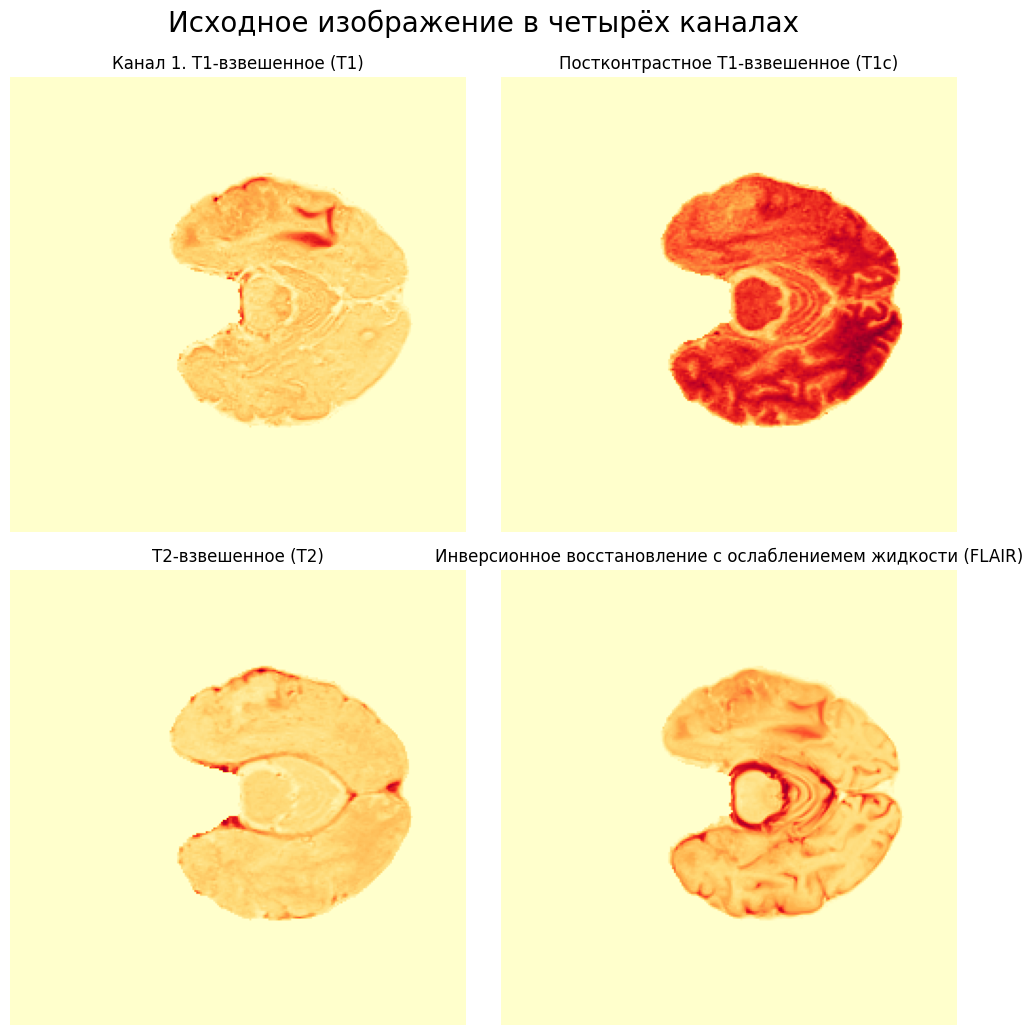

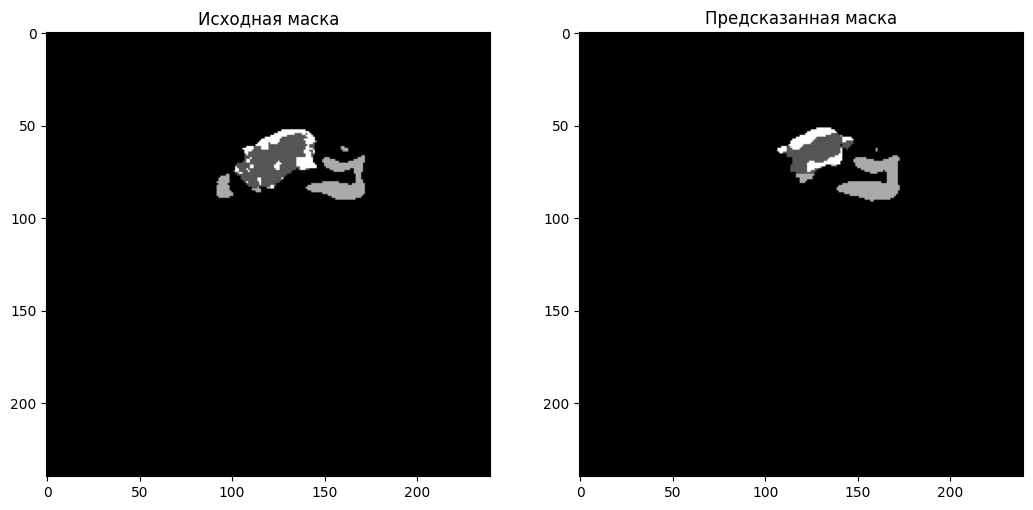

In [ ]:
# вывод на экран
test_show(model, input, target, CFG.device)